Jeg har først fjernet den række hvor data_flag=1 hvilket indikere at der er en fejl i den observation (det står i feature beskrivelsen). Dernæst har jeg fjernet hele den kolone. Efterfølgende har jeg fjernet de observationer hvor thickness er lig 0 (baseret på link i feature beskrivelsen). Det sås ydermere at der var en sammenhæng mellem manglende værdier i remarks og 0 i thickness.


Der er ish en sammenhæng mellem NA's i profile_id og NA's i glacier_name. Vil vi oberhovedet bruge en eller begge af de variable?

Det tyder ikke på at der er en sammenhæng mellem remark og thickness_uncertainty. Skal jeg erstatte NAs i remarks med none eller unknown? 

evt fjerne rækker med mange NAs

# Blibliotekker

In [81]:
import glob
import argparse
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import oggm
from oggm import utils

In [82]:
import warnings

from sklearn.model_selection import train_test_split

import xgboost as xgb

from sklearn.metrics import confusion_matrix

from sklearn.metrics import log_loss

from sklearn.metrics import accuracy_score

from sklearn.metrics import mean_squared_error

from sklearn.metrics import roc_curve

from sklearn.metrics import auc

#import lightgbm as lgb

#from lightgbm import early_stopping

#import time

from sklearn.neural_network import MLPRegressor

from xgboost import XGBRegressor

from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import randint, uniform

from sklearn.ensemble import RandomForestRegressor

from sklearn.datasets import make_regression

from sklearn.metrics import mean_absolute_error

# Load metadata, plotting marginal distributions and cross tabulations

In [3]:
# Setup oggm: important we want to use oggm's version 62 of all glacier geometries. This command will download them.
utils.get_rgi_dir(version='62')

'/Users/emma/OGGM/rgi/RGIV62'

In [83]:
path_O1_shp = '/Users/emma/OGGM/rgi/RGIV62/00_rgi62_regions/00_rgi62_O1Regions.shp' # shp file of regional boundaries

# Import 20-bin gridded training dataset
metadata_file = "//Users/emma/aml/GroupProject/metadata19-001.csv"
glathida_rgis = pd.read_csv(metadata_file, low_memory=False)

In [4]:
glathida_rgis

,GlaThiDa_ID,POLITICAL_UNIT,GLACIER_NAME,SURVEY_DATE,PROFILE_ID,POINT_ID,POINT_LAT,POINT_LON,ELEVATION,THICKNESS,...,vy_gf150,vy_gf300,vy_gf450,vy_gfa,dvx_dx,dvx_dy,dvy_dx,dvy_dy,dist_from_border_km_geom,ith_f
0,33,US,EASTON,19929999.0,NaN,1,48.767380,-121.819644,2962.0,0,...,-37.809598,-39.776861,-40.791387,-39.776861,0.028162,-0.000961,0.013785,0.009580,0.015008,21.297266
1,33,US,EASTON,19929999.0,NaN,2,48.764904,-121.821909,2813.0,29,...,-45.269147,-45.335444,-44.753770,-45.335444,0.036759,-0.021726,0.005901,0.016842,0.327097,37.278004
2,33,US,EASTON,19929999.0,NaN,3,48.761662,-121.825264,2598.0,41,...,-51.880542,-49.994305,-48.462088,-49.994305,0.036338,-0.020451,0.002879,0.002039,0.760974,47.270660
3,33,US,EASTON,19929999.0,NaN,4,48.757063,-121.829107,2383.0,71,...,-55.473354,-49.348167,-47.315097,-49.348167,0.009643,-0.014906,-0.003225,-0.003485,0.810367,77.141731
4,33,US,EASTON,19929999.0,NaN,5,48.753715,-121.832006,2284.0,82,...,-54.701241,-46.185994,-42.194644,-46.185994,-0.024083,-0.022283,-0.028956,-0.001677,0.479420,79.045029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3854274,6630,AT,MULLWITZKEES,19989999.0,NaN,27,47.092690,12.380504,3329.0,36,...,-2.722122,-7.133732,-7.938129,-7.165111,0.000657,-0.003058,-0.014911,-0.011977,0.111143,57.991867
3854275,6630,AT,MULLWITZKEES,19989999.0,NaN,28,47.093780,12.379642,3353.0,26,...,-2.958749,-7.400067,-7.788880,-6.982048,0.002024,-0.001552,-0.018537,-0.009445,0.122934,53.530384
3854276,6630,AT,MULLWITZKEES,19989999.0,NaN,29,47.094839,12.378200,3381.0,39,...,-2.518832,-6.127375,-6.571152,-6.233258,0.001730,-0.001263,-0.018579,-0.002504,0.257347,60.506504
3854277,6630,AT,MULLWITZKEES,19989999.0,NaN,30,47.094829,12.378174,3381.0,39,...,-2.518832,-6.127375,-6.571152,-6.233258,0.001730,-0.001263,-0.018579,-0.002504,0.258708,60.506504


In [354]:
# Kald funktionen og gem resultatet
counts = count_na_and_nan(glathida_rgis)

# Udskriv resultaterne
for column, count_dict in counts.items():
    print(f"Column '{column}':")
    print(f"Occurrences of 'na': {count_dict['na_count']}")
    print(f"Occurrences of 'nan': {count_dict['nan_count']}")
    print()

Column 'GlaThiDa_ID':
Occurrences of 'na': 0
Occurrences of 'nan': 0

Column 'POLITICAL_UNIT':
Occurrences of 'na': 0
Occurrences of 'nan': 0

Column 'GLACIER_NAME':
Occurrences of 'na': 0
Occurrences of 'nan': 1402056

Column 'SURVEY_DATE':
Occurrences of 'na': 0
Occurrences of 'nan': 44

Column 'PROFILE_ID':
Occurrences of 'na': 0
Occurrences of 'nan': 1463774

Column 'POINT_ID':
Occurrences of 'na': 0
Occurrences of 'nan': 0

Column 'POINT_LAT':
Occurrences of 'na': 0
Occurrences of 'nan': 0

Column 'POINT_LON':
Occurrences of 'na': 0
Occurrences of 'nan': 0

Column 'ELEVATION':
Occurrences of 'na': 0
Occurrences of 'nan': 481445

Column 'THICKNESS':
Occurrences of 'na': 0
Occurrences of 'nan': 0

Column 'THICKNESS_UNCERTAINTY':
Occurrences of 'na': 0
Occurrences of 'nan': 2329692

Column 'DATA_FLAG':
Occurrences of 'na': 0
Occurrences of 'nan': 3854278

Column 'REMARKS':
Occurrences of 'na': 0
Occurrences of 'nan': 1686043

Column 'RGI':
Occurrences of 'na': 0
Occurrences of 'nan':

In [350]:
crosstab6 = pd.crosstab(glathida_rgis['GlaThiDa_ID'], glathida_rgis['GLACIER_NAME'])
print(crosstab6)

GLACIER_NAME  A NEUVE GLACIER DE L'-N  A NEUVE GLACIER DE L'-S  AALFOTBREEN  \
GlaThiDa_ID                                                                   
33                                  0                        0            0   
319                                 0                        0            0   
362                                 0                        0            0   
466                                 0                        0            0   
486                                 0                        0            0   
...                               ...                      ...          ...   
6627                                0                        0            0   
6628                                0                        0            0   
6629                                0                        0            0   
6630                                0                        0            0   
6631                                0               

In [53]:
# Brug shape-attributtet til at få antallet af rækker og kolonner
num_rows, num_columns = glathida_rgis.shape

print(f"Antal rækker i datasættet: {num_rows}")
print(f"Antal kolonner i datasættet: {num_columns}")

# Beregn antallet af manglende værdier i hver række og kolonne
num_missing_rows = glathida_rgis.isna().any(axis=1).sum()
num_missing_columns = glathida_rgis.isna().any(axis=0).sum()

print(f"Antal rækker med manglende værdier: {num_missing_rows}")
print(f"Antal kolonner med manglende værdier: {num_missing_columns}")

Antal rækker i datasættet: 3854279
Antal kolonner i datasættet: 70
Antal rækker med manglende værdier: 3854279
Antal kolonner med manglende værdier: 40


In [54]:
len(pd.unique(glathida_rgis['GlaThiDa_ID']))

4681

In [75]:
for col in glathida_rgis.columns:
    print(f"{col}: {glathida_rgis[col].dtype}")

GlaThiDa_ID: int64
POLITICAL_UNIT: object
GLACIER_NAME: object
SURVEY_DATE: float64
PROFILE_ID: object
POINT_ID: object
POINT_LAT: float64
POINT_LON: float64
ELEVATION: float64
THICKNESS: int64
THICKNESS_UNCERTAINTY: float64
DATA_FLAG: float64
REMARKS: object
RGI: float64
RGIId: object
Area: float64
Zmin: float64
Zmax: float64
Zmed: float64
Slope: float64
Lmax: float64
Form: float64
TermType: float64
Aspect: float64
dmdtda_hugo: float64
elevation: float64
slope_lat: float64
slope_lon: float64
slope_lat_gf50: float64
slope_lon_gf50: float64
slope_lat_gf100: float64
slope_lon_gf100: float64
slope_lat_gf150: float64
slope_lon_gf150: float64
slope_lat_gf300: float64
slope_lon_gf300: float64
slope_lat_gf450: float64
slope_lon_gf450: float64
slope_lat_gfa: float64
slope_lon_gfa: float64
curv_50: float64
curv_300: float64
curv_gfa: float64
aspect_50: float64
aspect_300: float64
aspect_gfa: float64
smb: float64
ith_m: float64
vx: float64
vy: float64
vx_gf50: float64
vx_gf100: float64
vx_gf150:

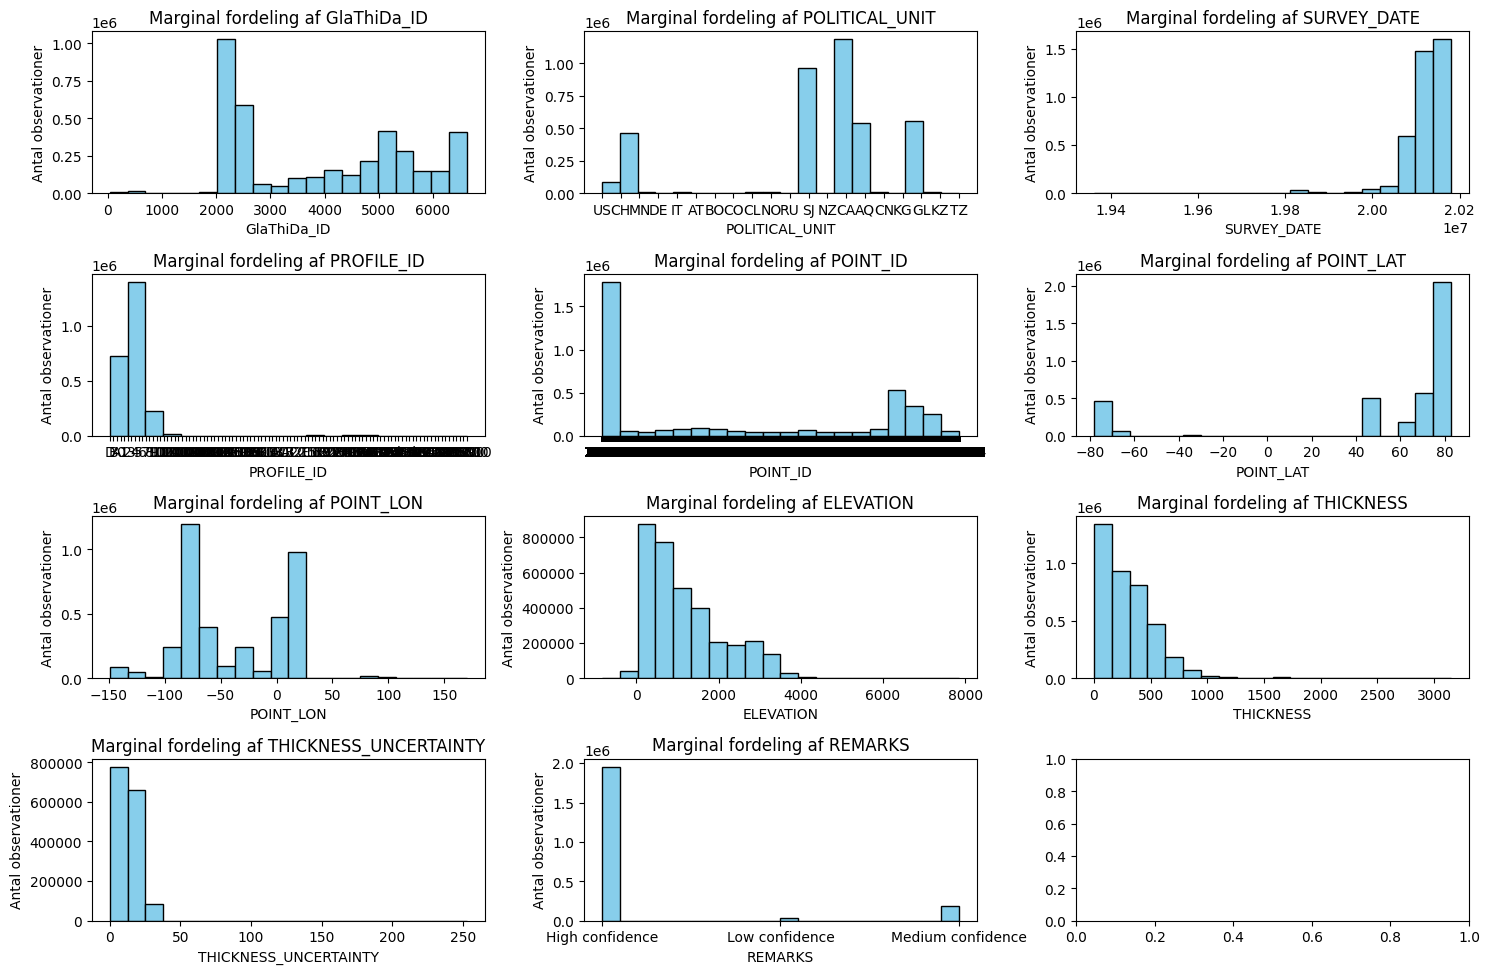

In [277]:
# Plot de marginale fordelinger af hver variabel
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))

columns_to_plot = ['GlaThiDa_ID', 'POLITICAL_UNIT',
                   'SURVEY_DATE','PROFILE_ID', 'POINT_ID', 
                   'POINT_LAT','POINT_LON', 'ELEVATION',
                   'THICKNESS','THICKNESS_UNCERTAINTY', "REMARKS"]

for i, col in enumerate(columns_to_plot):
    ax = axes[i // 3, i % 3]
    glathida_rgis[col].hist(ax=ax, bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'Marginal fordeling af {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Antal observationer')
    ax.grid(False)

# Juster layout
plt.tight_layout()
plt.show()

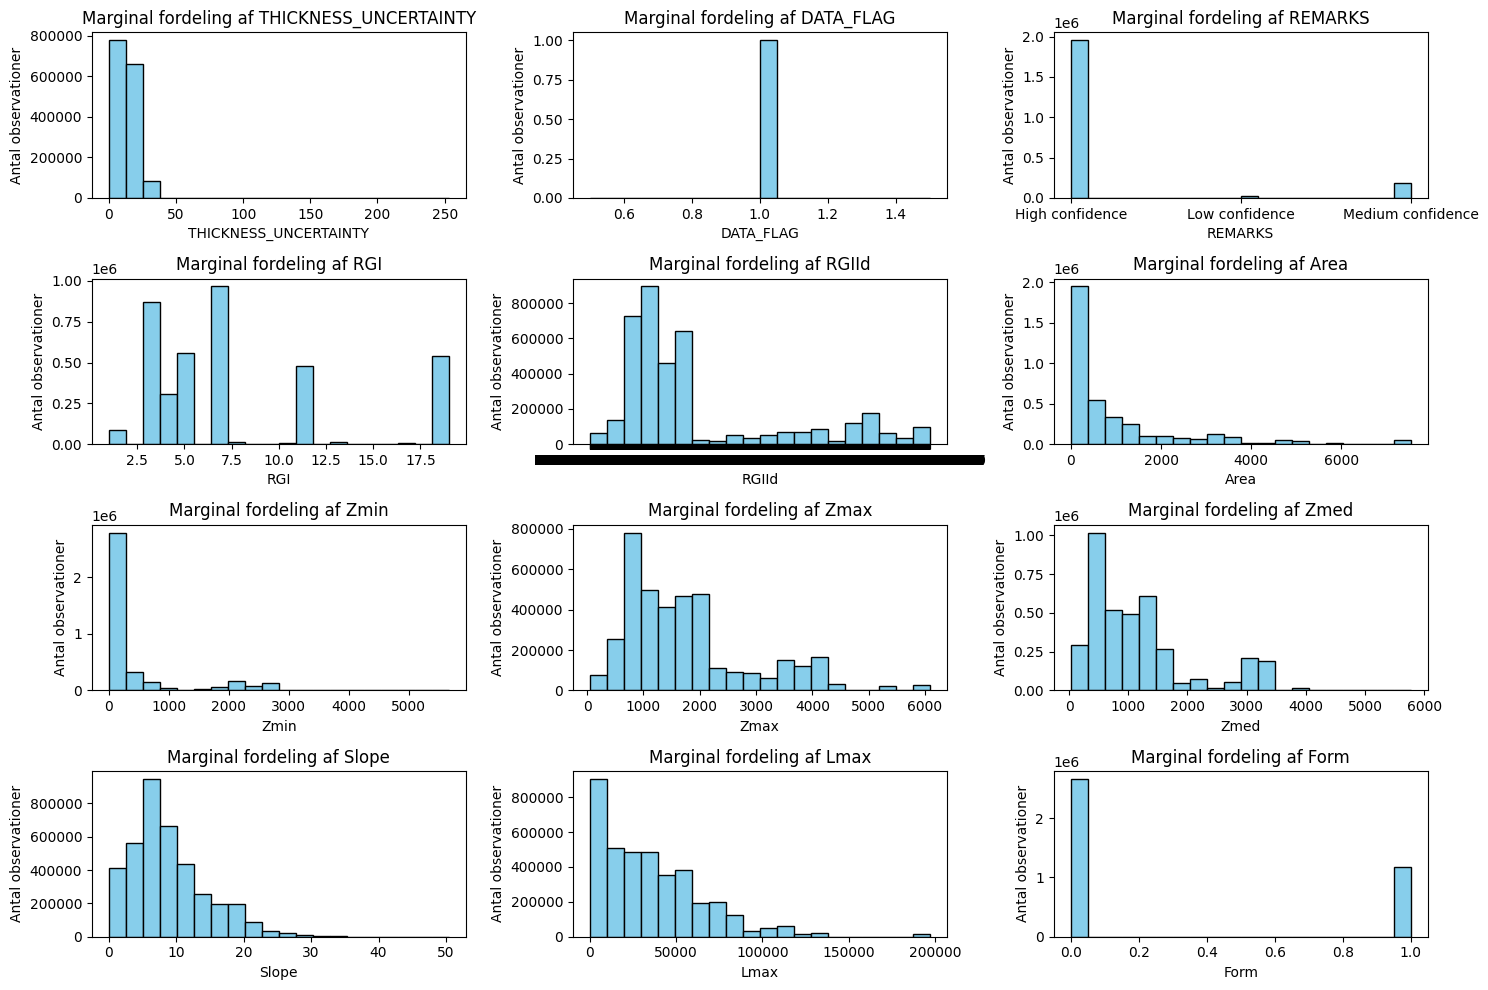

In [37]:
# Plot de marginale fordelinger af hver variabel
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))

columns_to_plot = ['THICKNESS_UNCERTAINTY', 'DATA_FLAG',
                   'REMARKS','RGI', 'RGIId', 
                   'Area','Zmin', 'Zmax',
                   'Zmed','Slope', "Lmax", 'Form']

for i, col in enumerate(columns_to_plot):
    ax = axes[i // 3, i % 3]
    glathida_rgis[col].hist(ax=ax, bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'Marginal fordeling af {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Antal observationer')
    ax.grid(False)

# Juster layout
plt.tight_layout()
plt.show()

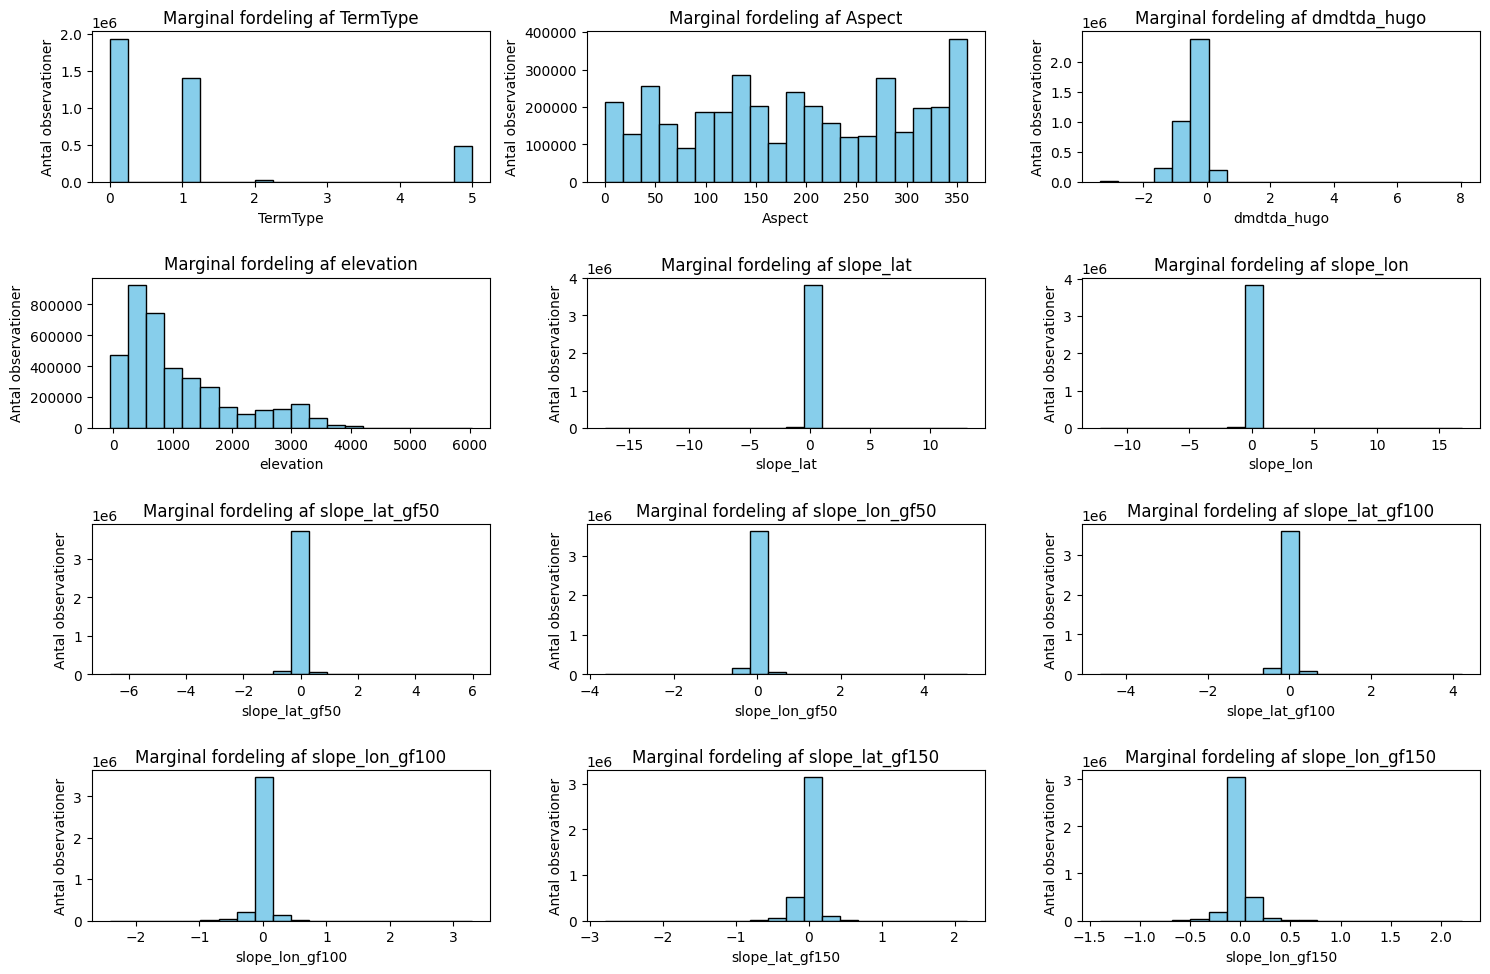

In [38]:
# Plot de marginale fordelinger af hver variabel
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))

columns_to_plot = ['TermType', 'Aspect',
                   'dmdtda_hugo','elevation', 'slope_lat', 
                   'slope_lon','slope_lat_gf50', 'slope_lon_gf50',
                   'slope_lat_gf100','slope_lon_gf100', "slope_lat_gf150", 'slope_lon_gf150']

for i, col in enumerate(columns_to_plot):
    ax = axes[i // 3, i % 3]
    glathida_rgis[col].hist(ax=ax, bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'Marginal fordeling af {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Antal observationer')
    ax.grid(False)

# Juster layout
plt.tight_layout()
plt.show()

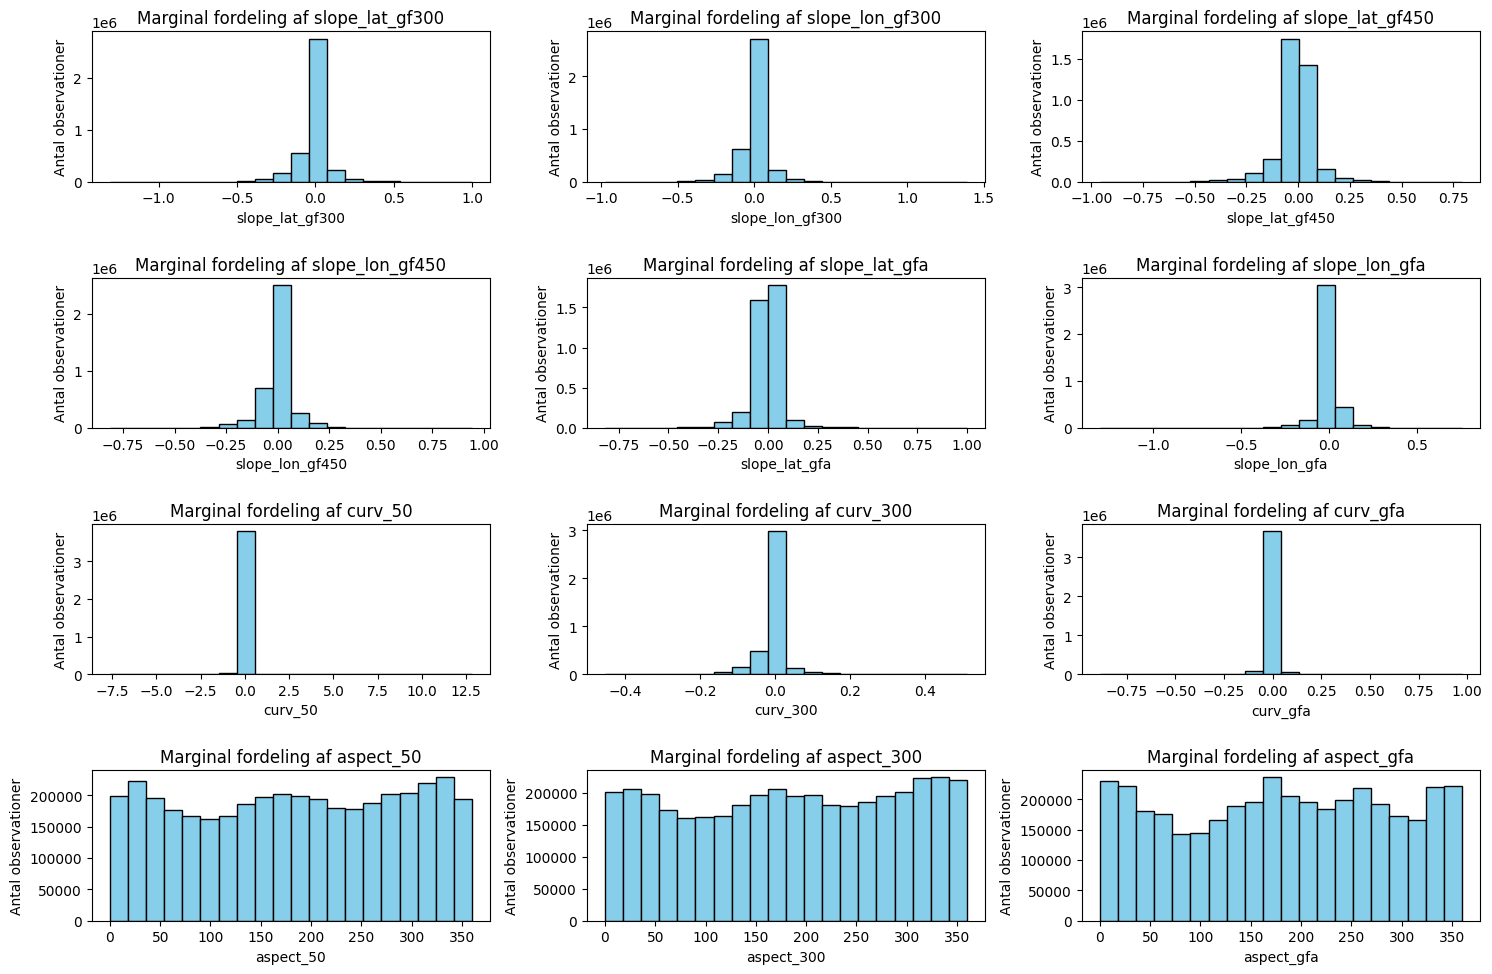

In [39]:
# Plot de marginale fordelinger af hver variabel
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))

columns_to_plot = ['slope_lat_gf300', 'slope_lon_gf300',
                   'slope_lat_gf450','slope_lon_gf450', 'slope_lat_gfa', 
                   'slope_lon_gfa','curv_50', 'curv_300',
                   'curv_gfa','aspect_50', "aspect_300", 'aspect_gfa']

for i, col in enumerate(columns_to_plot):
    ax = axes[i // 3, i % 3]
    glathida_rgis[col].hist(ax=ax, bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'Marginal fordeling af {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Antal observationer')
    ax.grid(False)

# Juster layout
plt.tight_layout()
plt.show()

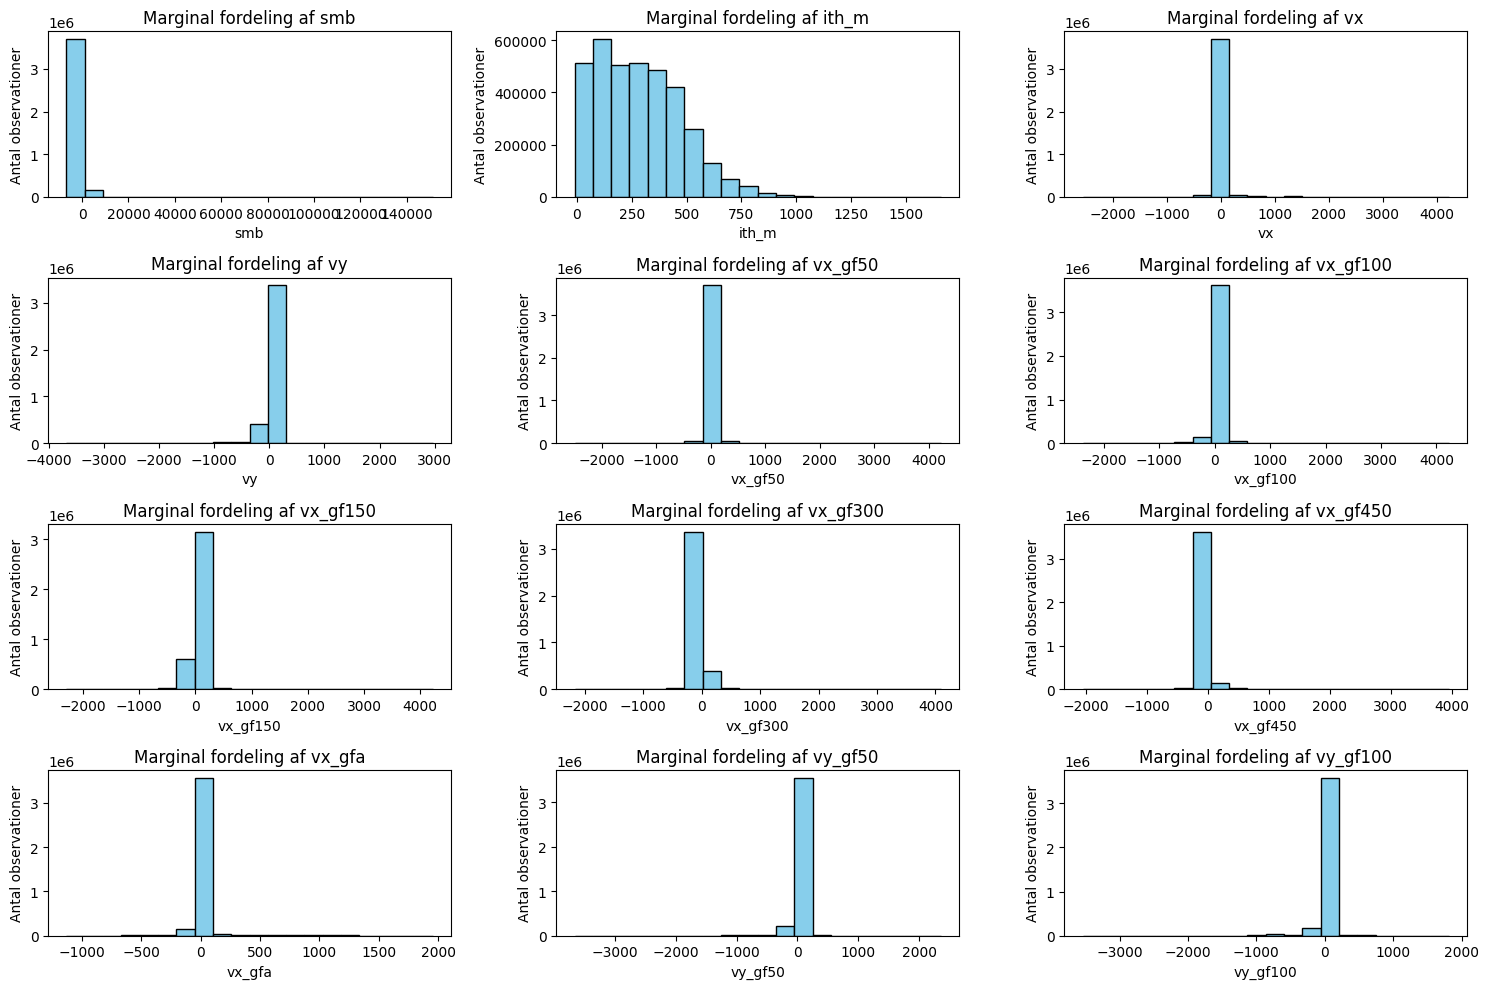

In [40]:
# Plot de marginale fordelinger af hver variabel
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))

columns_to_plot = ['smb', 'ith_m',
                   'vx','vy', 'vx_gf50', 
                   'vx_gf100','vx_gf150', 'vx_gf300',
                   'vx_gf450','vx_gfa', "vy_gf50", 'vy_gf100']

for i, col in enumerate(columns_to_plot):
    ax = axes[i // 3, i % 3]
    glathida_rgis[col].hist(ax=ax, bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'Marginal fordeling af {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Antal observationer')
    ax.grid(False)

# Juster layout
plt.tight_layout()
plt.show()

In [41]:
# Beregn 'slope_total' for hver række
glathida_rgis['slope_total'] = np.sqrt(glathida_rgis['slope_lat']**2 + glathida_rgis['slope_lon']**2)

glathida_rgis['slope_total_gfa'] = np.sqrt(glathida_rgis['slope_lat_gfa']**2 + glathida_rgis['slope_lon_gfa']**2)

# Gem det opdaterede datasæt tilbage til en ny CSV-fil
#df.to_csv('glathida_rgis_edited_with_slope_total.csv', index=False)

#print("Beregningen af 'slope_total' er fuldført, og resultatet er gemt i 'glathida_rgis_edited_with_slope_total.csv'")

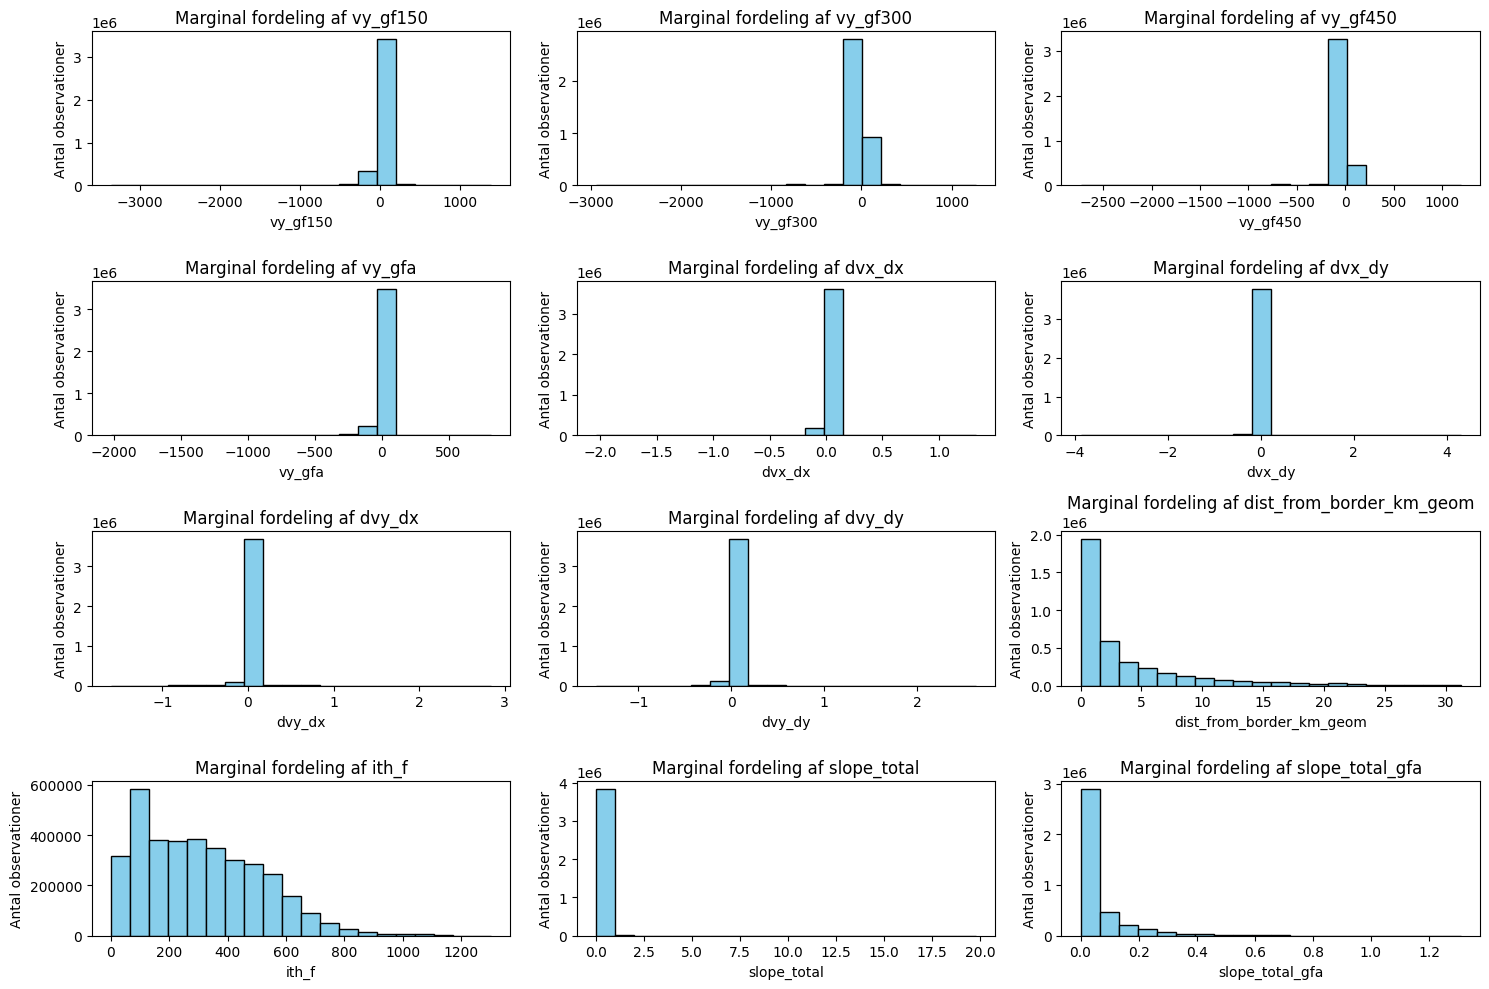

In [42]:
# Plot de marginale fordelinger af hver variabel
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))

columns_to_plot = ['vy_gf150', 'vy_gf300',
                   'vy_gf450','vy_gfa', 'dvx_dx', 
                   'dvx_dy','dvy_dx', 'dvy_dy',
                   'dist_from_border_km_geom','ith_f', "slope_total", 'slope_total_gfa']

for i, col in enumerate(columns_to_plot):
    ax = axes[i // 3, i % 3]
    glathida_rgis[col].hist(ax=ax, bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'Marginal fordeling af {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Antal observationer')
    ax.grid(False)

# Juster layout
plt.tight_layout()
plt.show()

In [285]:
pd.unique(glathida_rgis['THICKNESS_UNCERTAINTY'])

array([ nan,   4.,   3.,   2.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         1.,  12.,  15.,  13.,   0.,  17.,  18.,  19.,  14.,  21.,  16.,
        20.,  22.,  23., 253.,  28.,  27.,  26.,  24.,  41.,  31.,  50.,
        25.,  38.,  29.,  43.,  34.,  39.,  35.,  42.,  44.,  37.,  30.,
        32.,  33.,  36.,  40.])

In [134]:
pd.unique(glathida_rgis["GlaThiDa_ID"])

array([  33,  319,  362, ..., 6629, 6630, 6631])

In [135]:
pd.unique(glathida_rgis["POLITICAL_UNIT"])

array(['US', 'CH', 'MN', 'DE', 'IT', 'AT', 'BO', 'CO', 'CL', 'NO', 'RU',
       'SJ', 'NZ', 'CA', 'AQ', 'CN', 'KG', 'GL', 'KZ', 'TZ'], dtype=object)

In [137]:
pd.unique(glathida_rgis["PROFILE_ID"])

array([nan, 'D', 'B', 'A', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       '9', '10', '11', '12', '13', '14', 'L10010', 'L10020', 'L10030',
       'L10040', 'L10050', 'L10060', 'L10070', 'L10080', 'L10090',
       'L10110', 'L10120', 'L10131', 'L10141', 'L10151', 'L10161',
       'L10171', 'L10190', 'L19010', 'L19020', 'BH', 'STOR1', 'S6', 'S7',
       'S8', 'S10', 'S11', 'S12', 'E', 'W', 'A1', 'B1', 'C1', 'A2', 'B2',
       'C2', 'C', 'F', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', 'F05T02a', 'GL0033a', 'X05a', 'Y09a', 'GMG2a', 'H2HMa',
       'H3H2a', 'G2G3a', 'ROTHMa', 'BIS01d', 'BIS01c', 'Y18a', 'Y25a',
       'MCM02b', 'X63a', 'X68a', 'X83a', 'Y43a', 'X13a', 'F03T11a',
       'F03T12a', 'F20T01a', '111224', '153515', '144508', '150131',
       '151905', '142858', '142659', 'L20050', 'L20070', 'L20080',
       'L20090', 'L20100', 'L20110'], dtype=object)

In [206]:
pd.unique(glathida_rgis["REMARKS"])

array([nan, 'High confidence', 'Low confidence', 'Medium confidence'],
      dtype=object)

In [213]:
len(pd.unique(glathida_rgis["GLACIER_NAME"]))

527

In [208]:
pd.unique(glathida_rgis["THICKNESS_UNCERTAINTY"])

array([ nan,   4.,   3.,   2.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         1.,  12.,  15.,  13.,   0.,  17.,  18.,  19.,  14.,  21.,  16.,
        20.,  22.,  23., 253.,  28.,  27.,  26.,  24.,  41.,  31.,  50.,
        25.,  38.,  29.,  43.,  34.,  39.,  35.,  42.,  44.,  37.,  30.,
        32.,  33.,  36.,  40.])

In [89]:
#pd.unique(glathida_rgis["REMARKS"])
pd.unique(glathida_rgis["DATA_FLAG"])

array([0., 1.])

In [140]:
# Erstat alle NaN-værdier i kolonnen 'DATA_FLAG' med 0
glathida_rgis['DATA_FLAG'].fillna(0, inplace=True)

In [160]:
# Tæl antallet af forekomster af hver unik værdi i kolonnen 'DATA_FLAG'
flag_counts = glathida_rgis['DATA_FLAG'].value_counts()

# Udskriv antallet af 0'er og 1'ere
print("Antal 0'er:", flag_counts.get(0, 0))
print("Antal 1'ere:", flag_counts.get(1, 0))

Antal 0'er: 3854278
Antal 1'ere: 1


In [142]:
# Lav et udtræk af rækkerne hvor 'DATA_FLAG' er lig med 1
data_flag_1 = glathida_rgis[glathida_rgis['DATA_FLAG'] == 1]

# Udskriv det resulterende udtræk
print(data_flag_1)

       GlaThiDa_ID POLITICAL_UNIT        GLACIER_NAME  SURVEY_DATE PROFILE_ID  \
25574         1961             AT  GROSSER RIEPENKEES   19989999.0        NaN   

      POINT_ID  POINT_LAT  POINT_LON  ELEVATION  THICKNESS  \
25574       20  47.056622  11.672612     3014.0       2530   

       THICKNESS_UNCERTAINTY  DATA_FLAG REMARKS   RGI           RGIId   Area  \
25574                  253.0        1.0     NaN  11.0  RGI60-11.00353  0.389   

         Zmin    Zmax    Zmed  Slope   Lmax  Form  TermType  Aspect  \
25574  2782.0  3111.0  2947.0   20.6  775.0   0.0       0.0   141.0   

       dmdtda_hugo    elevation  slope_lat  slope_lon  slope_lat_gf50  \
25574      -0.9624  3044.499294   0.174042  -0.315608        0.256878   

       slope_lon_gf50  slope_lat_gf100  slope_lon_gf100  slope_lat_gf150  \
25574       -0.228827          0.23638         -0.18599         0.207956   

       slope_lon_gf150  slope_lat_gf300  slope_lon_gf300  slope_lat_gf450  \
25574        -0.152794         

In [96]:
# Juster displayindstillinger for at vise alle kolonner
pd.set_option('display.max_columns', None)

# Antag at 'glathida_rgis' er dit DataFrame

# Lav et udtræk af rækkerne hvor 'DATA_FLAG' er lig med 1
data_flag_1 = glathida_rgis[glathida_rgis['DATA_FLAG'] == 1]

# Udskriv det resulterende udtræk
print(data_flag_1)

       GlaThiDa_ID POLITICAL_UNIT        GLACIER_NAME  SURVEY_DATE PROFILE_ID  \
25574         1961             AT  GROSSER RIEPENKEES   19989999.0        NaN   

      POINT_ID  POINT_LAT  POINT_LON  ELEVATION  THICKNESS  \
25574       20  47.056622  11.672612     3014.0       2530   

       THICKNESS_UNCERTAINTY  DATA_FLAG REMARKS   RGI           RGIId   Area  \
25574                  253.0        1.0     NaN  11.0  RGI60-11.00353  0.389   

         Zmin    Zmax    Zmed  Slope   Lmax  Form  TermType  Aspect  \
25574  2782.0  3111.0  2947.0   20.6  775.0   0.0       0.0   141.0   

       dmdtda_hugo    elevation  slope_lat  slope_lon  slope_lat_gf50  \
25574      -0.9624  3044.499294   0.174042  -0.315608        0.256878   

       slope_lon_gf50  slope_lat_gf100  slope_lon_gf100  slope_lat_gf150  \
25574       -0.228827          0.23638         -0.18599         0.207956   

       slope_lon_gf150  slope_lat_gf300  slope_lon_gf300  slope_lat_gf450  \
25574        -0.152794         

In [252]:
# Fjern rækkerne hvor 'DATA_FLAG' er lig med 1
glathida_rgis_edited = glathida_rgis[glathida_rgis['DATA_FLAG'] != 1]

# Fjern kolonnen "DATA_FLAG"
glathida_rgis_edited.drop("DATA_FLAG", axis=1, inplace=True)

/var/folders/1g/49w0mvjs0nd8ss7lr_13tgd40000gn/T/ipykernel_78828/1933956972.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  glathida_rgis_edited.drop("DATA_FLAG", axis=1, inplace=True)


In [246]:
# Brug shape-attributtet til at få antallet af rækker og kolonner
num_rows, num_columns = glathida_rgis_edited.shape

print(f"Antal rækker i datasættet: {num_rows}")
print(f"Antal kolonner i datasættet: {num_columns}")

# FØR fjernelse af thickness=0 : 3.854.278 og 67
# EFTER: 3.679.350

Antal rækker i datasættet: 3679350
Antal kolonner i datasættet: 67


In [259]:
# Opret et subset, hvor 'THICKNESS' er forskellig fra 0
glathida_rgis_edited = glathida_rgis_edited[glathida_rgis_edited['THICKNESS'] != 0]

# Udskriv det resulterende subset for at kontrollere
print(glathida_rgis_edited)

         GlaThiDa_ID POLITICAL_UNIT  GLACIER_NAME  SURVEY_DATE PROFILE_ID  \
1                 33             US        EASTON   19929999.0        NaN   
2                 33             US        EASTON   19929999.0        NaN   
3                 33             US        EASTON   19929999.0        NaN   
4                 33             US        EASTON   19929999.0        NaN   
5                 33             US        EASTON   19929999.0        NaN   
...              ...            ...           ...          ...        ...   
3854274         6630             AT  MULLWITZKEES   19989999.0        NaN   
3854275         6630             AT  MULLWITZKEES   19989999.0        NaN   
3854276         6630             AT  MULLWITZKEES   19989999.0        NaN   
3854277         6630             AT  MULLWITZKEES   19989999.0        NaN   
3854278         6631             AT  MULLWITZKEES   20039999.0        NaN   

        POINT_ID  POINT_LAT   POINT_LON  ELEVATION  THICKNESS  \
1         

# Cleaning the data

## Checker for missing values

In [261]:
import pandas as pd
import re

# Antag at "glathida_rgis.csv" er dit datasæt
# Læs datasættet ind i en pandas DataFrame

def count_na_and_nan(dataframe):
    counts = {}
    for column in dataframe.columns:
        # Konverter kolonneværdier til strenge, hvis de ikke allerede er strenge
        column_values_as_strings = dataframe[column].astype(str)
        
        # Saml alle værdier fra kolonnen til én lang streng
        column_text = " ".join(column_values_as_strings)
        
        # Find forekomster af 'na' og 'nan' i kolonnen
        na_matches = re.findall(r'\bna\b', column_text)
        nan_matches = re.findall(r'\bnan\b', column_text)
        
        # Tæl forekomsterne
        na_count = len(na_matches)
        nan_count = len(nan_matches)
        
        # Gem tællingerne for denne kolonne i dictionaryen
        counts[column] = {'na_count': na_count, 'nan_count': nan_count}
        
    return counts

# Kald funktionen og gem resultatet
counts = count_na_and_nan(glathida_rgis_edited)

# Udskriv resultaterne
for column, count_dict in counts.items():
    print(f"Column '{column}':")
    print(f"Occurrences of 'na': {count_dict['na_count']}")
    print(f"Occurrences of 'nan': {count_dict['nan_count']}")
    print()


Column 'GlaThiDa_ID':
Occurrences of 'na': 0
Occurrences of 'nan': 0

Column 'POLITICAL_UNIT':
Occurrences of 'na': 0
Occurrences of 'nan': 0

Column 'GLACIER_NAME':
Occurrences of 'na': 0
Occurrences of 'nan': 1261432

Column 'SURVEY_DATE':
Occurrences of 'na': 0
Occurrences of 'nan': 44

Column 'PROFILE_ID':
Occurrences of 'na': 0
Occurrences of 'nan': 1463202

Column 'POINT_ID':
Occurrences of 'na': 0
Occurrences of 'nan': 0

Column 'POINT_LAT':
Occurrences of 'na': 0
Occurrences of 'nan': 0

Column 'POINT_LON':
Occurrences of 'na': 0
Occurrences of 'nan': 0

Column 'ELEVATION':
Occurrences of 'na': 0
Occurrences of 'nan': 480970

Column 'THICKNESS':
Occurrences of 'na': 0
Occurrences of 'nan': 0

Column 'THICKNESS_UNCERTAINTY':
Occurrences of 'na': 0
Occurrences of 'nan': 2185445

Column 'REMARKS':
Occurrences of 'na': 0
Occurrences of 'nan': 1682979

Column 'RGI':
Occurrences of 'na': 0
Occurrences of 'nan': 0

Column 'RGIId':
Occurrences of 'na': 0
Occurrences of 'nan': 17030

Co

In [181]:
# Beregn andelen af NaN-værdier eller "na" i hver kolonne
na_percentage = glathida_rgis_edited.isna().sum() / len(glathida_rgis_edited)

# Find kolonner, hvor andelen af NaN-værdier eller "na" er mere end 25%
columns_to_keep = na_percentage[na_percentage > 0.25].index

# Opret et subsæt af data ved kun at vælge de ønskede kolonner
subset_data = glathida_rgis_edited[columns_to_keep]

# Udskriv de valgte kolonner
print("Valgte kolonner med mere end 10% NaN eller 'na' værdier:")
print(subset_data.head())


Valgte kolonner med mere end 10% NaN eller 'na' værdier:
  GLACIER_NAME PROFILE_ID  THICKNESS_UNCERTAINTY REMARKS
1       EASTON        NaN                    NaN     NaN
2       EASTON        NaN                    NaN     NaN
3       EASTON        NaN                    NaN     NaN
4       EASTON        NaN                    NaN     NaN
5       EASTON        NaN                    NaN     NaN


In [69]:
# Beregn andelen af NaN-værdier i hver række
na_percentage = glathida_rgis_edited.isna().sum(axis=1) / glathida_rgis_edited.shape[1]

# Find rækker, hvor andelen af NaN-værdier er mere end 25%
rows_to_keep = na_percentage[na_percentage >= 0.25].index

# Opret et subset af data ved kun at vælge de ønskede rækker
subset_data = glathida_rgis_edited.loc[rows_to_keep]

# Udskriv de valgte rækker
print("Rækker med mere end 2.5% NaN-værdier:")
print(subset_data)

Rækker med mere end 2.5% NaN-værdier:
         GlaThiDa_ID POLITICAL_UNIT    GLACIER_NAME  SURVEY_DATE PROFILE_ID  \
17                33             US          EASTON   19929999.0        NaN   
18                33             US          EASTON   19929999.0        NaN   
83               362             CH  PIZOLGLETSCHER   20100216.0        NaN   
84               362             CH  PIZOLGLETSCHER   20100216.0        NaN   
85               362             CH  PIZOLGLETSCHER   20100216.0        NaN   
...              ...            ...             ...          ...        ...   
3854243         6629             US     MOUNT ADAMS   20060799.0        NaN   
3854244         6629             US     MOUNT ADAMS   20060799.0        NaN   
3854245         6629             US     MOUNT ADAMS   20060799.0        NaN   
3854246         6629             US     MOUNT ADAMS   20060799.0        NaN   
3854247         6629             US     MOUNT ADAMS   20060799.0        NaN   

        POINT

(34662 / 3854279)*100 = 0.9%  Dvs efter fjernelse af rækker er der stadig 3,819,617 antal rækker

In [265]:
# Beregn andelen af NaN-værdier i hver række
na_percentage = glathida_rgis.isna().sum(axis=1) / glathida_rgis.shape[1]

# Find rækker, hvor andelen af NaN-værdier er mere end 25%
rows_to_keep = na_percentage[na_percentage >= 0.5].index

# Opret et subsæt af data ved kun at vælge de ønskede rækker
subset = glathida_rgis.loc[rows_to_keep]

# Udskriv de valgte rækker
print("Valgte rækker med mere end 25% NaN-værdier:")
print(subset)

Valgte rækker med mere end 25% NaN-værdier:
        GlaThiDa_ID POLITICAL_UNIT         GLACIER_NAME  SURVEY_DATE  \
17               33             US               EASTON   19929999.0   
18               33             US               EASTON   19929999.0   
21582          1941             IT      HANGENDENFERNER   20130608.0   
21583          1941             IT      HANGENDENFERNER   20130608.0   
21584          1941             IT      HANGENDENFERNER   20130608.0   
...             ...            ...                  ...          ...   
567049         2182             CH  UESSER TALGLETSCHER   20120514.0   
567050         2182             CH  UESSER TALGLETSCHER   20120514.0   
567051         2182             CH  UESSER TALGLETSCHER   20120514.0   
567052         2182             CH  UESSER TALGLETSCHER   20120514.0   
762739         2240             SJ            ARIEBREEN   20070417.0   

       PROFILE_ID POINT_ID  POINT_LAT   POINT_LON  ELEVATION  THICKNESS  \
17            Na

In [56]:
# Lag en ny kolonne som indikerer om 'floor' er NaN
glathida_rgis_edited['is_na_glathida_id'] = glathida_rgis_edited['GlaThiDa_ID'].isna()
glathida_rgis_edited['is_na_remarks'] = glathida_rgis_edited['REMARKS'].isna()
glathida_rgis_edited['is_na_profile_id'] = glathida_rgis_edited['PROFILE_ID'].isna()
glathida_rgis_edited['is_na_glacier_name'] = glathida_rgis_edited['GLACIER_NAME'].isna()
glathida_rgis_edited['is_na_thickness'] = glathida_rgis_edited['THICKNESS_UNCERTAINTY'].isna()
glathida_rgis_edited['is_na_elevation'] = glathida_rgis_edited['ELEVATION'].isna()

glathida_rgis_edited['is_na_slope'] = glathida_rgis_edited['Slope'].isna()
glathida_rgis_edited['is_na_form'] = glathida_rgis_edited['Form'].isna()
glathida_rgis_edited['is_na_aspect'] = glathida_rgis_edited['Aspect'].isna()
glathida_rgis_edited['is_na_dist_from_border_km_geom'] = glathida_rgis_edited['dist_from_border_km_geom'].isna()

KeyError: 'PROFILE_ID'

In [65]:
crosstab1 = pd.crosstab(glathida_rgis['THICKNESS_UNCERTAINTY'], glathida_rgis['THICKNESS'],)
print(crosstab1)

THICKNESS               0     1     2     3     4     5     6     7     8     \
THICKNESS_UNCERTAINTY                                                          
0.0                       55   117   131   210   239   242   290   275   337   
1.0                        0     0     6    12     3   114   105    39    32   
2.0                      467     0    10    11   105   175   489   538   506   
3.0                       14   125   102    88    85    84   109    68    85   
4.0                        0     0    18    45    42    15    14    11    16   
5.0                       19    36    66   108   109   146    86   217   189   
6.0                        0     0     0     0     0     0     1     0     0   
7.0                        0     0     0     0     0     0     0     0     0   
8.0                     1756   197    59    31    30    38    39    36    35   
9.0                        1     0     0     0     0     0     0     0     0   
10.0                       0     0     0

In [59]:
glathida_rgis['is_na_remarks'] = glathida_rgis['REMARKS'].isna()
crosstab1 = pd.crosstab(glathida_rgis['THICKNESS'], glathida_rgis['is_na_remarks'])
print(crosstab1)

is_na_remarks   False  True 
THICKNESS                   
0              171865   3063
1                 983    657
2                 923    746
3                 825   1121
4                 742   1598
...               ...    ...
3145                0      1
3146                0      1
3147                0      1
3150                0      1
3151                0      1

[2449 rows x 2 columns]


In [62]:
crosstab1 = pd.crosstab(glathida_rgis['THICKNESS'], glathida_rgis['REMARKS'])
print(crosstab1)

REMARKS    High confidence  Low confidence  Medium confidence
THICKNESS                                                    
0                   159228            1422              11215
1                      881               6                 96
2                      865               9                 49
3                      763               7                 55
4                      695              12                 35
...                    ...             ...                ...
2255                     1               0                  0
2259                     1               0                  0
2263                     1               0                  0
2265                     1               0                  0
2268                     1               0                  0

[2122 rows x 3 columns]


is_na_remarks   False  True 
THICKNESS                   
0              171865   3063
1                 983    657
2                 923    746
3                 825   1121
4                 742   1598
...               ...    ...
3145                0      1
3146                0      1
3147                0      1
3150                0      1
3151                0      1

[2449 rows x 2 columns]


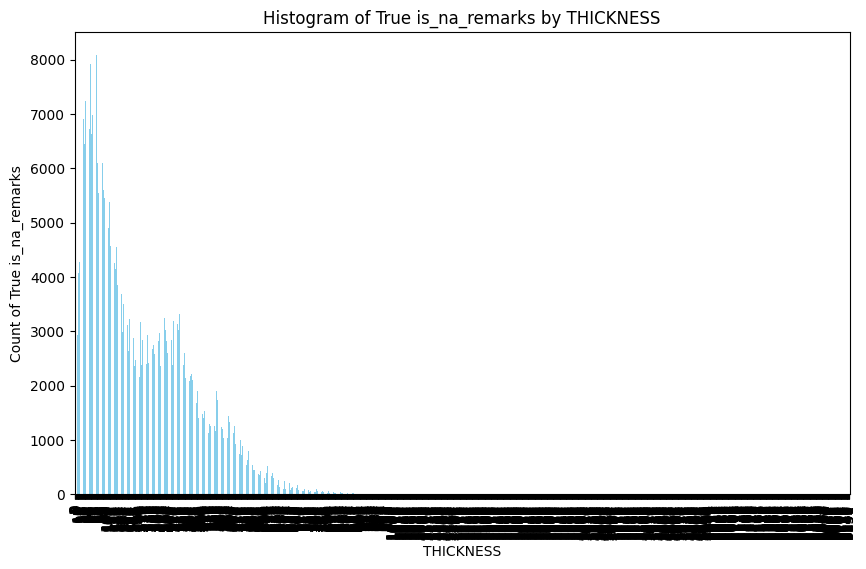

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

# Antagelse: glathida_rgis DataFrame er allerede defineret og indeholder kolonnen 'REMARKS' og 'THICKNESS'.

# Tilføj en ny kolonne for at indikere manglende værdier i 'REMARKS'
glathida_rgis['is_na_remarks'] = glathida_rgis['REMARKS'].isna()

# Beregn crosstab
crosstab1 = pd.crosstab(glathida_rgis['THICKNESS'], glathida_rgis['is_na_remarks'])
print(crosstab1)

# Ekstraher 'True' kolonnen
true_counts = crosstab1[True]

# Lav et histogram
plt.figure(figsize=(10, 6))
true_counts.plot(kind='bar', color='skyblue')
plt.xlabel('THICKNESS')
plt.ylabel('Count of True is_na_remarks')
plt.title('Histogram of True is_na_remarks by THICKNESS')
plt.show()


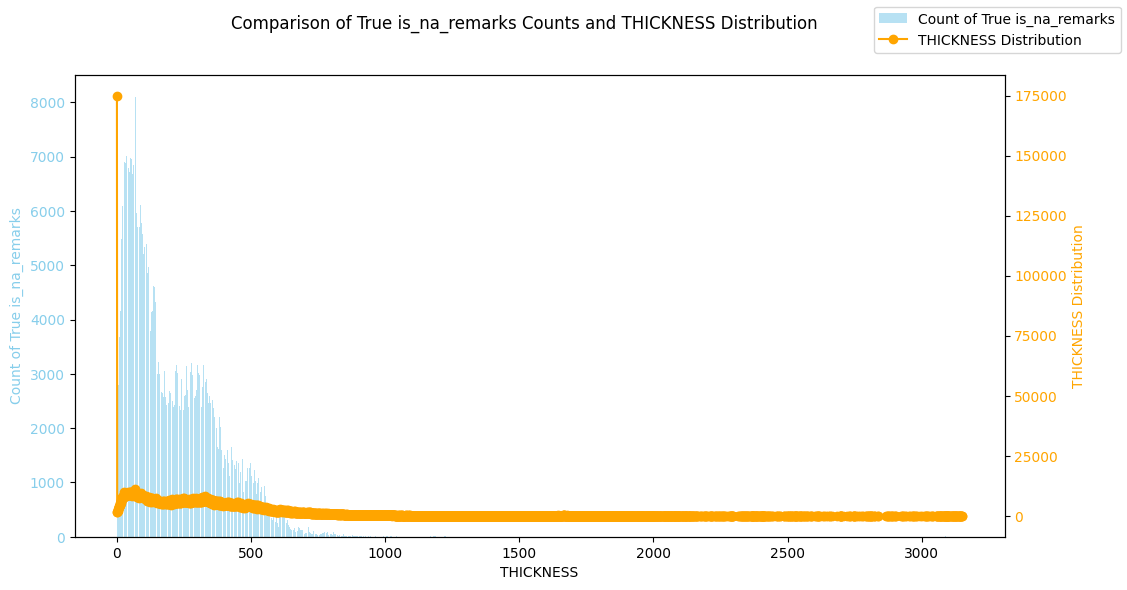

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

# Antagelse: glathida_rgis DataFrame er allerede defineret og indeholder kolonnerne 'REMARKS' og 'THICKNESS'.

# Tilføj en ny kolonne for at indikere manglende værdier i 'REMARKS'
glathida_rgis['is_na_remarks'] = glathida_rgis['REMARKS'].isna()

# Beregn crosstab
crosstab1 = pd.crosstab(glathida_rgis['THICKNESS'], glathida_rgis['is_na_remarks'])

# Ekstraher 'True' kolonnen
true_counts = crosstab1[True]

# Beregn fordelingen af 'THICKNESS'
thickness_distribution = glathida_rgis['THICKNESS'].value_counts().sort_index()

# Opret et nyt figur og en ny akse
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot histogram af True is_na_remarks counts
ax1.bar(true_counts.index, true_counts, color='skyblue', label='Count of True is_na_remarks', alpha=0.6)
ax1.set_xlabel('THICKNESS')
ax1.set_ylabel('Count of True is_na_remarks', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Opret en anden y-akse for thickness distribution
ax2 = ax1.twinx()
ax2.plot(thickness_distribution.index, thickness_distribution, color='orange', marker='o', label='THICKNESS Distribution')
ax2.set_ylabel('THICKNESS Distribution', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Tilføj en titel og vis plot
fig.suptitle('Comparison of True is_na_remarks Counts and THICKNESS Distribution')
fig.legend(loc='upper right')

plt.show()


In [269]:
# Lag en krysstabell mellom 'is_na_floor' og 'policy_ID'
crosstab1 = pd.crosstab(glathida_rgis_edited['is_na_glacier_name'], glathida_rgis_edited['is_na_remarks'])
print(crosstab1)

# Lag en krysstabell mellom 'is_na_floor' og 'policy_ID'
crosstab2 = pd.crosstab(glathida_rgis_edited['is_na_glacier_name'], glathida_rgis_edited['is_na_thickness'])
print(crosstab2)

# Lag en krysstabell mellom 'is_na_floor' og 'policy_ID'
crosstab4 = pd.crosstab(glathida_rgis_edited['is_na_glacier_name'], glathida_rgis_edited['is_na_elevation'])
print(crosstab4)

# Lag en krysstabell mellom 'is_na_floor' og 'policy_ID'
crosstab5 = pd.crosstab(glathida_rgis_edited['is_na_glacier_name'], glathida_rgis_edited['is_na_profile_id'])
print(crosstab5)

crosstab6 = pd.crosstab(glathida_rgis_edited['is_na_thickness'], glathida_rgis_edited['is_na_remarks'])
print(crosstab6)

is_na_remarks         False    True 
is_na_glacier_name                  
False                833630  1584288
True                1162741    98691
is_na_thickness       False    True 
is_na_glacier_name                  
False               1288076  1129842
True                 205829  1055603
is_na_elevation       False   True 
is_na_glacier_name                 
False               1940243  477675
True                1258137    3295
is_na_profile_id      False    True 
is_na_glacier_name                  
False                955304  1462614
True                1260844      588
is_na_remarks      False   True 
is_na_thickness                 
False             536813  957092
True             1459558  725887


In [203]:
# Lag en krysstabell mellom 'is_na_floor' og 'policy_ID'
crosstab1 = pd.crosstab(glathida_rgis_edited['is_na_slope'], glathida_rgis_edited['is_na_form'])
print(crosstab1)

# Lag en krysstabell mellom 'is_na_floor' og 'policy_ID'
crosstab2 = pd.crosstab(glathida_rgis_edited['is_na_slope'], glathida_rgis_edited['is_na_aspect'])
print(crosstab2)

# Lag en krysstabell mellom 'is_na_floor' og 'policy_ID'
crosstab3 = pd.crosstab(glathida_rgis_edited['is_na_form'], glathida_rgis_edited['is_na_aspect'])
print(crosstab3)

# Lag en krysstabell mellom 'is_na_floor' og 'policy_ID'
crosstab4 = pd.crosstab(glathida_rgis_edited['is_na_form'], glathida_rgis_edited['is_na_aspect'])
print(crosstab4)

is_na_form     False  True 
is_na_slope                
False        3662320      0
True               0  17030
is_na_aspect    False  True 
is_na_slope                 
False         3662320      0
True                0  17030
is_na_aspect    False  True 
is_na_form                  
False         3662320      0
True                0  17030
is_na_aspect    False  True 
is_na_form                  
False         3662320      0
True                0  17030


In [198]:
# Lag en krysstabell mellom 'is_na_floor' og 'policy_ID'
crosstab1 = pd.crosstab(glathida_rgis_edited['is_na_slope'], glathida_rgis_edited['is_na_remarks'])
print(crosstab1)

# Lag en krysstabell mellom 'is_na_floor' og 'policy_ID'
crosstab2 = pd.crosstab(glathida_rgis_edited['is_na_slope'], glathida_rgis_edited['is_na_thickness'])
print(crosstab2)

# Lag en krysstabell mellom 'is_na_floor' og 'policy_ID'
crosstab4 = pd.crosstab(glathida_rgis_edited['is_na_slope'], glathida_rgis_edited['is_na_elevation'])
print(crosstab4)

# Lag en krysstabell mellom 'is_na_floor' og 'policy_ID'
crosstab5 = pd.crosstab(glathida_rgis_edited['is_na_slope'], glathida_rgis_edited['is_na_profile_id'])
print(crosstab5)

# Lag en krysstabell mellom 'is_na_floor' og 'policy_ID'
crosstab6 = pd.crosstab(glathida_rgis_edited['is_na_dist_from_border_km_geom'], glathida_rgis_edited['is_na_glacier_name'])
print(crosstab6)

is_na_remarks    False    True 
is_na_slope                    
False          1996371  1665949
True                 0    17030
is_na_thickness    False    True 
is_na_slope                      
False            1489646  2172674
True                4259    12771
is_na_elevation    False   True 
is_na_slope                     
False            3182601  479719
True               15779    1251
is_na_profile_id    False    True 
is_na_slope                       
False             2216044  1446276
True                  104    16926
is_na_glacier_name                False    True 
is_na_dist_from_border_km_geom                  
False                           2400888  1261432
True                              17030        0


In [272]:
# Opret en krydstabel
crosstab_result = pd.crosstab(glathida_rgis_edited['REMARKS'], glathida_rgis_edited['is_na_thickness'])
crosstab_result = pd.crosstab(glathida_rgis_edited['is_na_remarks'], glathida_rgis_edited['THICK'])

# Udskriv krydstabellen
print(crosstab_result)

is_na_thickness     False    True 
REMARKS                           
High confidence    436405  1358950
Low confidence      15291    11497
Medium confidence   85117    89111


In [ ]:
# Opret en krydstabel
crosstab_result = pd.crosstab(glathida_rgis_edited['REMARKS'], glathida_rgis_edited['is_na_thickness'])
crosstab_result = pd.crosstab(glathida_rgis_edited['is_na_remarks'], glathida_rgis_edited['THICK'])

# Udskriv krydstabellen
print(crosstab_result)

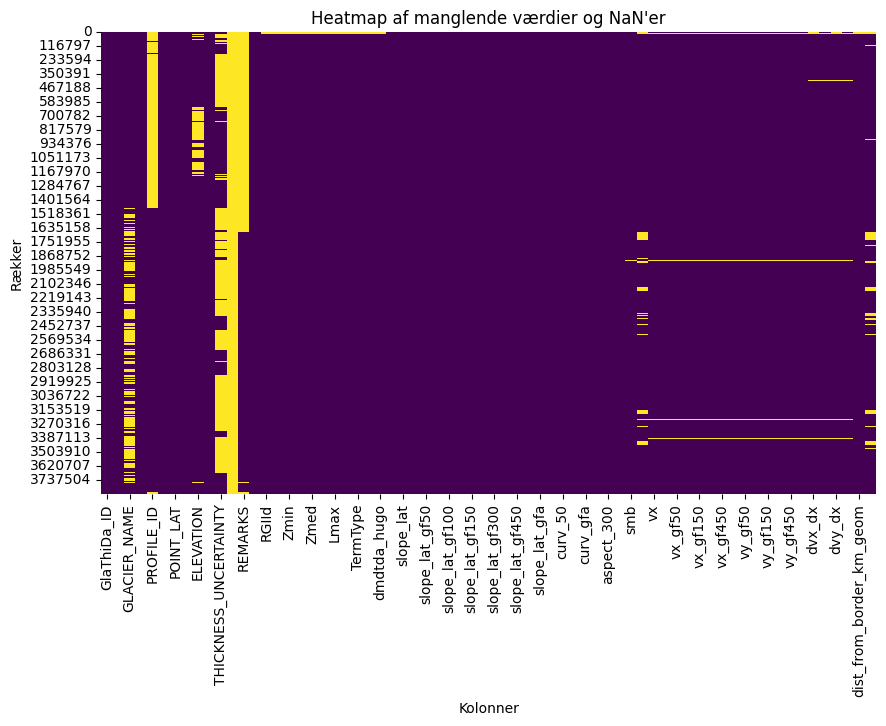

Korrelationskoefficienten mellem NA-værdier og NaN-værdier: nan


In [131]:
import seaborn as sns
#Lav en kopi af datasættet, hvor NaN-værdier er markeret som True og NA-værdier som False
na_nan_indicator = glathida_rgis.isna()

# Plot en heatmap af manglende værdier og NaN'er
plt.figure(figsize=(10, 6))
sns.heatmap(na_nan_indicator, cmap='viridis', cbar=False)
plt.title('Heatmap af manglende værdier og NaN\'er')
plt.xlabel('Kolonner')
plt.ylabel('Rækker')
plt.show()

# Beregn korrelationskoefficienten mellem NA-værdier og NaN-værdier
correlation = na_nan_indicator.sum(axis=1).corr(na_nan_indicator.sum(axis=0))

print(f"Korrelationskoefficienten mellem NA-værdier og NaN-værdier: {correlation}")

In [125]:
# Lag en krysstabell mellom 'is_na_floor' og 'policy_ID'
crosstab1 = pd.crosstab(glathida_rgis_edited['is_na_remarks'], glathida_rgis_edited['is_na_glacier_name'])
print(crosstab1)

# Lag en krysstabell mellom 'is_na_floor' og 'policy_ID'
crosstab2 = pd.crosstab(glathida_rgis_edited['is_na_remarks'], glathida_rgis_edited['is_na_thickness'])
print(crosstab2)

# Lag en krysstabell mellom 'is_na_floor' og 'policy_ID'
crosstab4 = pd.crosstab(glathida_rgis_edited['is_na_remarks'], glathida_rgis_edited['is_na_elevation'])
print(crosstab4)

# Lag en krysstabell mellom 'is_na_floor' og 'policy_ID'
crosstab5 = pd.crosstab(glathida_rgis_edited['is_na_remarks'], glathida_rgis_edited['is_na_profile_id'])
print(crosstab5)

is_na_glacier_name    False    True 
is_na_remarks                       
False                866563  1301673
True                1585659   100383
is_na_thickness   False    True 
is_na_remarks                   
False            565179  1603057
True             959407   726635
is_na_elevation    False   True 
is_na_remarks                   
False            2168236       0
True             1204597  481445
is_na_profile_id    False    True 
is_na_remarks                     
False             2168236        0
True               222269  1463773


In [31]:
# Lag en krysstabell mellom 'is_na_floor' og 'policy_ID'
crosstab1 = pd.crosstab(subset['is_na_profile_id'], subset['is_na_glacier_name'])
print(crosstab1)

# Lag en krysstabell mellom 'is_na_floor' og 'policy_ID'
crosstab2 = pd.crosstab(subset['is_na_profile_id'], subset['is_na_thickness'])
print(crosstab2)

# Lag en krysstabell mellom 'is_na_floor' og 'policy_ID'
crosstab3 = pd.crosstab(subset['is_na_profile_id'], subset['is_na_data_flag'])
print(crosstab3)

# Lag en krysstabell mellom 'is_na_floor' og 'policy_ID'
crosstab4 = pd.crosstab(subset['is_na_profile_id'], subset['is_na_elevation'])
print(crosstab4)

# Lag en krysstabell mellom 'is_na_floor' og 'policy_ID'
crosstab5 = pd.crosstab(subset['is_na_profile_id'], subset['is_na_remarks'])
print(crosstab5)

is_na_glacier_name    False    True 
is_na_profile_id                    
False                989037  1401468
True                1463186      588
is_na_thickness    False    True 
is_na_profile_id                 
False             596579  1793926
True              928008   535766
is_na_data_flag   False    True 
is_na_profile_id                
False                 0  2390505
True                  1  1463773
is_na_elevation     False   True 
is_na_profile_id                 
False             2387207    3298
True               985627  478147
is_na_remarks       False    True 
is_na_profile_id                  
False             2168236   222269
True                    0  1463774


In [32]:
# Lag en krysstabell mellom 'is_na_floor' og 'policy_ID'
crosstab1 = pd.crosstab(subset['is_na_glacier_name'], subset['is_na_profile_id'])
print(crosstab1)

# Lag en krysstabell mellom 'is_na_floor' og 'policy_ID'
crosstab2 = pd.crosstab(subset['is_na_glacier_name'], subset['is_na_thickness'])
print(crosstab2)

# Lag en krysstabell mellom 'is_na_floor' og 'policy_ID'
crosstab3 = pd.crosstab(subset['is_na_glacier_name'], subset['is_na_data_flag'])
print(crosstab3)

# Lag en krysstabell mellom 'is_na_floor' og 'policy_ID'
crosstab4 = pd.crosstab(subset['is_na_glacier_name'], subset['is_na_elevation'])
print(crosstab4)

# Lag en krysstabell mellom 'is_na_floor' og 'policy_ID'
crosstab5 = pd.crosstab(subset['is_na_glacier_name'], subset['is_na_remarks'])
print(crosstab5)

is_na_profile_id      False    True 
is_na_glacier_name                  
False                989037  1463186
True                1401468      588
is_na_thickness       False    True 
is_na_glacier_name                  
False               1297637  1154586
True                 226950  1175106
is_na_data_flag     False    True 
is_na_glacier_name                
False                   1  2452222
True                    0  1402056
is_na_elevation       False   True 
is_na_glacier_name                 
False               1974076  478147
True                1398758    3298
is_na_remarks         False    True 
is_na_glacier_name                  
False                866563  1585660
True                1301673   100383


In [33]:
# Lag en krysstabell mellom 'is_na_floor' og 'policy_ID'
crosstab1 = pd.crosstab(subset['is_na_thickness'], subset['is_na_profile_id'])
print(crosstab1)

# Lag en krysstabell mellom 'is_na_floor' og 'policy_ID'
crosstab2 = pd.crosstab(subset['is_na_thickness'], subset['is_na_glacier_name'])
print(crosstab2)

# Lag en krysstabell mellom 'is_na_floor' og 'policy_ID'
crosstab3 = pd.crosstab(subset['is_na_thickness'], subset['is_na_data_flag'])
print(crosstab3)

# Lag en krysstabell mellom 'is_na_floor' og 'policy_ID'
crosstab4 = pd.crosstab(subset['is_na_thickness'], subset['is_na_elevation'])
print(crosstab4)

# Lag en krysstabell mellom 'is_na_floor' og 'policy_ID'
crosstab5 = pd.crosstab(subset['is_na_thickness'], subset['is_na_remarks'])
print(crosstab5)

is_na_profile_id    False   True 
is_na_thickness                  
False              596579  928008
True              1793926  535766
is_na_glacier_name    False    True 
is_na_thickness                     
False               1297637   226950
True                1154586  1175106
is_na_data_flag  False    True 
is_na_thickness                
False                1  1524586
True                 0  2329692
is_na_elevation    False   True 
is_na_thickness                 
False            1053453  471134
True             2319381   10311
is_na_remarks      False   True 
is_na_thickness                 
False             565179  959408
True             1603057  726635


In [275]:
# Lag en krysstabell mellom 'is_na_floor' og 'policy_ID'
crosstab = pd.crosstab(glathida_rgis_edited['is_na_profile_id'], glathida_rgis_edited['GLACIER_NAME'])

print(crosstab)

GLACIER_NAME      A NEUVE GLACIER DE L'-N  A NEUVE GLACIER DE L'-S  \
is_na_profile_id                                                     
False                                   0                        0   
True                                  184                     1711   

GLACIER_NAME      AALFOTBREEN  AALFOTBREEN SOUTH  AASGARDFONNA NW  \
is_na_profile_id                                                    
False                       0                  0                0   
True                      639                426               83   

GLACIER_NAME      AAVATSMARKBREEN  ABBE  ABRAHAMSENBREEN  AGASSIZ GLACIER  \
is_na_profile_id                                                            
False                           0  1150                0             1669   
True                          150     0              174                0   

GLACIER_NAME      AHLMANNFONNA  AIR FORCE  AIRDROP  ALBRECHTBREEN  \
is_na_profile_id                                                

In [280]:
# Lag en krysstabell mellom 'is_na_floor' og 'policy_ID'
crosstab = pd.crosstab(glathida_rgis_edited['GLACIER_NAME'], glathida_rgis_edited['PROFILE_ID'])

print(crosstab)

PROFILE_ID             0     1  10   11   12  13   14   15   16  17   18  19  \
GLACIER_NAME                                                                   
ABBE                   0     0   0    0    0   0    0    0    0   0    0   0   
AGASSIZ GLACIER        0     0   0    0  593   0  141  493    0   0    0   0   
AIR FORCE              0   477   0    0    0   0    0    0    0   0    0   0   
AIRDROP                0  1715   0    0    0   0    0    0    0   0    0   0   
ALDEGONDABREEN         0   183  96   30  105  28  107   15  127  44  141  14   
...                   ..   ...  ..  ...  ...  ..  ...  ...  ...  ..  ...  ..   
YAHTSE GLACIER         0     0   0  838    0   0    0    0  187  61  714  68   
YALE GLACIER           0     0   0    0    0   0    0  179    0   0    0   0   
YELVERTON              0  5197   0    0    0   0    0    0    0   0    0   0   
YELVERTON INLET EAST   0     0   0    0    0   0    0    0    0   0    0   0   
YELVERTON INLET SOUTH  0  1642   0    0 

In [278]:
# Lag en krysstabell mellom 'is_na_floor' og 'policy_ID'
crosstab = pd.crosstab(glathida_rgis_edited['is_na_glacier_name'], glathida_rgis_edited['POLITICAL_UNIT'])

print(crosstab)

POLITICAL_UNIT          AQ    AT   BO      CA      CH    CL    CN   CO    DE  \
is_na_glacier_name                                                             
False               332642  3489  728  457437  465468  8460  6077  351  3497   
True                189807     0    0  676460       0     0     0    0     0   

POLITICAL_UNIT          GL    IT    KG    KZ    MN     NO   NZ    RU      SJ  \
is_na_glacier_name                                                             
False                58595  5812  1353  8568  7051  10798  618  2278  962855   
True                392403     0     0     0     0      0    0     0     588   

POLITICAL_UNIT       TZ     US  
is_na_glacier_name              
False               208  81633  
True                  0   2174  


In [279]:
# Lag en krysstabell mellom 'is_na_floor' og 'policy_ID'
crosstab = pd.crosstab(glathida_rgis_edited['is_na_profile_id'], glathida_rgis_edited['POLITICAL_UNIT'])

print(crosstab)

POLITICAL_UNIT        AQ    AT   BO       CA      CH    CL    CN   CO    DE  \
is_na_profile_id                                                              
False             521038     0    0  1127150      80     0  3394    0     0   
True                1411  3489  728     6747  465388  8460  2683  351  3497   

POLITICAL_UNIT        GL    IT    KG    KZ    MN     NO   NZ    RU      SJ  \
is_na_profile_id                                                             
False             440704     0     0     0  7051     79    0     0   33122   
True               10294  5812  1353  8568     0  10719  618  2278  930321   

POLITICAL_UNIT     TZ     US  
is_na_profile_id              
False               0  83530  
True              208    277  


In [293]:
glathida_rgis_edited['is_na_glathida_id'] = glathida_rgis_edited['GlaThiDa_ID'].isna()
glathida_rgis_edited['is_na_servey_date'] = glathida_rgis_edited['SURVEY_DATE'].isna()


# Lag en krysstabell mellom 'is_na_floor' og 'policy_ID'
crosstab = pd.crosstab(glathida_rgis_edited['is_na_servey_date'], glathida_rgis_edited['GlaThiDa_ID'])

print(crosstab)

GlaThiDa_ID        33    319   362   466   486   487   488   489   490   500   \
is_na_servey_date                                                               
False                62    19  5936  7051   448   277  2522   144   106  2394   
True                  0     0     0     0     0     0     0     0     0     0   

GlaThiDa_ID        501   502   554   1933  1934  1935  1936  1937  1938  1939  \
is_na_servey_date                                                               
False                 0    80     8    75    83    45   154    17   631   590   
True                 44     0     0     0     0     0     0     0     0     0   

GlaThiDa_ID        1940  1941  1942  1943  1944  1945  1946  1947  1948  1949  \
is_na_servey_date                                                               
False               491   494   891   830   641   315   431    42    31     5   
True                  0     0     0     0     0     0     0     0     0     0   

GlaThiDa_ID        1950  

In [305]:
pd.unique(glathida_rgis["SURVEY_DATE"])


array([19929999., 19760328., 20100216., 20090799., 20061107., 20100917.,
       20071003., 20071002., 20020599.,       nan, 20109999., 20070729.,
       20120510., 20100518., 20110505., 20090509., 19959999., 20130514.,
       20130608., 20130612., 20130513., 20130613., 20130611., 20009999.,
       20089999., 20059999., 19999999., 19989999., 20019999., 19969999.,
       20099999., 19979999., 20029999., 20069999., 20039999., 20079999.,
       20120807., 20140125., 20120809., 20110399., 20130399., 20090399.,
       20131003., 20120399., 20100399., 20150399., 20130827., 20130829.,
       20130830., 20131120., 20131006., 20050426., 20050427., 20060509.,
       20110316., 20110317., 20120908., 20080521., 20080313., 20110502.,
       20040401., 20040331., 20040421., 20040422., 20100507., 20100318.,
       19910628., 19920424., 19860520., 20120710., 20130707., 20110825.,
       20140406., 20140407., 20119999., 20121299., 20111014., 19710999.,
       20149999., 20060699., 20060899., 20139999., 

In [302]:
columns_of_interest = ['GlaThiDa_ID', 'SURVEY_DATE']

# Filtrer rækkerne, hvor værdien i 'column1' er 501
filtered_data = glathida_rgis[glathida_rgis['GlaThiDa_ID'] == 500]

# Vælg de to kolonner fra de filtrerede data
subset_data = filtered_data[columns_of_interest]

# Udskriv de første par rækker af de valgte kolonner for at kontrollere resultatet
print(subset_data.head())


       GlaThiDa_ID  SURVEY_DATE
16576          500   20020599.0
16577          500   20020599.0
16578          500   20020599.0
16579          500   20020599.0
16580          500   20020599.0


In [303]:
columns_of_interest = ['GlaThiDa_ID', 'SURVEY_DATE']

# Filtrer rækkerne, hvor værdien i 'column1' er 501
filtered_data = glathida_rgis[glathida_rgis['GlaThiDa_ID'] == 502]

# Vælg de to kolonner fra de filtrerede data
subset_data = filtered_data[columns_of_interest]

# Udskriv de første par rækker af de valgte kolonner for at kontrollere resultatet
print(subset_data.head())


       GlaThiDa_ID  SURVEY_DATE
19014          502   20109999.0
19015          502   20109999.0
19016          502   20109999.0
19017          502   20109999.0
19018          502   20109999.0


In [25]:
# Lag en krysstabell mellom 'is_na_floor' og 'policy_ID'
crosstab = pd.crosstab(subset['is_na_remarks'], subset['is_na_data_flag'])

print(crosstab)

is_na_data_flag  False    True 
is_na_remarks                  
False                0  2168236
True                 1  1686042


# Final glathida_rgis - dataset

In [3]:
path_O1_shp = '/Users/emma/OGGM/rgi/RGIV62/00_rgi62_regions/00_rgi62_O1Regions.shp' # shp file of regional boundaries

# Import 20-bin gridded training dataset
metadata_file = "//Users/emma/aml/GroupProject/metadata19-001.csv"
glathida_rgis = pd.read_csv(metadata_file, low_memory=False)

In [84]:
# Fjern rækkerne hvor 'DATA_FLAG' er lig med 1
glathida_rgis_edited = glathida_rgis[glathida_rgis['DATA_FLAG'] != 1]

# Fjern kolonnen "DATA_FLAG"
glathida_rgis_edited.drop("DATA_FLAG", axis=1, inplace=True)

/var/folders/1g/49w0mvjs0nd8ss7lr_13tgd40000gn/T/ipykernel_1704/1933956972.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  glathida_rgis_edited.drop("DATA_FLAG", axis=1, inplace=True)


In [85]:
glathida_rgis_edited = glathida_rgis_edited.drop(['GLACIER_NAME', 'PROFILE_ID', 'SURVEY_DATE', 'ELEVATION'], axis=1)

In [86]:
glathida_rgis_edited = glathida_rgis_edited.drop(['THICKNESS_UNCERTAINTY'], axis=1)

In [87]:
# Opret et subset, hvor 'THICKNESS' er forskellig fra 0
glathida_rgis_edited = glathida_rgis_edited[glathida_rgis_edited['THICKNESS'] != 0]

In [88]:
# Opret et subset, hvor rækker med NaN-værdier i kolonnen 'slope' fjernes
glathida_rgis_edited = glathida_rgis_edited.dropna(subset=['Slope'])
glathida_rgis_edited = glathida_rgis_edited.dropna(subset=['vx'])
glathida_rgis_edited = glathida_rgis_edited.dropna(subset=['dvx_dx'])
glathida_rgis_edited = glathida_rgis_edited.dropna(subset=['dvx_dy'])
glathida_rgis_edited = glathida_rgis_edited.dropna(subset=['smb'])

In [232]:
# Udskriv de første par rækker for at kontrollere resultatet
print(glathida_rgis_edited.head())

# Alternativt kan du tjekke om der er NaN værdier i slope kolonnen i det nye subset
print(f"Antal NaN-værdier i 'slope' efter fjernelse: {glathida_rgis_edited['Slope'].isna().sum()}")


   GlaThiDa_ID POLITICAL_UNIT POINT_ID  POINT_LAT   POINT_LON  THICKNESS  \
1           33             US        2  48.764904 -121.821909         29   
2           33             US        3  48.761662 -121.825264         41   
3           33             US        4  48.757063 -121.829107         71   
4           33             US        5  48.753715 -121.832006         82   
5           33             US        6  48.748593 -121.834030         71   

        REMARKS  RGI           RGIId   Area  ...   vy_gf100   vy_gf150  \
1  none/unknown  2.0  RGI60-02.17739  2.888  ... -45.575442 -45.269147   
2  none/unknown  2.0  RGI60-02.17739  2.888  ... -51.563536 -51.880542   
3  none/unknown  2.0  RGI60-02.17739  2.888  ... -58.870843 -55.473354   
4  none/unknown  2.0  RGI60-02.17739  2.888  ... -58.497089 -54.701241   
5  none/unknown  2.0  RGI60-02.17739  2.888  ... -47.331150 -45.871352   

    vy_gf300   vy_gf450     vy_gfa    dvx_dx    dvx_dy    dvy_dx    dvy_dy  \
1 -45.335444 -44.753

In [9]:
pd.unique(glathida_rgis['REMARKS'])

array([nan, 'High confidence', 'Low confidence', 'Medium confidence'],
      dtype=object)

In [209]:
pd.unique(glathida_rgis_edited['REMARKS'])

array(['none/unknown', 'High confidence', 'Low confidence',
       'Medium confidence'], dtype=object)

In [212]:
len(pd.unique(glathida_rgis['RGIId']))

2771

In [89]:
#Udskifter alle nan i REMARKS til none/unknown"
glathida_rgis_edited['REMARKS'].fillna('none/unknown', inplace=True)

In [92]:
import re

# Antag at "glathida_rgis.csv" er dit datasæt
# Læs datasættet ind i en pandas DataFrame

def count_na_and_nan(dataframe):
    counts = {}
    for column in dataframe.columns:
        # Konverter kolonneværdier til strenge, hvis de ikke allerede er strenge
        column_values_as_strings = dataframe[column].astype(str)
        
        # Saml alle værdier fra kolonnen til én lang streng
        column_text = " ".join(column_values_as_strings)
        
        # Find forekomster af 'na' og 'nan' i kolonnen
        na_matches = re.findall(r'\bna\b', column_text)
        nan_matches = re.findall(r'\bnan\b', column_text)
        
        # Tæl forekomsterne
        na_count = len(na_matches)
        nan_count = len(nan_matches)
        
        # Gem tællingerne for denne kolonne i dictionaryen
        counts[column] = {'na_count': na_count, 'nan_count': nan_count}
        
    return counts

# Kald funktionen og gem resultatet
counts = count_na_and_nan(glathida_rgis_edited)

# Udskriv resultaterne
for column, count_dict in counts.items():
    print(f"Column '{column}':")
    print(f"Occurrences of 'na': {count_dict['na_count']}")
    print(f"Occurrences of 'nan': {count_dict['nan_count']}")
    print()

Column 'GlaThiDa_ID':
Occurrences of 'na': 0
Occurrences of 'nan': 0

Column 'POLITICAL_UNIT':
Occurrences of 'na': 0
Occurrences of 'nan': 0

Column 'POINT_ID':
Occurrences of 'na': 0
Occurrences of 'nan': 0

Column 'POINT_LAT':
Occurrences of 'na': 0
Occurrences of 'nan': 0

Column 'POINT_LON':
Occurrences of 'na': 0
Occurrences of 'nan': 0

Column 'THICKNESS':
Occurrences of 'na': 0
Occurrences of 'nan': 0

Column 'REMARKS':
Occurrences of 'na': 0
Occurrences of 'nan': 0

Column 'RGI':
Occurrences of 'na': 0
Occurrences of 'nan': 0

Column 'RGIId':
Occurrences of 'na': 0
Occurrences of 'nan': 0

Column 'Area':
Occurrences of 'na': 0
Occurrences of 'nan': 0

Column 'Zmin':
Occurrences of 'na': 0
Occurrences of 'nan': 0

Column 'Zmax':
Occurrences of 'na': 0
Occurrences of 'nan': 0

Column 'Zmed':
Occurrences of 'na': 0
Occurrences of 'nan': 0

Column 'Slope':
Occurrences of 'na': 0
Occurrences of 'nan': 0

Column 'Lmax':
Occurrences of 'na': 0
Occurrences of 'nan': 0

Column 'Form':


In [90]:
# Beregn 'slope_total' for hver række
glathida_rgis_edited['slope_total'] = np.sqrt(glathida_rgis_edited['slope_lat']**2 + glathida_rgis_edited['slope_lon']**2)

glathida_rgis_edited['slope_total_gfa'] = np.sqrt(glathida_rgis_edited['slope_lat_gfa']**2 + glathida_rgis_edited['slope_lon_gfa']**2)

# Gem det opdaterede datasæt tilbage til en ny CSV-fil
#df.to_csv('glathida_rgis_edited_with_slope_total.csv', index=False)

#print("Beregningen af 'slope_total' er fuldført, og resultatet er gemt i 'glathida_rgis_edited_with_slope_total.csv'")

In [91]:
glathida_rgis_edited = glathida_rgis_edited.drop(['slope_lat_gf50', 'slope_lon_gf50', 'slope_lat_gf100', 'slope_lon_gf100',
                                                  'slope_lat_gf150', 'slope_lon_gf150','slope_lat_gf300', 'slope_lon_gf300',
                                                 'slope_lat_gf450', 'slope_lon_gf450',
                                                 'curv_50', 'curv_300',
                                                 'aspect_50', 'aspect_300',
                                                 'vx_gf50', 'vx_gf100', 'vx_gf150', 'vx_gf300',  'vx_gf450',
                                                 'vy_gf50', 'vy_gf100', 'vy_gf150', 'vy_gf300', 'vy_gf450',
                                                 ], axis=1)

In [210]:
# Opret et subset af de rækker, hvor 'RGIId' mangler værdier
subset_missing_RGIId = glathida_rgis_edited[glathida_rgis_edited['vx'].isna()]

# Se de første rækker i subsettet
print(subset_missing_RGIId)


Empty DataFrame
Columns: [GlaThiDa_ID, POLITICAL_UNIT, POINT_ID, POINT_LAT, POINT_LON, THICKNESS, REMARKS, RGI, RGIId, Area, Zmin, Zmax, Zmed, Slope, Lmax, Form, TermType, Aspect, dmdtda_hugo, elevation, slope_lat, slope_lon, slope_lat_gfa, slope_lon_gfa, curv_gfa, aspect_gfa, smb, vx, vy, vx_gfa, vy_gfa, dvx_dx, dvx_dy, dvy_dx, dvy_dy, dist_from_border_km_geom, slope_total, slope_total_gfa]
Index: []

[0 rows x 38 columns]


# Impact encoding

In [14]:
for col in glathida_rgis_edited.columns:
    print(f"{col}: {glathida_rgis_edited[col].dtype}")

GlaThiDa_ID: int64
POLITICAL_UNIT: object
POINT_ID: object
POINT_LAT: float64
POINT_LON: float64
THICKNESS: int64
REMARKS: object
RGI: float64
RGIId: object
Area: float64
Zmin: float64
Zmax: float64
Zmed: float64
Slope: float64
Lmax: float64
Form: float64
TermType: float64
Aspect: float64
dmdtda_hugo: float64
elevation: float64
slope_lat: float64
slope_lon: float64
slope_lat_gfa: float64
slope_lon_gfa: float64
curv_gfa: float64
aspect_gfa: float64
smb: float64
ith_m: float64
vx: float64
vy: float64
vx_gfa: float64
vy_gfa: float64
dvx_dx: float64
dvx_dy: float64
dvy_dx: float64
dvy_dy: float64
dist_from_border_km_geom: float64
ith_f: float64
slope_total: float64
slope_total_gfa: float64


In [93]:
# Beregn gennemsnitlig huspris for hver by
impact_encoding1 = glathida_rgis_edited.groupby('POINT_ID')['THICKNESS'].mean().to_dict()

# Erstat byerne med de beregnede gennemsnitsværdier
glathida_rgis_edited['PPOINT_ID_encoded'] = glathida_rgis_edited['POINT_ID'].map(impact_encoding1)


# Beregn gennemsnitlig huspris for hver by
impact_encoding2 = glathida_rgis_edited.groupby('POLITICAL_UNIT')['THICKNESS'].mean().to_dict()

# Erstat byerne med de beregnede gennemsnitsværdier
glathida_rgis_edited['POLITICAL_UNIT_encoded'] = glathida_rgis_edited['POLITICAL_UNIT'].map(impact_encoding2)



# Beregn gennemsnitlig huspris for hver by
impact_encoding3 = glathida_rgis_edited.groupby('REMARKS')['THICKNESS'].mean().to_dict()

# Erstat byerne med de beregnede gennemsnitsværdier
glathida_rgis_edited['REMARKS_encoded'] = glathida_rgis_edited['REMARKS'].map(impact_encoding3)



print(glathida_rgis_edited)

         GlaThiDa_ID POLITICAL_UNIT POINT_ID  POINT_LAT   POINT_LON  \
1                 33             US        2  48.764904 -121.821909   
2                 33             US        3  48.761662 -121.825264   
3                 33             US        4  48.757063 -121.829107   
4                 33             US        5  48.753715 -121.832006   
5                 33             US        6  48.748593 -121.834030   
...              ...            ...      ...        ...         ...   
3854274         6630             AT       27  47.092690   12.380504   
3854275         6630             AT       28  47.093780   12.379642   
3854276         6630             AT       29  47.094839   12.378200   
3854277         6630             AT       30  47.094829   12.378174   
3854278         6631             AT        1  47.094853   12.374525   

         THICKNESS       REMARKS   RGI           RGIId   Area  ...    dvx_dy  \
1               29  none/unknown   2.0  RGI60-02.17739  2.888  ... 

In [7]:
# Antag at din data er gemt i en DataFrame kaldet 'data' med kolonnenavne 'feature_1', 'feature_2', ..., 'feature_n' og 'target_variable'

# Beregn korrelationskoefficienter mellem alle funktioner og målvariabelen
correlations = glathida_rgis.corr()['THICKNESS'].abs().sort_values(ascending=False)

# Vælg de 30 mest korrelerede funktioner (ekskluderer målvariabelen selv)
top_correlated_features = correlations.drop('THICKNESS').head(30)

# Udskriv de 30 mest korrelerede funktioner og deres korrelationskoefficienter
for feature, correlation in top_correlated_features.items():
    print(f"{feature}: {correlation}")

ValueError: could not convert string to float: 'US'

# Merging data

## RGI10

In [66]:
path_O1_shp = '/Users/emma/OGGM/rgi/RGIV62/00_rgi62_regions/00_rgi62_O1Regions.shp' # shp file of regional boundaries

# Import 20-bin gridded training dataset
glacier_data_RGI10 = "//Users/emma/aml/GroupProject/glacier_data_RGI10.csv"
glacier_data_RGI10 = pd.read_csv(glacier_data_RGI10, low_memory=False)

In [40]:
glacier_data_RGI10

,glacierID,x_scale,y_scale,Form
0,RGI60-10.00001,0.096041,0.022069,"0 1\nName: Form, dtype: int64"
1,RGI60-10.00002,0.335588,0.077344,"1 1\nName: Form, dtype: int64"
2,RGI60-10.00003,0.040479,0.009350,"2 0\nName: Form, dtype: int64"
3,RGI60-10.00004,0.065006,0.014993,"3 0\nName: Form, dtype: int64"
4,RGI60-10.00005,0.094661,0.021785,"4 0\nName: Form, dtype: int64"
...,...,...,...,...
5146,RGI60-10.05147,0.008108,0.003034,"5146 0\nName: Form, dtype: int64"
5147,RGI60-10.05148,0.007552,0.003516,"5147 0\nName: Form, dtype: int64"
5148,RGI60-10.05149,0.007108,0.003907,"5148 0\nName: Form, dtype: int64"
5149,RGI60-10.05150,0.007867,0.001515,"5149 0\nName: Form, dtype: int64"


In [125]:
# Opret en liste med de ønskede værdier
desired_values10 = [f'RGI60-10.{i:05d}' for i in range(1, 5152)]

# Filtrer datasættet
subset_df10 = glathida_rgis_edited[glathida_rgis_edited['RGIId'].isin(desired_values10)]

In [42]:
subset_df10

,GlaThiDa_ID,POLITICAL_UNIT,POINT_ID,POINT_LAT,POINT_LON,THICKNESS,REMARKS,RGI,RGIId,Area,...,dvx_dx,dvx_dy,dvy_dx,dvy_dy,dist_from_border_km_geom,slope_total,slope_total_gfa,PPOINT_ID_encoded,POLITICAL_UNIT_encoded,REMARKS_encoded
6019,466,MN,1,48.655678,90.846654,69,none/unknown,10.0,RGI60-10.02656,0.589,...,0.021017,-0.006180,-0.007410,0.002120,0.271984,0.040063,0.071244,73.000000,67.690682,210.293341
6020,466,MN,2,48.655677,90.846657,69,none/unknown,10.0,RGI60-10.02656,0.589,...,0.021017,-0.006180,-0.007410,0.002120,0.272034,0.040437,0.070909,96.828358,67.690682,210.293341
6021,466,MN,3,48.655677,90.846659,69,none/unknown,10.0,RGI60-10.02656,0.589,...,0.021017,-0.006180,-0.007410,0.002120,0.272078,0.040856,0.070545,106.981818,67.690682,210.293341
6022,466,MN,4,48.655676,90.846662,69,none/unknown,10.0,RGI60-10.02656,0.589,...,0.021017,-0.006180,-0.007410,0.002120,0.272128,0.041230,0.070210,116.647887,67.690682,210.293341
6023,466,MN,5,48.655676,90.846665,69,none/unknown,10.0,RGI60-10.02656,0.589,...,0.021017,-0.006180,-0.007410,0.002120,0.272178,0.041605,0.069876,121.934932,67.690682,210.293341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72005,2085,CN,671,47.061906,85.562316,87,none/unknown,10.0,RGI60-10.00604,3.055,...,-0.001331,-0.003253,0.014726,0.012576,0.124738,0.153638,0.132377,210.126437,72.625983,210.293341
72006,2085,CN,672,47.061905,85.562386,88,none/unknown,10.0,RGI60-10.00604,3.055,...,-0.001331,-0.003253,0.014726,0.012576,0.119776,0.156392,0.132675,210.597701,72.625983,210.293341
72007,2085,CN,673,47.061899,85.562504,89,none/unknown,10.0,RGI60-10.00604,3.055,...,-0.001331,-0.003253,0.014726,0.012576,0.111625,0.162122,0.133174,212.890173,72.625983,210.293341
72008,2085,CN,674,47.061894,85.562622,89,none/unknown,10.0,RGI60-10.00604,3.055,...,-0.001331,-0.003253,0.014726,0.012576,0.103616,0.168070,0.133711,213.000000,72.625983,210.293341


In [126]:
glacier_data_RGI10 = glacier_data_RGI10.rename(columns={'glacierID': 'RGIId'})

In [131]:
common_values10 = glacier_data_RGI10['RGIId'].unique()
filtered_df10 = glathida_rgis_edited[glathida_rgis_edited['RGIId'].isin(common_values10)]

In [132]:
#filtered_df10_latent = latent_space_data[latent_space_data['RGIId'].isin(common_values10)]

In [133]:
merged_df10 = pd.merge(glacier_data_RGI10, filtered_df10, on='RGIId', how='inner')

In [134]:
merged_df10

,RGIId,x_scale,y_scale,Form_x,GlaThiDa_ID,POLITICAL_UNIT,POINT_ID,POINT_LAT,POINT_LON,THICKNESS,...,dvx_dy,dvy_dx,dvy_dy,dist_from_border_km_geom,ith_f,slope_total,slope_total_gfa,PPOINT_ID_encoded,POLITICAL_UNIT_encoded,REMARKS_encoded
0,RGI60-10.00604,0.036968,0.032412,"603 0\nName: Form, dtype: int64",2085,CN,27,47.078186,85.568962,18,...,0.004067,0.010171,-0.011887,0.032109,20.763323,0.276006,0.092644,151.110738,72.625983,210.293341
1,RGI60-10.00604,0.036968,0.032412,"603 0\nName: Form, dtype: int64",2085,CN,28,47.078151,85.568952,18,...,0.004067,0.010171,-0.011887,0.034145,20.763323,0.275245,0.093041,150.587248,72.625983,210.293341
2,RGI60-10.00604,0.036968,0.032412,"603 0\nName: Form, dtype: int64",2085,CN,29,47.078116,85.568942,18,...,0.004067,0.010171,-0.011887,0.036508,20.763323,0.274561,0.093439,151.918367,72.625983,210.293341
3,RGI60-10.00604,0.036968,0.032412,"603 0\nName: Form, dtype: int64",2085,CN,30,47.078080,85.568932,19,...,0.004067,0.010171,-0.011887,0.039138,24.413246,0.275669,0.093831,150.533784,72.625983,210.293341
4,RGI60-10.00604,0.036968,0.032412,"603 0\nName: Form, dtype: int64",2085,CN,31,47.078045,85.568922,19,...,0.004067,0.010171,-0.011887,0.041983,24.413246,0.276719,0.094224,147.786207,72.625983,210.293341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7695,RGI60-10.02659,0.028452,0.032552,"2658 0\nName: Form, dtype: int64",466,MN,172,48.656010,90.847387,69,...,-0.007448,-0.008580,0.001624,0.333410,33.699905,0.118664,0.123483,190.929825,67.690682,210.293341
7696,RGI60-10.02659,0.028452,0.032552,"2658 0\nName: Form, dtype: int64",466,MN,173,48.656007,90.847385,69,...,-0.007448,-0.008580,0.001624,0.333082,33.699905,0.118403,0.122772,192.920354,67.690682,210.293341
7697,RGI60-10.02659,0.028452,0.032552,"2658 0\nName: Form, dtype: int64",466,MN,174,48.656004,90.847383,69,...,-0.007448,-0.008580,0.001624,0.332750,NaN,0.118142,0.122030,194.524444,67.690682,210.293341
7698,RGI60-10.02659,0.028452,0.032552,"2658 0\nName: Form, dtype: int64",466,MN,175,48.656002,90.847381,69,...,-0.007448,-0.008580,0.001624,0.332418,NaN,0.117881,0.121287,195.597345,67.690682,210.293341


## RGI 11

In [110]:
path_O1_shp = '/Users/emma/OGGM/rgi/RGIV62/00_rgi62_regions/00_rgi62_O1Regions.shp' # shp file of regional boundaries

# Import 20-bin gridded training dataset
glacier_data_RGI11 = "//Users/emma/aml/GroupProject/glacier_data_RGI11.csv"
glacier_data_RGI11 = pd.read_csv(glacier_data_RGI11, low_memory=False)

In [111]:
glacier_data_RGI11

,glacierID,x_scale,y_scale,Form
0,RGI60-11.00001,0.006988,0.003449,"0 0\nName: Form, dtype: int64"
1,RGI60-11.00002,0.027480,0.020961,"1 0\nName: Form, dtype: int64"
2,RGI60-11.00003,0.012070,0.015165,"2 0\nName: Form, dtype: int64"
3,RGI60-11.00004,0.005162,0.002473,"3 0\nName: Form, dtype: int64"
4,RGI60-11.00005,0.004573,0.004996,"4 0\nName: Form, dtype: int64"
...,...,...,...,...
3922,RGI60-11.03923,0.003531,0.002060,"3922 0\nName: Form, dtype: int64"
3923,RGI60-11.03924,0.005022,0.002011,"3923 0\nName: Form, dtype: int64"
3924,RGI60-11.03925,0.003304,0.001123,"3924 0\nName: Form, dtype: int64"
3925,RGI60-11.03926,0.001686,0.001972,"3925 0\nName: Form, dtype: int64"


In [135]:
# Opret en liste med de ønskede værdier
desired_values11 = [f'RGI60-11.{i:05d}' for i in range(1, 3928)]

# Filtrer datasættet
subset_df11 = glathida_rgis_edited[glathida_rgis_edited['RGIId'].isin(desired_values11)]

In [51]:
subset_df11

,GlaThiDa_ID,POLITICAL_UNIT,POINT_ID,POINT_LAT,POINT_LON,THICKNESS,REMARKS,RGI,RGIId,Area,...,dvx_dx,dvx_dy,dvy_dx,dvy_dy,dist_from_border_km_geom,slope_total,slope_total_gfa,PPOINT_ID_encoded,POLITICAL_UNIT_encoded,REMARKS_encoded
190,362,CH,108,46.961079,9.389321,9,none/unknown,11.0,RGI60-11.00638,0.082,...,-0.001769,0.000740,-0.000228,-0.001434,0.007452,0.379067,0.234250,167.769547,85.772713,210.293341
191,362,CH,109,46.961081,9.389314,9,none/unknown,11.0,RGI60-11.00638,0.082,...,-0.001769,0.000740,-0.000228,-0.001434,0.007246,0.380786,0.234148,167.542857,85.772713,210.293341
192,362,CH,110,46.961084,9.389306,10,none/unknown,11.0,RGI60-11.00638,0.082,...,-0.001769,0.000740,-0.000228,-0.001434,0.007090,0.382517,0.234048,169.258197,85.772713,210.293341
193,362,CH,111,46.961086,9.389299,10,none/unknown,11.0,RGI60-11.00638,0.082,...,-0.001769,0.000740,-0.000228,-0.001434,0.006984,0.384229,0.233949,172.632653,85.772713,210.293341
194,362,CH,112,46.961088,9.389291,10,none/unknown,11.0,RGI60-11.00638,0.082,...,-0.001769,0.000740,-0.000228,-0.001434,0.006928,0.385987,0.233847,174.861224,85.772713,210.293341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3854274,6630,AT,27,47.092690,12.380504,36,none/unknown,11.0,RGI60-11.00190,2.939,...,0.000657,-0.003058,-0.014911,-0.011977,0.111143,0.187885,0.087836,151.110738,76.818241,210.293341
3854275,6630,AT,28,47.093780,12.379642,26,none/unknown,11.0,RGI60-11.00190,2.939,...,0.002024,-0.001552,-0.018537,-0.009445,0.122934,0.168411,0.082205,150.587248,76.818241,210.293341
3854276,6630,AT,29,47.094839,12.378200,39,none/unknown,11.0,RGI60-11.00190,2.939,...,0.001730,-0.001263,-0.018579,-0.002504,0.257347,0.166339,0.076741,151.918367,76.818241,210.293341
3854277,6630,AT,30,47.094829,12.378174,39,none/unknown,11.0,RGI60-11.00190,2.939,...,0.001730,-0.001263,-0.018579,-0.002504,0.258708,0.165654,0.076530,150.533784,76.818241,210.293341


In [136]:
glacier_data_RGI11 = glacier_data_RGI11.rename(columns={'glacierID': 'RGIId'})

In [137]:
common_values11 = glacier_data_RGI11['RGIId'].unique()
filtered_df11 = glathida_rgis_edited[glathida_rgis_edited['RGIId'].isin(common_values11)]

In [138]:
merged_df11 = pd.merge(glacier_data_RGI11, filtered_df11, on='RGIId', how='inner')

In [116]:
merged_df11

,RGIId,x_scale,y_scale,Form_x,GlaThiDa_ID,POLITICAL_UNIT,POINT_ID,POINT_LAT,POINT_LON,THICKNESS,...,dvx_dy,dvy_dx,dvy_dy,dist_from_border_km_geom,ith_f,slope_total,slope_total_gfa,PPOINT_ID_encoded,POLITICAL_UNIT_encoded,REMARKS_encoded
0,RGI60-11.00014,0.017490,0.012304,"13 0\nName: Form, dtype: int64",1991,AT,1,47.191485,12.680077,70,...,-0.001082,-0.000530,-0.002414,0.155646,54.635605,0.143746,0.140464,73.000000,76.818241,210.293341
1,RGI60-11.00014,0.017490,0.012304,"13 0\nName: Form, dtype: int64",1991,AT,2,47.191919,12.680613,58,...,-0.000680,-0.000889,-0.002479,0.114566,45.569813,0.167250,0.173135,96.828358,76.818241,210.293341
2,RGI60-11.00014,0.017490,0.012304,"13 0\nName: Form, dtype: int64",1991,AT,3,47.192840,12.681103,69,...,0.000029,-0.000711,-0.002501,0.055060,39.857216,0.213319,0.211745,106.981818,76.818241,210.293341
3,RGI60-11.00014,0.017490,0.012304,"13 0\nName: Form, dtype: int64",1991,AT,4,47.193830,12.681249,75,...,0.000548,-0.000470,-0.002265,0.050117,39.619652,0.214695,0.251009,116.647887,76.818241,210.293341
4,RGI60-11.00014,0.017490,0.012304,"13 0\nName: Form, dtype: int64",1991,AT,5,47.194343,12.681295,66,...,0.000725,-0.000346,-0.002051,0.067784,47.750858,0.249982,0.272817,121.934932,76.818241,210.293341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462086,RGI60-11.03249,0.010637,0.006152,"3248 0\nName: Form, dtype: int64",488,DE,2352,47.426700,10.996850,16,...,-0.001123,-0.000169,0.002847,0.049086,18.716337,0.378875,0.305249,234.373016,25.598110,210.293341
462087,RGI60-11.03249,0.010637,0.006152,"3248 0\nName: Form, dtype: int64",488,DE,2353,47.426700,10.996860,16,...,-0.001123,-0.000169,0.002847,0.048332,18.716337,0.379515,0.305483,233.785714,25.598110,210.293341
462088,RGI60-11.03249,0.010637,0.006152,"3248 0\nName: Form, dtype: int64",488,DE,2354,47.426700,10.996870,16,...,-0.001123,-0.000169,0.002847,0.047578,18.716337,0.380163,0.305718,233.571429,25.598110,210.293341
462089,RGI60-11.03249,0.010637,0.006152,"3248 0\nName: Form, dtype: int64",488,DE,2355,47.426700,10.996880,16,...,-0.001123,-0.000169,0.002847,0.046824,18.716337,0.377729,0.305909,233.277778,25.598110,210.293341


## RGI 12

In [139]:
path_O1_shp = '/Users/emma/OGGM/rgi/RGIV62/00_rgi62_regions/00_rgi62_O1Regions.shp' # shp file of regional boundaries

# Import 20-bin gridded training dataset
glacier_data_RGI12 = "//Users/emma/aml/GroupProject/glacier_data_RGI12.csv"
glacier_data_RGI12 = pd.read_csv(glacier_data_RGI12, low_memory=False)
glacier_data_RGI12

,glacierID,x_scale,y_scale,Form
0,RGI60-12.00001,0.010362,0.003223,"0 0\nName: Form, dtype: int64"
1,RGI60-12.00002,0.003905,0.002673,"1 0\nName: Form, dtype: int64"
2,RGI60-12.00003,0.009339,0.002541,"2 0\nName: Form, dtype: int64"
3,RGI60-12.00004,0.047828,0.048389,"3 0\nName: Form, dtype: int64"
4,RGI60-12.00005,0.002926,0.002596,"4 0\nName: Form, dtype: int64"
...,...,...,...,...
1883,RGI60-12.01884,0.006588,0.011090,"1883 0\nName: Form, dtype: int64"
1884,RGI60-12.01885,0.003559,0.004847,"1884 0\nName: Form, dtype: int64"
1885,RGI60-12.01886,0.005091,0.002165,"1885 0\nName: Form, dtype: int64"
1886,RGI60-12.01887,0.002014,0.004179,"1886 0\nName: Form, dtype: int64"


In [314]:
# Vis datatyperne for hver kolonne
print(glacier_data_RGI12.dtypes)

RGIId       object
x_scale    float64
y_scale    float64
Form        object
dtype: object


In [140]:
# Opret en liste med de ønskede værdier
desired_values12 = [f'RGI60-12.{i:05d}' for i in range(1, 1889)]

# Filtrer datasættet
subset_df12 = glathida_rgis_edited[glathida_rgis_edited['RGIId'].isin(desired_values12)]

In [141]:
glacier_data_RGI12 = glacier_data_RGI12.rename(columns={'glacierID': 'RGIId'})

In [142]:
common_values12 = glacier_data_RGI12['RGIId'].unique()
filtered_df12 = glathida_rgis_edited[glathida_rgis_edited['RGIId'].isin(common_values12)]

In [143]:
merged_df12 = pd.merge(glacier_data_RGI12, filtered_df12, on='RGIId', how='inner')
merged_df12

,RGIId,x_scale,y_scale,Form_x,GlaThiDa_ID,POLITICAL_UNIT,POINT_ID,POINT_LAT,POINT_LON,THICKNESS,...,dvx_dy,dvy_dx,dvy_dy,dist_from_border_km_geom,ith_f,slope_total,slope_total_gfa,PPOINT_ID_encoded,POLITICAL_UNIT_encoded,REMARKS_encoded
0,RGI60-12.00960,0.037741,0.028281,"959 0\nName: Form, dtype: int64",2074,RU,1,43.363174,41.426742,11,...,0.000132,0.000414,0.011355,0.029638,44.233719,0.170089,0.169390,73.000000,93.973786,210.293341
1,RGI60-12.00960,0.037741,0.028281,"959 0\nName: Form, dtype: int64",2074,RU,2,43.363127,41.426662,12,...,0.000132,0.000414,0.011355,0.037894,44.233719,0.133623,0.170662,96.828358,93.973786,210.293341
2,RGI60-12.00960,0.037741,0.028281,"959 0\nName: Form, dtype: int64",2074,RU,3,43.363058,41.426537,13,...,0.000578,0.000704,0.011074,0.050500,44.233719,0.094862,0.172530,106.981818,93.973786,210.293341
3,RGI60-12.00960,0.037741,0.028281,"959 0\nName: Form, dtype: int64",2074,RU,4,43.363001,41.426397,21,...,0.000578,0.000704,0.011074,0.063181,58.513680,0.061626,0.174118,116.647887,93.973786,210.293341
4,RGI60-12.00960,0.037741,0.028281,"959 0\nName: Form, dtype: int64",2074,RU,5,43.362942,41.426259,31,...,0.000441,0.000180,0.011246,0.075980,66.372299,0.047635,0.175694,121.934932,93.973786,210.293341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2055,RGI60-12.01132,0.033672,0.018876,"1131 0\nName: Form, dtype: int64",2073,RU,662,43.192220,42.758183,53,...,-0.003287,0.019977,-0.012977,0.258862,73.506821,0.238408,0.372992,207.936782,93.973786,210.293341
2056,RGI60-12.01132,0.033672,0.018876,"1131 0\nName: Form, dtype: int64",2073,RU,663,43.191896,42.757600,58,...,-0.003015,0.018476,-0.017685,0.201146,64.928947,0.323160,0.382505,208.568966,93.973786,210.293341
2057,RGI60-12.01132,0.033672,0.018876,"1131 0\nName: Form, dtype: int64",2073,RU,664,43.193094,42.760463,75,...,-0.001563,0.013434,-0.002329,0.405055,83.272125,0.142712,0.352775,210.383721,93.973786,210.293341
2058,RGI60-12.01132,0.033672,0.018876,"1131 0\nName: Form, dtype: int64",2073,RU,665,43.193192,42.760430,74,...,-0.001563,0.013434,-0.002329,0.394868,82.067055,0.149132,0.352702,213.366279,93.973786,210.293341


## RGI 13

In [144]:
path_O1_shp = '/Users/emma/OGGM/rgi/RGIV62/00_rgi62_regions/00_rgi62_O1Regions.shp' # shp file of regional boundaries

# Import 20-bin gridded training dataset
glacier_data_RGI13 = "//Users/emma/aml/GroupProject/glacier_data_RGI13.csv"
glacier_data_RGI13 = pd.read_csv(glacier_data_RGI13, low_memory=False)
glacier_data_RGI13

,glacierID,x_scale,y_scale,Form
0,RGI60-13.00001,0.011298,0.009870,"0 0\nName: Form, dtype: int64"
1,RGI60-13.00002,0.011959,0.011195,"1 0\nName: Form, dtype: int64"
2,RGI60-13.00003,0.004043,0.003538,"2 0\nName: Form, dtype: int64"
3,RGI60-13.00004,0.009616,0.007447,"3 0\nName: Form, dtype: int64"
4,RGI60-13.00005,0.011431,0.004856,"4 0\nName: Form, dtype: int64"
...,...,...,...,...
54424,RGI60-13.54427,0.012257,0.015380,"54424 0\nName: Form, dtype: int64"
54425,RGI60-13.54428,0.084487,0.051403,"54425 1\nName: Form, dtype: int64"
54426,RGI60-13.54429,0.038277,0.040505,"54426 1\nName: Form, dtype: int64"
54427,RGI60-13.54430,0.010123,0.009342,"54427 0\nName: Form, dtype: int64"


In [145]:
# Vis datatyperne for hver kolonne
print(glacier_data_RGI13.dtypes)

glacierID     object
x_scale      float64
y_scale      float64
Form          object
dtype: object


In [146]:
# Opret en liste med de ønskede værdier
desired_values13 = [f'RGI60-13.{i:05d}' for i in range(1, 54430)]

# Filtrer datasættet
subset_df13 = glathida_rgis_edited[glathida_rgis_edited['RGIId'].isin(desired_values13)]

In [147]:
glacier_data_RGI13 = glacier_data_RGI13.rename(columns={'glacierID': 'RGIId'})

In [148]:
common_values13 = glacier_data_RGI13['RGIId'].unique()
filtered_df13 = glathida_rgis_edited[glathida_rgis_edited['RGIId'].isin(common_values13)]

In [149]:
merged_df13 = pd.merge(glacier_data_RGI13, filtered_df13, on='RGIId', how='inner')
merged_df13

,RGIId,x_scale,y_scale,Form_x,GlaThiDa_ID,POLITICAL_UNIT,POINT_ID,POINT_LAT,POINT_LON,THICKNESS,...,dvx_dy,dvy_dx,dvy_dy,dist_from_border_km_geom,ith_f,slope_total,slope_total_gfa,PPOINT_ID_encoded,POLITICAL_UNIT_encoded,REMARKS_encoded
0,RGI60-13.08055,0.037696,0.025083,"8054 0\nName: Form, dtype: int64",2090,KG,1,41.837984,78.167434,5,...,0.000075,-0.001213,0.002964,0.107768,54.717445,0.210322,0.142766,73.000000,75.469327,210.293341
1,RGI60-13.08055,0.037696,0.025083,"8054 0\nName: Form, dtype: int64",2090,KG,2,41.838002,78.167544,7,...,0.000308,-0.001135,0.002717,0.117112,54.717445,0.230901,0.142913,96.828358,75.469327,210.293341
2,RGI60-13.08055,0.037696,0.025083,"8054 0\nName: Form, dtype: int64",2090,KG,3,41.837990,78.167662,8,...,0.000308,-0.001135,0.002717,0.126354,61.036217,0.251508,0.143336,106.981818,75.469327,210.293341
3,RGI60-13.08055,0.037696,0.025083,"8054 0\nName: Form, dtype: int64",2090,KG,4,41.837958,78.167792,9,...,0.000308,-0.001135,0.002717,0.136230,61.036217,0.275679,0.144001,116.647887,75.469327,210.293341
4,RGI60-13.08055,0.037696,0.025083,"8054 0\nName: Form, dtype: int64",2090,KG,5,41.837878,78.167703,8,...,0.000308,-0.001135,0.002717,0.127578,59.454281,0.251843,0.143965,121.934932,75.469327,210.293341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14751,RGI60-13.48211,0.064596,0.052329,"48208 0\nName: Form, dtype: int64",2098,CN,116,43.780423,88.360401,64,...,0.002868,0.044240,-0.004230,0.142358,117.933609,0.081758,0.190726,174.404082,72.625983,210.293341
14752,RGI60-13.48211,0.064596,0.052329,"48208 0\nName: Form, dtype: int64",2098,CN,117,43.780447,88.360463,64,...,0.002868,0.044240,-0.004230,0.140577,117.933609,0.084601,0.191219,175.158537,72.625983,210.293341
14753,RGI60-13.48211,0.064596,0.052329,"48208 0\nName: Form, dtype: int64",2098,CN,118,43.780470,88.360526,65,...,0.002868,0.044240,-0.004230,0.137642,117.933609,0.086283,0.191732,176.910204,72.625983,210.293341
14754,RGI60-13.48211,0.064596,0.052329,"48208 0\nName: Form, dtype: int64",2098,CN,119,43.780493,88.360588,66,...,0.002868,0.044240,-0.004230,0.132891,117.933609,0.086270,0.192258,174.592742,72.625983,210.293341


## VAE Latent space data (62 dimensions)

In [98]:
# Import 20-bin gridded training dataset
train_latent_spaceVAE = "//Users/emma/aml/GroupProject/train_latent_spaceVAE.csv"
train_latent_spaceVAE = pd.read_csv(train_latent_spaceVAE, low_memory=False)
train_latent_spaceVAE

,dim_0,dim_4,dim_5,dim_6,dim_7,dim_8,dim_14,dim_15,dim_17,dim_19,...,dim_48,dim_49,dim_50,dim_52,dim_53,dim_56,dim_57,dim_58,dim_62,glacier_id
0,7.057218,1.431852,3.891468,5.939963,3.848292,4.245533,3.496121,2.908044,3.905016,5.986001,...,4.086359,3.640073,2.627548,4.955227,2.579748,5.456909,2.806566,6.249611,4.296433,RGI60-13.08113
1,2.054904,3.998877,3.733449,2.243484,3.061925,4.109873,3.438133,3.047537,3.157310,6.153512,...,1.143958,2.672538,2.624557,2.888416,3.018104,2.408928,3.408076,4.203407,4.763620,RGI60-14.07260
2,4.320813,4.238578,5.675359,2.437909,3.890653,3.022959,2.810403,5.159424,4.549469,1.346313,...,4.952331,3.435053,2.779804,5.351997,4.360592,2.839239,5.053117,3.675377,5.070474,RGI60-15.03417
3,1.200291,3.217154,0.512264,2.132018,1.316017,2.228689,1.716778,2.158812,2.013379,4.656211,...,2.348778,1.723868,1.317538,2.794215,2.736055,1.587666,1.692839,2.062549,2.603836,RGI60-13.40184
4,5.024569,3.713303,3.551567,4.231558,1.575132,1.888484,2.414784,2.917795,1.341822,4.834334,...,1.565299,1.752440,1.908005,2.960933,4.834354,0.896842,0.883815,1.126194,2.329030,RGI60-13.46106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85196,10.591645,4.275536,8.013568,5.938020,3.326221,7.899154,4.802895,2.396500,5.978033,2.638557,...,4.194193,4.083074,2.423622,2.451478,3.201459,2.689440,1.100102,4.456081,5.599795,RGI60-13.43923
85197,3.538217,3.309118,3.610904,0.619173,2.630666,5.357815,2.013611,2.051917,5.155657,1.749249,...,2.590963,2.659610,1.424239,4.833672,2.570540,1.901573,3.889285,3.966950,1.868049,RGI60-14.11426
85198,3.872025,2.926802,1.432865,4.027003,1.735141,1.314713,1.327546,3.502858,2.805111,3.824865,...,1.900323,2.231024,1.378243,3.808111,5.453499,1.426602,1.806974,2.009690,2.765734,RGI60-15.10312
85199,1.804117,3.942524,4.519712,5.514128,3.220725,4.786039,1.517075,5.107156,3.777979,6.500532,...,4.674374,4.650310,3.359787,4.797767,4.637308,3.887716,3.997822,4.485341,6.969100,RGI60-10.00861


In [69]:
 train_latent_space.describe()

,dim_0,dim_4,dim_5,dim_6,dim_7,dim_8,dim_14,dim_15,dim_17,dim_19,...,dim_47,dim_48,dim_49,dim_50,dim_52,dim_53,dim_56,dim_57,dim_58,dim_62
count,85201.000000,85201.000000,85201.000000,85201.000000,85201.000000,85201.000000,85201.000000,85201.000000,85201.000000,85201.000000,...,85201.000000,85201.000000,85201.000000,85201.000000,85201.000000,85201.000000,85201.000000,85201.000000,85201.000000,85201.000000
mean,3.653539,3.535541,3.268775,4.088621,3.004386,3.866073,2.602262,2.941336,3.191039,4.477316,...,4.174393,3.631755,2.721274,1.881027,3.464944,3.489306,2.427021,2.400819,3.518229,3.425168
std,2.118340,1.108840,1.560156,1.428212,1.474784,1.635898,1.019876,1.109170,1.486821,1.365025,...,1.659841,1.797274,1.013115,0.860425,1.417884,1.235165,1.010568,1.151653,1.858323,1.478685
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.068877,2.748202,2.101713,3.122306,1.908326,2.632344,1.862783,2.128971,2.091055,3.522051,...,3.023137,2.314874,1.988366,1.266896,2.426884,2.622022,1.684223,1.520221,2.149406,2.386069
50%,3.194188,3.516901,3.062904,4.013916,2.781646,3.644671,2.494791,2.855313,2.987856,4.509315,...,4.012110,3.368886,2.628717,1.726913,3.304601,3.466051,2.308385,2.240210,3.123119,3.191650
75%,4.790391,4.281341,4.220225,5.002523,3.848643,4.883866,3.232249,3.678671,4.068718,5.434970,...,5.138011,4.625722,3.362787,2.365214,4.344296,4.308383,3.056415,3.112926,4.527398,4.236532
max,13.975074,8.976122,10.447460,10.602795,13.113276,11.004802,7.933149,8.219883,11.974521,10.746164,...,13.356627,14.342502,7.593230,6.616277,10.423487,8.761251,7.660125,8.007143,15.685998,13.133798


In [99]:
# Import 20-bin gridded training dataset
val_latent_spaceVAE = "//Users/emma/aml/GroupProject/val_latent_spaceVAE.csv"
val_latent_spaceVAE = pd.read_csv(val_latent_spaceVAE, low_memory=False)
val_latent_spaceVAE

,dim_0,dim_4,dim_5,dim_6,dim_7,dim_8,dim_14,dim_15,dim_17,dim_19,...,dim_48,dim_49,dim_50,dim_52,dim_53,dim_56,dim_57,dim_58,dim_62,glacier_id
0,1.972166,2.054317,3.354242,3.168623,3.173516,4.053118,3.800038,2.574299,2.043603,5.888317,...,2.611484,3.249211,2.461752,4.254127,2.905594,1.538601,1.369579,4.018319,3.093880,RGI60-11.01500
1,0.961606,3.818109,0.893366,3.418348,0.478476,2.597914,1.372050,1.160582,1.866401,6.103612,...,2.574607,1.820723,1.280575,1.894972,2.327797,1.160853,1.447370,3.929453,3.692741,RGI60-13.45466
2,3.974532,4.103106,3.308171,5.978312,5.436889,5.854115,2.066969,2.552904,4.481566,3.813560,...,3.756010,2.840284,1.072035,1.928450,1.393639,3.720272,2.433963,7.954086,1.270697,RGI60-13.01729
3,4.968947,4.353270,3.934469,5.584966,4.660845,7.064654,1.000693,3.892808,5.572967,2.381292,...,3.817621,4.307034,0.819498,1.804382,2.484620,2.724256,2.611512,6.201613,1.975065,RGI60-15.10311
4,1.878797,4.134299,2.837437,2.802848,2.212799,3.690596,2.203094,1.456278,2.014778,6.075370,...,3.347236,2.298282,1.186867,1.035763,0.961385,1.932581,1.093295,4.433304,2.418772,RGI60-14.15498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21296,1.240396,1.951818,0.968539,4.680586,4.979091,2.731600,2.537568,3.138694,4.258407,7.484147,...,8.580028,2.819796,3.008859,3.561397,2.657503,2.085273,3.127196,4.134013,5.645282,RGI60-13.33873
21297,5.388828,2.983462,5.325524,4.489457,3.277719,4.122251,4.650819,3.488638,3.525383,5.142209,...,5.970043,4.366776,2.459677,3.022965,1.671161,2.643580,1.806342,2.462039,3.482160,RGI60-14.16036
21298,1.155836,4.162182,1.816978,3.483498,2.521465,6.076107,1.613989,1.919858,3.203820,4.140696,...,1.988906,2.540948,1.199239,1.805660,1.197139,2.678261,1.981383,5.789892,1.420489,RGI60-14.18046
21299,2.891915,2.685803,2.880703,1.921103,0.765728,2.838489,1.937000,4.051368,2.917549,2.517800,...,3.522333,2.205709,1.861369,5.080141,3.962260,1.026779,3.006220,1.112886,1.927938,RGI60-13.04727


In [100]:
# Sammensæt datasættene
latent_space_data = pd.concat([train_latent_spaceVAE, val_latent_spaceVAE], axis=0)

In [72]:
# Gem det nye datasæt
latent_space_data.to_csv('latent_space_data.csv', index=False)

In [73]:
latent_space_data

,dim_0,dim_4,dim_5,dim_6,dim_7,dim_8,dim_14,dim_15,dim_17,dim_19,...,dim_48,dim_49,dim_50,dim_52,dim_53,dim_56,dim_57,dim_58,dim_62,glacier_id
0,7.057218,1.431852,3.891468,5.939963,3.848292,4.245533,3.496121,2.908044,3.905016,5.986001,...,4.086359,3.640073,2.627548,4.955227,2.579748,5.456909,2.806566,6.249611,4.296433,RGI60-13.08113
1,2.054904,3.998877,3.733449,2.243484,3.061925,4.109873,3.438133,3.047537,3.157310,6.153512,...,1.143958,2.672538,2.624557,2.888416,3.018104,2.408928,3.408076,4.203407,4.763620,RGI60-14.07260
2,4.320813,4.238578,5.675359,2.437909,3.890653,3.022959,2.810403,5.159424,4.549469,1.346313,...,4.952331,3.435053,2.779804,5.351997,4.360592,2.839239,5.053117,3.675377,5.070474,RGI60-15.03417
3,1.200291,3.217154,0.512264,2.132018,1.316017,2.228689,1.716778,2.158812,2.013379,4.656211,...,2.348778,1.723868,1.317538,2.794215,2.736055,1.587666,1.692839,2.062549,2.603836,RGI60-13.40184
4,5.024569,3.713303,3.551567,4.231558,1.575132,1.888484,2.414784,2.917795,1.341822,4.834334,...,1.565299,1.752440,1.908005,2.960933,4.834354,0.896842,0.883815,1.126194,2.329030,RGI60-13.46106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21296,1.240396,1.951818,0.968539,4.680586,4.979091,2.731600,2.537568,3.138694,4.258407,7.484147,...,8.580028,2.819796,3.008859,3.561397,2.657503,2.085273,3.127196,4.134013,5.645282,RGI60-13.33873
21297,5.388828,2.983462,5.325524,4.489457,3.277719,4.122251,4.650819,3.488638,3.525383,5.142209,...,5.970043,4.366776,2.459677,3.022965,1.671161,2.643580,1.806342,2.462039,3.482160,RGI60-14.16036
21298,1.155836,4.162182,1.816978,3.483498,2.521465,6.076107,1.613989,1.919858,3.203820,4.140696,...,1.988906,2.540948,1.199239,1.805660,1.197139,2.678261,1.981383,5.789892,1.420489,RGI60-14.18046
21299,2.891915,2.685803,2.880703,1.921103,0.765728,2.838489,1.937000,4.051368,2.917549,2.517800,...,3.522333,2.205709,1.861369,5.080141,3.962260,1.026779,3.006220,1.112886,1.927938,RGI60-13.04727


In [181]:
latent_space_dataVAE = latent_space_dataVAE.rename(columns={'glacier_id': 'RGIId'})

## RGI 16

In [150]:
path_O1_shp = '/Users/emma/OGGM/rgi/RGIV62/00_rgi62_regions/00_rgi62_O1Regions.shp' # shp file of regional boundaries

# Import 20-bin gridded training dataset
glacier_data_RGI16 = "/Users/emma/aml/AML autoencoder data/glacier_data_RGI16.csv"
glacier_data_RGI16 = pd.read_csv(glacier_data_RGI16, low_memory=False)

In [214]:
glacier_data_RGI16

,glacierID,x_scale,y_scale,Form
0,RGI60-16.00001,0.004065,0.003751,"0 0\nName: Form, dtype: int64"
1,RGI60-16.00002,0.009262,0.003396,"1 0\nName: Form, dtype: int64"
2,RGI60-16.00003,0.008694,0.003106,"2 0\nName: Form, dtype: int64"
3,RGI60-16.00004,0.002928,0.002793,"3 0\nName: Form, dtype: int64"
4,RGI60-16.00005,0.004466,0.002435,"4 0\nName: Form, dtype: int64"
...,...,...,...,...
2934,RGI60-16.02941,0.004138,0.005645,"2934 0\nName: Form, dtype: int64"
2935,RGI60-16.02942,0.015519,0.020610,"2935 0\nName: Form, dtype: int64"
2936,RGI60-16.02943,0.005551,0.008256,"2936 0\nName: Form, dtype: int64"
2937,RGI60-16.02944,0.028535,0.048624,"2937 0\nName: Form, dtype: int64"


In [151]:
# Opret en liste med de ønskede værdier
desired_values16 = [f'RGI60-16.{i:05d}' for i in range(1, 2940)]

# Filtrer datasættet
subset_df16 = glathida_rgis_edited[glathida_rgis_edited['RGIId'].isin(desired_values16)]

In [217]:
subset_df16

,GlaThiDa_ID,POLITICAL_UNIT,POINT_ID,POINT_LAT,POINT_LON,THICKNESS,REMARKS,RGI,RGIId,Area,...,dvx_dx,dvx_dy,dvy_dx,dvy_dy,dist_from_border_km_geom,slope_total,slope_total_gfa,PPOINT_ID_encoded,POLITICAL_UNIT_encoded,REMARKS_encoded
28375,2093,BO,1,-16.302555,-68.110067,5,none/unknown,16.0,RGI60-16.00532,0.649,...,-0.003329,-0.001225,-0.014086,0.003490,0.121178,0.244545,0.287373,71.954167,24.857143,209.987336
28376,2093,BO,2,-16.302538,-68.110023,6,none/unknown,16.0,RGI60-16.00532,0.649,...,-0.003329,-0.001225,-0.014086,0.003490,0.122704,0.259864,0.288236,82.462745,24.857143,209.987336
28377,2093,BO,3,-16.302548,-68.109892,11,none/unknown,16.0,RGI60-16.00532,0.649,...,-0.003329,-0.001225,-0.014086,0.003490,0.133001,0.277192,0.290645,85.599222,24.857143,209.987336
28378,2093,BO,4,-16.302562,-68.109827,12,none/unknown,16.0,RGI60-16.00532,0.649,...,-0.003329,-0.001225,-0.014086,0.003490,0.139043,0.282553,0.291853,86.984733,24.857143,209.987336
28379,2093,BO,5,-16.302570,-68.109752,13,none/unknown,16.0,RGI60-16.00532,0.649,...,-0.003184,-0.001533,-0.011741,0.003572,0.145533,0.291740,0.293194,89.498127,24.857143,209.987336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29449,2012,BO,1032,-16.279378,-68.138416,48,none/unknown,16.0,RGI60-16.00543,2.339,...,-0.002346,0.004517,0.009146,0.001824,0.169710,0.193401,0.263022,189.304000,24.857143,209.987336
29450,2012,BO,1033,-16.279441,-68.138434,48,none/unknown,16.0,RGI60-16.00543,2.339,...,-0.002346,0.004517,0.009146,0.001824,0.176173,0.198374,0.262121,190.919355,24.857143,209.987336
29451,2012,BO,1034,-16.279550,-68.138471,49,none/unknown,16.0,RGI60-16.00543,2.339,...,-0.001860,0.005259,0.008226,0.002045,0.186206,0.205324,0.260536,190.152000,24.857143,209.987336
29452,2012,BO,1035,-16.279658,-68.138508,45,none/unknown,16.0,RGI60-16.00543,2.339,...,-0.001429,0.005777,0.008792,0.001049,0.196243,0.194211,0.259103,191.169355,24.857143,209.987336


In [152]:
glacier_data_RGI16 = glacier_data_RGI16.rename(columns={'glacierID': 'RGIId'})

In [153]:
common_values16 = glacier_data_RGI16['RGIId'].unique()
filtered_df16 = glathida_rgis_edited[glathida_rgis_edited['RGIId'].isin(common_values16)]

In [154]:
filtered_df16_latent = latent_space_data[latent_space_data['RGIId'].isin(common_values16)]

In [155]:
merged_df16 = pd.merge(glacier_data_RGI16, filtered_df16, on='RGIId', how='inner')

In [224]:
merged_df16

,RGIId,x_scale,y_scale,Form_x,GlaThiDa_ID,POLITICAL_UNIT,POINT_ID,POINT_LAT,POINT_LON,THICKNESS,...,dvx_dx,dvx_dy,dvy_dx,dvy_dy,dist_from_border_km_geom,slope_total,slope_total_gfa,PPOINT_ID_encoded,POLITICAL_UNIT_encoded,REMARKS_encoded
0,RGI60-16.00531,0.013191,0.011426,"530 0\nName: Form, dtype: int64",2093,BO,694,-16.301575,-68.102948,7,...,0.004859,-0.002225,-0.000066,-0.001861,0.177734,0.321955,0.101804,150.654676,24.857143,209.987336
1,RGI60-16.00531,0.013191,0.011426,"530 0\nName: Form, dtype: int64",2093,BO,695,-16.301535,-68.102865,7,...,0.004859,-0.002225,-0.000066,-0.001861,0.170329,0.310345,0.100435,150.683453,24.857143,209.987336
2,RGI60-16.00532,0.013502,0.009242,"531 0\nName: Form, dtype: int64",2093,BO,1,-16.302555,-68.110067,5,...,-0.003329,-0.001225,-0.014086,0.003490,0.121178,0.244545,0.287373,71.954167,24.857143,209.987336
3,RGI60-16.00532,0.013502,0.009242,"531 0\nName: Form, dtype: int64",2093,BO,2,-16.302538,-68.110023,6,...,-0.003329,-0.001225,-0.014086,0.003490,0.122704,0.259864,0.288236,82.462745,24.857143,209.987336
4,RGI60-16.00532,0.013502,0.009242,"531 0\nName: Form, dtype: int64",2093,BO,3,-16.302548,-68.109892,11,...,-0.003329,-0.001225,-0.014086,0.003490,0.133001,0.277192,0.290645,85.599222,24.857143,209.987336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,RGI60-16.00543,0.022727,0.024010,"542 0\nName: Form, dtype: int64",2012,BO,1032,-16.279378,-68.138416,48,...,-0.002346,0.004517,0.009146,0.001824,0.169710,0.193401,0.263022,189.304000,24.857143,209.987336
724,RGI60-16.00543,0.022727,0.024010,"542 0\nName: Form, dtype: int64",2012,BO,1033,-16.279441,-68.138434,48,...,-0.002346,0.004517,0.009146,0.001824,0.176173,0.198374,0.262121,190.919355,24.857143,209.987336
725,RGI60-16.00543,0.022727,0.024010,"542 0\nName: Form, dtype: int64",2012,BO,1034,-16.279550,-68.138471,49,...,-0.001860,0.005259,0.008226,0.002045,0.186206,0.205324,0.260536,190.152000,24.857143,209.987336
726,RGI60-16.00543,0.022727,0.024010,"542 0\nName: Form, dtype: int64",2012,BO,1035,-16.279658,-68.138508,45,...,-0.001429,0.005777,0.008792,0.001049,0.196243,0.194211,0.259103,191.169355,24.857143,209.987336


## RGI 17

In [156]:
path_O1_shp = '/Users/emma/OGGM/rgi/RGIV62/00_rgi62_regions/00_rgi62_O1Regions.shp' # shp file of regional boundaries

# Import 20-bin gridded training dataset
glacier_data_RGI17 = "/Users/emma/aml/AML autoencoder data/glacier_data_RGI17.csv"
glacier_data_RGI17 = pd.read_csv(glacier_data_RGI17, low_memory=False)

In [118]:
glacier_data_RGI17

,glacierID,x_scale,y_scale,Form
0,RGI60-17.00001,0.009598,0.017473,"0 0\nName: Form, dtype: int64"
1,RGI60-17.00002,0.003648,0.005356,"1 0\nName: Form, dtype: int64"
2,RGI60-17.00003,0.002526,0.001794,"2 0\nName: Form, dtype: int64"
3,RGI60-17.00004,0.008236,0.004800,"3 0\nName: Form, dtype: int64"
4,RGI60-17.00005,0.003255,0.003887,"4 0\nName: Form, dtype: int64"
...,...,...,...,...
15903,RGI60-17.15904,0.179190,0.057574,"15903 0\nName: Form, dtype: int64"
15904,RGI60-17.15905,0.086031,0.056067,"15904 0\nName: Form, dtype: int64"
15905,RGI60-17.15906,0.021395,0.016929,"15905 0\nName: Form, dtype: int64"
15906,RGI60-17.15907,0.026004,0.014058,"15906 0\nName: Form, dtype: int64"


In [157]:
# Opret en liste med de ønskede værdier
desired_values17 = [f'RGI60-17.{i:05d}' for i in range(1, 15909)]

# Filtrer datasættet
subset_df17 = glathida_rgis_edited[glathida_rgis_edited['RGIId'].isin(desired_values17)]

In [228]:
subset_df17

,GlaThiDa_ID,POLITICAL_UNIT,POINT_ID,POINT_LAT,POINT_LON,THICKNESS,REMARKS,RGI,RGIId,Area,...,dvx_dx,dvx_dy,dvy_dx,dvy_dy,dist_from_border_km_geom,slope_total,slope_total_gfa,PPOINT_ID_encoded,POLITICAL_UNIT_encoded,REMARKS_encoded
34499,2029,CL,1,-30.142830,-69.932494,5,none/unknown,17.0,RGI60-17.14647,1.189,...,-0.002156,0.002455,-0.003181,-0.009856,0.021638,0.182241,0.175562,71.954167,78.975483,209.987336
34500,2029,CL,2,-30.142648,-69.932430,10,none/unknown,17.0,RGI60-17.14647,1.189,...,-0.002156,0.002455,-0.003181,-0.009856,0.036970,0.218284,0.167508,82.462745,78.975483,209.987336
34501,2029,CL,3,-30.142479,-69.932359,13,none/unknown,17.0,RGI60-17.14647,1.189,...,-0.002450,0.002431,-0.004052,-0.011291,0.054797,0.197481,0.159789,85.599222,78.975483,209.987336
34502,2029,CL,4,-30.142333,-69.932277,14,none/unknown,17.0,RGI60-17.14647,1.189,...,-0.002450,0.002431,-0.004052,-0.011291,0.071220,0.188232,0.153160,86.984733,78.975483,209.987336
34503,2029,CL,5,-30.142216,-69.932199,16,none/unknown,17.0,RGI60-17.14647,1.189,...,-0.002450,0.002431,-0.004052,-0.011291,0.081471,0.166146,0.147875,89.498127,78.975483,209.987336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41886,2033,CL,1527,-33.740322,-69.957363,27,none/unknown,17.0,RGI60-17.13672,12.580,...,-0.005104,-0.008119,-0.004331,-0.000340,0.044929,0.295757,0.252339,203.634783,78.975483,209.987336
41887,2033,CL,1528,-33.740363,-69.957459,27,none/unknown,17.0,RGI60-17.13672,12.580,...,-0.005104,-0.008119,-0.004331,-0.000340,0.034926,0.292126,0.250174,203.956522,78.975483,209.987336
41888,2033,CL,1529,-33.740401,-69.957557,27,none/unknown,17.0,RGI60-17.13672,12.580,...,-0.005104,-0.008119,-0.004331,-0.000340,0.024934,0.286564,0.247983,206.017699,78.975483,209.987336
41889,2033,CL,1530,-33.740438,-69.957656,26,none/unknown,17.0,RGI60-17.13672,12.580,...,-0.003788,-0.007666,-0.004149,0.000061,0.014985,0.281104,0.245785,204.456140,78.975483,209.987336


In [158]:
glacier_data_RGI17 = glacier_data_RGI17.rename(columns={'glacierID': 'RGIId'})

In [159]:
common_values17 = glacier_data_RGI17['RGIId'].unique()
filtered_df17 = glathida_rgis_edited[glathida_rgis_edited['RGIId'].isin(common_values17)]

In [160]:
filtered_df17_latent = latent_space_data[latent_space_data['RGIId'].isin(common_values17)]

In [161]:
merged_df17 = pd.merge(glacier_data_RGI17, filtered_df17, on='RGIId', how='inner')

In [233]:
merged_df17

,RGIId,x_scale,y_scale,Form_x,GlaThiDa_ID,POLITICAL_UNIT,POINT_ID,POINT_LAT,POINT_LON,THICKNESS,...,dvx_dx,dvx_dy,dvy_dx,dvy_dy,dist_from_border_km_geom,slope_total,slope_total_gfa,PPOINT_ID_encoded,POLITICAL_UNIT_encoded,REMARKS_encoded
0,RGI60-17.13667,0.081987,0.059661,"13666 1\nName: Form, dtype: int64",2033,CL,1,-33.738571,-69.877997,7,...,0.003102,0.004794,-0.003578,0.003614,0.156580,0.527322,0.076213,71.954167,78.975483,209.987336
1,RGI60-17.13667,0.081987,0.059661,"13666 1\nName: Form, dtype: int64",2033,CL,2,-33.738368,-69.878031,11,...,0.003102,0.004794,-0.003578,0.003614,0.141015,0.466011,0.072132,82.462745,78.975483,209.987336
2,RGI60-17.13667,0.081987,0.059661,"13666 1\nName: Form, dtype: int64",2033,CL,3,-33.738262,-69.878130,12,...,0.004242,0.004862,-0.002471,0.002407,0.139218,0.448165,0.070687,85.599222,78.975483,209.987336
3,RGI60-17.13667,0.081987,0.059661,"13666 1\nName: Form, dtype: int64",2033,CL,4,-33.738201,-69.878223,11,...,0.004242,0.004862,-0.002471,0.002407,0.141548,0.442810,0.070224,86.984733,78.975483,209.987336
4,RGI60-17.13667,0.081987,0.059661,"13666 1\nName: Form, dtype: int64",2033,CL,5,-33.738152,-69.878314,11,...,0.004242,0.004862,-0.002471,0.002407,0.141037,0.439661,0.070071,89.498127,78.975483,209.987336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6154,RGI60-17.14647,0.013345,0.016694,"14646 0\nName: Form, dtype: int64",2029,CL,637,-30.149493,-69.923882,24,...,-0.006339,0.001558,-0.003096,-0.021992,0.083467,0.766072,0.473020,150.986111,78.975483,209.987336
6155,RGI60-17.14647,0.013345,0.016694,"14646 0\nName: Form, dtype: int64",2029,CL,638,-30.149501,-69.923789,23,...,-0.006339,0.001558,-0.003096,-0.021992,0.075286,0.750040,0.471848,151.358621,78.975483,209.987336
6156,RGI60-17.14647,0.013345,0.016694,"14646 0\nName: Form, dtype: int64",2029,CL,639,-30.149513,-69.923697,23,...,-0.006339,0.001558,-0.003096,-0.021992,0.067579,0.731432,0.470502,150.027397,78.975483,209.987336
6157,RGI60-17.14647,0.013345,0.016694,"14646 0\nName: Form, dtype: int64",2029,CL,640,-30.149530,-69.923605,22,...,-0.006339,0.001558,-0.003096,-0.021992,0.060528,0.711735,0.469005,149.924658,78.975483,209.987336


## RGI 18

In [162]:
path_O1_shp = '/Users/emma/OGGM/rgi/RGIV62/00_rgi62_regions/00_rgi62_O1Regions.shp' # shp file of regional boundaries
 
# Import 20-bin gridded training dataset
glacier_data_RGI18 = "/Users/emma/aml/AML autoencoder data/glacier_data_RGI18.csv"
glacier_data_RGI18 = pd.read_csv(glacier_data_RGI18, low_memory=False)

In [235]:
glacier_data_RGI18

,glacierID,x_scale,y_scale,Form
0,RGI60-18.00001,0.002746,0.002084,"0 0\nName: Form, dtype: int64"
1,RGI60-18.00002,0.004252,0.007095,"1 0\nName: Form, dtype: int64"
2,RGI60-18.00003,0.001662,0.001814,"2 0\nName: Form, dtype: int64"
3,RGI60-18.00004,0.001441,0.002550,"3 0\nName: Form, dtype: int64"
4,RGI60-18.00005,0.002548,0.001133,"4 0\nName: Form, dtype: int64"
...,...,...,...,...
3532,RGI60-18.03533,0.014478,0.009136,"3532 0\nName: Form, dtype: int64"
3533,RGI60-18.03534,0.004917,0.003166,"3533 0\nName: Form, dtype: int64"
3534,RGI60-18.03535,0.008815,0.006756,"3534 0\nName: Form, dtype: int64"
3535,RGI60-18.03536,0.006134,0.005013,"3535 0\nName: Form, dtype: int64"


In [163]:
# Opret en liste med de ønskede værdier
desired_values18 = [f'RGI60-18.{i:05d}' for i in range(1, 3538)]

# Filtrer datasættet
subset_df18 = glathida_rgis_edited[glathida_rgis_edited['RGIId'].isin(desired_values18)]

In [237]:
subset_df18

,GlaThiDa_ID,POLITICAL_UNIT,POINT_ID,POINT_LAT,POINT_LON,THICKNESS,REMARKS,RGI,RGIId,Area,...,dvx_dx,dvx_dy,dvy_dx,dvy_dy,dist_from_border_km_geom,slope_total,slope_total_gfa,PPOINT_ID_encoded,POLITICAL_UNIT_encoded,REMARKS_encoded
61482,2077,NZ,1,-44.069300,169.441267,72,none/unknown,18.0,RGI60-18.01130,2.673,...,-0.004713,0.000951,-0.001072,0.002424,0.251501,0.283975,0.163961,71.954167,109.060261,209.987336
61483,2077,NZ,2,-44.069300,169.441262,76,none/unknown,18.0,RGI60-18.01130,2.673,...,-0.004713,0.000951,-0.001072,0.002424,0.251781,0.284114,0.163994,82.462745,109.060261,209.987336
61484,2077,NZ,3,-44.069301,169.441252,76,none/unknown,18.0,RGI60-18.01130,2.673,...,-0.004713,0.000951,-0.001072,0.002424,0.252400,0.284421,0.164069,85.599222,109.060261,209.987336
61485,2077,NZ,4,-44.069301,169.441250,77,none/unknown,18.0,RGI60-18.01130,2.673,...,-0.004713,0.000951,-0.001072,0.002424,0.252517,0.284479,0.164082,86.984733,109.060261,209.987336
61486,2077,NZ,5,-44.069302,169.441238,78,none/unknown,18.0,RGI60-18.01130,2.673,...,-0.004713,0.000951,-0.001072,0.002424,0.253284,0.284849,0.164174,89.498127,109.060261,209.987336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69744,2082,NZ,26,-43.541985,170.280666,417,none/unknown,18.0,RGI60-18.02342,95.216,...,0.086993,-0.075234,0.020390,-0.105248,0.372551,0.053467,0.066205,96.896154,109.060261,209.987336
69745,2082,NZ,27,-43.542764,170.281689,384,none/unknown,18.0,RGI60-18.02342,95.216,...,0.106623,-0.099761,0.046233,-0.122669,0.256104,0.113867,0.072402,97.332046,109.060261,209.987336
69746,2082,NZ,28,-43.543380,170.282499,309,none/unknown,18.0,RGI60-18.02342,95.216,...,0.113238,-0.113735,0.058978,-0.124225,0.167272,0.061839,0.077588,96.513514,109.060261,209.987336
69747,2082,NZ,29,-43.543977,170.283284,197,none/unknown,18.0,RGI60-18.02342,95.216,...,0.110033,-0.113027,0.062604,-0.118782,0.092705,0.113332,0.082720,97.074510,109.060261,209.987336


In [164]:
glacier_data_RGI18 = glacier_data_RGI18.rename(columns={'glacierID': 'RGIId'})

In [165]:
common_values18 = glacier_data_RGI18['RGIId'].unique()
filtered_df18 = glathida_rgis_edited[glathida_rgis_edited['RGIId'].isin(common_values18)]

In [166]:
filtered_df18_latent = latent_space_data[latent_space_data['RGIId'].isin(common_values18)]

In [167]:
merged_df18 = pd.merge(glacier_data_RGI18, filtered_df18, on='RGIId', how='inner')

In [168]:
merged_df18

,RGIId,x_scale,y_scale,Form_x,GlaThiDa_ID,POLITICAL_UNIT,POINT_ID,POINT_LAT,POINT_LON,THICKNESS,...,dvx_dy,dvy_dx,dvy_dy,dist_from_border_km_geom,ith_f,slope_total,slope_total_gfa,PPOINT_ID_encoded,POLITICAL_UNIT_encoded,REMARKS_encoded
0,RGI60-18.01130,0.028095,0.023583,"1129 0\nName: Form, dtype: int64",2077,NZ,1,-44.069300,169.441267,72,...,0.000951,-0.001072,0.002424,0.251501,66.344223,0.283975,0.163961,73.000000,109.060261,210.293341
1,RGI60-18.01130,0.028095,0.023583,"1129 0\nName: Form, dtype: int64",2077,NZ,2,-44.069300,169.441262,76,...,0.000951,-0.001072,0.002424,0.251781,66.344223,0.284114,0.163994,96.828358,109.060261,210.293341
2,RGI60-18.01130,0.028095,0.023583,"1129 0\nName: Form, dtype: int64",2077,NZ,3,-44.069301,169.441252,76,...,0.000951,-0.001072,0.002424,0.252400,68.135483,0.284421,0.164069,106.981818,109.060261,210.293341
3,RGI60-18.01130,0.028095,0.023583,"1129 0\nName: Form, dtype: int64",2077,NZ,4,-44.069301,169.441250,77,...,0.000951,-0.001072,0.002424,0.252517,68.135483,0.284479,0.164082,116.647887,109.060261,210.293341
4,RGI60-18.01130,0.028095,0.023583,"1129 0\nName: Form, dtype: int64",2077,NZ,5,-44.069302,169.441238,78,...,0.000951,-0.001072,0.002424,0.253284,68.135483,0.284849,0.164174,121.934932,109.060261,210.293341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,RGI60-18.02342,0.242778,0.211170,"2341 0\nName: Form, dtype: int64",2082,NZ,26,-43.541985,170.280666,417,...,-0.075234,0.020390,-0.105248,0.372551,409.024048,0.053467,0.066205,148.486577,109.060261,210.293341
610,RGI60-18.02342,0.242778,0.211170,"2341 0\nName: Form, dtype: int64",2082,NZ,27,-43.542764,170.281689,384,...,-0.099761,0.046233,-0.122669,0.256104,368.698944,0.113867,0.072402,151.110738,109.060261,210.293341
611,RGI60-18.02342,0.242778,0.211170,"2341 0\nName: Form, dtype: int64",2082,NZ,28,-43.543380,170.282499,309,...,-0.113735,0.058978,-0.124225,0.167272,268.952637,0.061839,0.077588,150.587248,109.060261,210.293341
612,RGI60-18.02342,0.242778,0.211170,"2341 0\nName: Form, dtype: int64",2082,NZ,29,-43.543977,170.283284,197,...,-0.113027,0.062604,-0.118782,0.092705,187.765976,0.113332,0.082720,151.918367,109.060261,210.293341


## RGI 19

In [238]:
# Import 20-bin gridded training dataset
glacier_data_RGI19 = "/Users/emma/aml/AML autoencoder data/glacier_data_RGI19.csv"
glacier_data_RGI19 = pd.read_csv(glacier_data_RGI19, low_memory=False)

In [244]:
glacier_data_RGI19

,glacierID,x_scale,y_scale,Form
0,RGI60-19.00001,0.255753,0.114664,"0 1\nName: Form, dtype: int64"
1,RGI60-19.00002,0.152043,0.061044,"1 1\nName: Form, dtype: int64"
2,RGI60-19.00003,0.155414,0.062261,"2 0\nName: Form, dtype: int64"
3,RGI60-19.00004,0.004183,0.001903,"3 0\nName: Form, dtype: int64"
4,RGI60-19.00005,0.169089,0.080167,"4 1\nName: Form, dtype: int64"
...,...,...,...,...
2747,RGI60-19.02748,0.003749,0.003630,"2747 0\nName: Form, dtype: int64"
2748,RGI60-19.02749,0.014147,0.016813,"2748 0\nName: Form, dtype: int64"
2749,RGI60-19.02750,0.034779,0.036892,"2749 0\nName: Form, dtype: int64"
2750,RGI60-19.02751,0.003067,0.001973,"2750 0\nName: Form, dtype: int64"


In [239]:
# Opret en liste med de ønskede værdier
desired_values19 = [f'RGI60-19.{i:05d}' for i in range(1, 2753)]

# Filtrer datasættet
subset_df19 = glathida_rgis_edited[glathida_rgis_edited['RGIId'].isin(desired_values19)]

In [246]:
subset_df19

,GlaThiDa_ID,POLITICAL_UNIT,POINT_ID,POINT_LAT,POINT_LON,THICKNESS,REMARKS,RGI,RGIId,Area,...,dvx_dx,dvx_dy,dvy_dx,dvy_dy,dist_from_border_km_geom,slope_total,slope_total_gfa,PPOINT_ID_encoded,POLITICAL_UNIT_encoded,REMARKS_encoded
1481147,2504,AQ,74651,-72.190738,-99.443019,414,none/unknown,19.0,RGI60-19.00423,5260.723,...,0.006860,0.002991,0.000417,-0.004979,4.122479,0.036635,0.022396,307.416667,417.191782,209.987336
1481148,2504,AQ,74652,-72.190821,-99.443098,414,none/unknown,19.0,RGI60-19.00423,5260.723,...,0.006860,0.002991,0.000417,-0.004979,4.121448,0.037183,0.022374,308.000000,417.191782,209.987336
1481149,2504,AQ,74653,-72.190903,-99.443178,414,none/unknown,19.0,RGI60-19.00423,5260.723,...,0.006860,0.002991,0.000417,-0.004979,4.120385,0.038656,0.022350,307.666667,417.191782,209.987336
1481150,2504,AQ,74654,-72.190985,-99.443258,414,none/unknown,19.0,RGI60-19.00423,5260.723,...,0.006860,0.002991,0.000417,-0.004979,4.119344,0.040779,0.022327,307.583333,417.191782,209.987336
1481151,2504,AQ,74655,-72.191068,-99.443338,414,none/unknown,19.0,RGI60-19.00423,5260.723,...,0.006860,0.002991,0.000417,-0.004979,4.118345,0.043039,0.022302,308.083333,417.191782,209.987336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3755382,6554,AQ,46716,-71.872582,-69.071167,726,High confidence,19.0,RGI60-19.00172,575.305,...,0.000835,0.002257,0.001216,-0.000736,3.775492,0.019826,0.007872,418.428571,417.191782,382.150866
3755383,6554,AQ,46717,-71.872515,-69.072004,726,High confidence,19.0,RGI60-19.00172,575.305,...,0.000835,0.002257,0.001216,-0.000736,3.770372,0.017859,0.007855,416.714286,417.191782,382.150866
3755384,6554,AQ,46718,-71.872448,-69.072837,722,High confidence,19.0,RGI60-19.00172,575.305,...,0.000835,0.002257,0.001216,-0.000736,3.765541,0.022041,0.007838,413.714286,417.191782,382.150866
3755385,6554,AQ,46719,-71.872381,-69.073671,717,High confidence,19.0,RGI60-19.00172,575.305,...,0.000835,0.002257,0.001216,-0.000736,3.760926,0.021394,0.007820,411.285714,417.191782,382.150866


In [240]:
glacier_data_RGI19 = glacier_data_RGI19.rename(columns={'glacierID': 'RGIId'})

In [241]:
common_values19 = glacier_data_RGI19['RGIId'].unique()
filtered_df19 = glathida_rgis_edited[glathida_rgis_edited['RGIId'].isin(common_values19)]

In [242]:
filtered_df19_latent = latent_space_data[latent_space_data['RGIId'].isin(common_values19)]

In [243]:
merged_df19 = pd.merge(glacier_data_RGI19, filtered_df19, on='RGIId', how='inner')

In [251]:
merged_df19

,RGIId,x_scale,y_scale,Form_x,GlaThiDa_ID,POLITICAL_UNIT,POINT_ID,POINT_LAT,POINT_LON,THICKNESS,...,dvx_dx,dvx_dy,dvy_dx,dvy_dy,dist_from_border_km_geom,slope_total,slope_total_gfa,PPOINT_ID_encoded,POLITICAL_UNIT_encoded,REMARKS_encoded
0,RGI60-19.00102,1.182621,0.256990,"101 1\nName: Form, dtype: int64",6535,AQ,55787,-71.360053,-68.245908,190,...,0.005572,-0.003348,0.033032,-0.010678,0.072131,0.021643,0.035116,331.466667,417.191782,382.150866
1,RGI60-19.00102,1.182621,0.256990,"101 1\nName: Form, dtype: int64",6535,AQ,55788,-71.360035,-68.246747,189,...,0.005572,-0.003348,0.033032,-0.010678,0.068542,0.022079,0.035594,332.000000,417.191782,382.150866
2,RGI60-19.00102,1.182621,0.256990,"101 1\nName: Form, dtype: int64",6535,AQ,55789,-71.360016,-68.247586,188,...,0.005572,-0.003348,0.033032,-0.010678,0.077514,0.018049,0.036075,332.333333,417.191782,382.150866
3,RGI60-19.00102,1.182621,0.256990,"101 1\nName: Form, dtype: int64",6535,AQ,55790,-71.359998,-68.248419,187,...,0.005572,-0.003348,0.033032,-0.010678,0.095272,0.013024,0.036553,333.533333,417.191782,382.150866
4,RGI60-19.00102,1.182621,0.256990,"101 1\nName: Form, dtype: int64",6535,AQ,55791,-71.359979,-68.249256,186,...,0.005572,-0.003348,0.033032,-0.010678,0.118160,0.010868,0.037035,333.400000,417.191782,382.150866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515732,RGI60-19.01721,4.822284,0.719213,"1720 0\nName: Form, dtype: int64",6521,AQ,17325,-74.238982,-120.260353,634,...,-0.012241,-0.019432,0.001829,0.006322,0.369249,0.005022,0.001198,354.942857,417.191782,382.150866
515733,RGI60-19.01721,4.822284,0.719213,"1720 0\nName: Form, dtype: int64",6521,AQ,17326,-74.238998,-120.259367,634,...,-0.012241,-0.019432,0.001829,0.006322,0.340544,0.001877,0.001203,310.852941,417.191782,382.150866
515734,RGI60-19.01721,4.822284,0.719213,"1720 0\nName: Form, dtype: int64",6521,AQ,17327,-74.239014,-120.258381,634,...,-0.012241,-0.019432,0.001829,0.006322,0.312073,0.003932,0.001207,354.942857,417.191782,382.150866
515735,RGI60-19.01721,4.822284,0.719213,"1720 0\nName: Form, dtype: int64",6521,AQ,17328,-74.239030,-120.257395,634,...,-0.009282,-0.019470,0.000919,0.004280,0.283907,0.005800,0.001211,310.558824,417.191782,382.150866


# VAE Latent space data 24, 32, 48, 62 dimensions

In [169]:
# Import 20-bin gridded training dataset
glacier_data_latent_space24 = "/Users/emma/aml/AML autoencoder data/latent_space_24.csv"
glacier_data_latent_space24 = pd.read_csv(glacier_data_latent_space24, low_memory=False)

In [253]:
glacier_data_latent_space24

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,...,dim_15,dim_16,dim_17,dim_18,dim_19,dim_20,dim_21,dim_22,dim_23,glacier_id
0,0.222659,0.748374,0.469248,0.926432,-0.592910,0.302918,0.666405,1.060464,1.094850,-1.909963,...,-0.625640,-0.947404,-0.273758,-2.302364,-2.873023,0.293137,-0.142070,-1.581034,-0.488565,RGI60-13.33886
1,-0.460345,2.030060,0.820512,0.300266,-0.860839,-0.341061,-0.331669,-0.395017,-0.185356,-2.862097,...,1.661715,1.100208,-0.287820,-1.091610,0.347110,-2.202166,-0.340229,-0.425427,-0.352352,RGI60-10.03027
2,0.352175,0.597810,0.906298,-0.364875,-0.578234,-0.268242,-1.171637,-1.043545,-0.394484,0.231571,...,-0.909782,-0.766368,-0.658576,-0.163940,1.173866,0.614313,1.501884,-1.211837,-1.747916,RGI60-13.34980
3,1.226951,-0.543151,-0.151557,-1.787103,1.168362,1.732424,0.305816,-1.515069,0.878910,1.063357,...,-0.854547,0.617779,0.456287,-0.487258,-1.121686,0.145201,-1.839558,0.668866,2.741535,RGI60-13.19088
4,0.368087,0.576041,-0.043867,-0.641282,-0.864192,0.793867,-1.075993,-0.449166,0.959272,0.237342,...,-1.277443,2.148973,-0.758472,1.011361,-1.245761,0.214057,0.677624,-0.192593,-0.618554,RGI60-13.17699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90526,-3.847842,-0.229796,0.301681,1.054029,-0.490623,-1.094375,-0.336445,0.536320,-0.054402,0.065674,...,-2.549809,1.752577,-0.755167,-0.461493,0.224424,-0.682529,0.435982,0.676997,-0.028894,RGI60-18.02798
90527,1.054607,-0.662315,-0.849140,0.229483,-0.314818,-0.896128,0.367483,0.694483,-0.653173,0.527582,...,-0.433951,-0.980482,0.518509,-1.458725,-1.273888,-2.013967,-0.883803,1.059767,0.410639,RGI60-17.14064
90528,-0.251871,-0.355976,-0.458894,-0.042268,-1.165404,-0.414490,0.792001,-1.745155,0.183211,0.933352,...,-0.864979,0.125268,0.529663,0.559173,-0.050945,1.218369,1.080017,0.276440,0.576721,RGI60-13.39817
90529,-0.220979,0.540386,1.486533,0.396418,-0.877951,0.318889,0.661584,-1.455097,0.405411,0.464821,...,-0.367304,0.117855,0.147189,-1.924127,0.952025,-0.568186,1.265177,-0.933749,-0.012731,RGI60-18.03253


In [170]:
glacier_data_latent_space24 = glacier_data_latent_space24.rename(columns={'glacier_id': 'RGIId'})

In [171]:
# Import 20-bin gridded training dataset
glacier_data_latent_space32 = "/Users/emma/aml/AML autoencoder data/latent_space_32.csv"
glacier_data_latent_space32 = pd.read_csv(glacier_data_latent_space32, low_memory=False)

In [179]:
glacier_data_latent_space32 = glacier_data_latent_space32.rename(columns={'glacier_id': 'RGIId'})

In [172]:
# Import 20-bin gridded training dataset
glacier_data_latent_space48 = "/Users/emma/aml/AML autoencoder data/latent_space_48.csv"
glacier_data_latent_space48 = pd.read_csv(glacier_data_latent_space48, low_memory=False)

In [173]:
glacier_data_latent_space48 = glacier_data_latent_space48.rename(columns={'glacier_id': 'RGIId'})

In [174]:
# Import 20-bin gridded training dataset
glacier_data_latent_space64 = "/Users/emma/aml/AML autoencoder data/latent_space_64.csv"
glacier_data_latent_space64 = pd.read_csv(glacier_data_latent_space64, low_memory=False)

In [175]:
glacier_data_latent_space64 = glacier_data_latent_space64.rename(columns={'glacier_id': 'RGIId'})

## RGI 10 - Latent space

In [176]:
filtered_df10_latent24 = glacier_data_latent_space24[glacier_data_latent_space24['RGIId'].isin(common_values10)]

In [177]:
merged_df10_latent24 = pd.merge(merged_df10, filtered_df10_latent24, on='RGIId', how='inner')

In [180]:
filtered_df10_latent32 = glacier_data_latent_space32[glacier_data_latent_space32['RGIId'].isin(common_values10)]

In [181]:
merged_df10_latent32 = pd.merge(merged_df10, filtered_df10_latent32, on='RGIId', how='inner')

In [182]:
filtered_df10_latent48 = glacier_data_latent_space48[glacier_data_latent_space48['RGIId'].isin(common_values10)]

In [183]:
merged_df10_latent48 = pd.merge(merged_df10, filtered_df10_latent48, on='RGIId', how='inner')

In [184]:
filtered_df10_latent64 = glacier_data_latent_space64[glacier_data_latent_space64['RGIId'].isin(common_values10)]

In [185]:
merged_df10_latent64 = pd.merge(merged_df10, filtered_df10_latent64, on='RGIId', how='inner')

## RGI 11 - Latent space

In [186]:
filtered_df11_latent24 = glacier_data_latent_space24[glacier_data_latent_space24['RGIId'].isin(common_values11)]

In [187]:
merged_df11_latent24 = pd.merge(merged_df11, filtered_df11_latent24, on='RGIId', how='inner')

In [188]:
filtered_df11_latent32 = glacier_data_latent_space32[glacier_data_latent_space32['RGIId'].isin(common_values11)]

In [189]:
merged_df11_latent32 = pd.merge(merged_df11, filtered_df11_latent32, on='RGIId', how='inner')

In [190]:
filtered_df11_latent48 = glacier_data_latent_space48[glacier_data_latent_space48['RGIId'].isin(common_values11)]

In [191]:
merged_df11_latent48 = pd.merge(merged_df11, filtered_df11_latent48, on='RGIId', how='inner')

In [192]:
filtered_df11_latent64 = glacier_data_latent_space64[glacier_data_latent_space64['RGIId'].isin(common_values11)]

In [193]:
merged_df11_latent64 = pd.merge(merged_df11, filtered_df11_latent64, on='RGIId', how='inner')

## RGI 12 - Latent space

In [195]:
filtered_df12_latent24 = glacier_data_latent_space24[glacier_data_latent_space24['RGIId'].isin(common_values12)]

In [196]:
merged_df12_latent24 = pd.merge(merged_df12, filtered_df12_latent24, on='RGIId', how='inner')

In [197]:
filtered_df12_latent32 = glacier_data_latent_space32[glacier_data_latent_space32['RGIId'].isin(common_values12)]

In [198]:
merged_df12_latent32 = pd.merge(merged_df12, filtered_df12_latent32, on='RGIId', how='inner')

In [199]:
filtered_df12_latent48 = glacier_data_latent_space48[glacier_data_latent_space48['RGIId'].isin(common_values12)]

In [200]:
merged_df12_latent48 = pd.merge(merged_df12, filtered_df12_latent48, on='RGIId', how='inner')

In [201]:
filtered_df12_latent64 = glacier_data_latent_space64[glacier_data_latent_space64['RGIId'].isin(common_values12)]

In [202]:
merged_df12_latent64 = pd.merge(merged_df12, filtered_df12_latent64, on='RGIId', how='inner')

## RGI 13 - Latent space

In [203]:
filtered_df13_latent24 = glacier_data_latent_space24[glacier_data_latent_space24['RGIId'].isin(common_values13)]

In [204]:
merged_df13_latent24 = pd.merge(merged_df13, filtered_df13_latent24, on='RGIId', how='inner')

In [205]:
filtered_df13_latent32 = glacier_data_latent_space32[glacier_data_latent_space32['RGIId'].isin(common_values13)]

In [206]:
merged_df13_latent32 = pd.merge(merged_df13, filtered_df13_latent32, on='RGIId', how='inner')

In [207]:
filtered_df13_latent48 = glacier_data_latent_space48[glacier_data_latent_space48['RGIId'].isin(common_values13)]

In [208]:
merged_df13_latent48 = pd.merge(merged_df13, filtered_df13_latent48, on='RGIId', how='inner')

In [209]:
filtered_df13_latent64 = glacier_data_latent_space64[glacier_data_latent_space64['RGIId'].isin(common_values13)]

In [210]:
merged_df13_latent64 = pd.merge(merged_df13, filtered_df13_latent64, on='RGIId', how='inner')

## RGI 16 - Latent space

In [ ]:
#glacier_data_latent_space24

In [211]:
filtered_df16_latent24 = glacier_data_latent_space24[glacier_data_latent_space24['RGIId'].isin(common_values16)]

In [212]:
merged_df16_latent24 = pd.merge(merged_df16, filtered_df16_latent24, on='RGIId', how='inner')

In [213]:
filtered_df16_latent32 = glacier_data_latent_space32[glacier_data_latent_space32['RGIId'].isin(common_values16)]

In [214]:
merged_df16_latent32 = pd.merge(merged_df16, filtered_df16_latent32, on='RGIId', how='inner')

In [215]:
filtered_df16_latent48 = glacier_data_latent_space48[glacier_data_latent_space48['RGIId'].isin(common_values16)]

In [216]:
merged_df16_latent48 = pd.merge(merged_df16, filtered_df16_latent48, on='RGIId', how='inner')

In [217]:
filtered_df16_latent64 = glacier_data_latent_space64[glacier_data_latent_space64['RGIId'].isin(common_values16)]

In [218]:
merged_df16_latent64 = pd.merge(merged_df16, filtered_df16_latent64, on='RGIId', how='inner')

## RGI 17 - Latent space

In [373]:
merged_df17

,RGIId,x_scale,y_scale,Form_x,GlaThiDa_ID,POLITICAL_UNIT,POINT_ID,POINT_LAT,POINT_LON,THICKNESS,...,dvx_dx,dvx_dy,dvy_dx,dvy_dy,dist_from_border_km_geom,slope_total,slope_total_gfa,PPOINT_ID_encoded,POLITICAL_UNIT_encoded,REMARKS_encoded
0,RGI60-17.13667,0.081987,0.059661,"13666 1\nName: Form, dtype: int64",2033,CL,1,-33.738571,-69.877997,7,...,0.003102,0.004794,-0.003578,0.003614,0.156580,0.527322,0.076213,71.954167,78.975483,209.987336
1,RGI60-17.13667,0.081987,0.059661,"13666 1\nName: Form, dtype: int64",2033,CL,2,-33.738368,-69.878031,11,...,0.003102,0.004794,-0.003578,0.003614,0.141015,0.466011,0.072132,82.462745,78.975483,209.987336
2,RGI60-17.13667,0.081987,0.059661,"13666 1\nName: Form, dtype: int64",2033,CL,3,-33.738262,-69.878130,12,...,0.004242,0.004862,-0.002471,0.002407,0.139218,0.448165,0.070687,85.599222,78.975483,209.987336
3,RGI60-17.13667,0.081987,0.059661,"13666 1\nName: Form, dtype: int64",2033,CL,4,-33.738201,-69.878223,11,...,0.004242,0.004862,-0.002471,0.002407,0.141548,0.442810,0.070224,86.984733,78.975483,209.987336
4,RGI60-17.13667,0.081987,0.059661,"13666 1\nName: Form, dtype: int64",2033,CL,5,-33.738152,-69.878314,11,...,0.004242,0.004862,-0.002471,0.002407,0.141037,0.439661,0.070071,89.498127,78.975483,209.987336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6154,RGI60-17.14647,0.013345,0.016694,"14646 0\nName: Form, dtype: int64",2029,CL,637,-30.149493,-69.923882,24,...,-0.006339,0.001558,-0.003096,-0.021992,0.083467,0.766072,0.473020,150.986111,78.975483,209.987336
6155,RGI60-17.14647,0.013345,0.016694,"14646 0\nName: Form, dtype: int64",2029,CL,638,-30.149501,-69.923789,23,...,-0.006339,0.001558,-0.003096,-0.021992,0.075286,0.750040,0.471848,151.358621,78.975483,209.987336
6156,RGI60-17.14647,0.013345,0.016694,"14646 0\nName: Form, dtype: int64",2029,CL,639,-30.149513,-69.923697,23,...,-0.006339,0.001558,-0.003096,-0.021992,0.067579,0.731432,0.470502,150.027397,78.975483,209.987336
6157,RGI60-17.14647,0.013345,0.016694,"14646 0\nName: Form, dtype: int64",2029,CL,640,-30.149530,-69.923605,22,...,-0.006339,0.001558,-0.003096,-0.021992,0.060528,0.711735,0.469005,149.924658,78.975483,209.987336


In [219]:
filtered_df17_latent24 = glacier_data_latent_space24[glacier_data_latent_space24['RGIId'].isin(common_values17)]

In [223]:
merged_df17_latent24 = pd.merge(merged_df17, filtered_df17_latent24, on='RGIId', how='inner')

In [221]:
filtered_df17_latent32 = glacier_data_latent_space32[glacier_data_latent_space32['RGIId'].isin(common_values17)]

In [224]:
merged_df17_latent32 = pd.merge(merged_df17, filtered_df17_latent32, on='RGIId', how='inner')

In [225]:
filtered_df17_latent48 = glacier_data_latent_space48[glacier_data_latent_space48['RGIId'].isin(common_values17)]

In [226]:
merged_df17_latent48 = pd.merge(merged_df17, filtered_df17_latent48, on='RGIId', how='inner')

In [227]:
filtered_df17_latent64 = glacier_data_latent_space64[glacier_data_latent_space64['RGIId'].isin(common_values17)]

In [228]:
merged_df17_latent64 = pd.merge(merged_df17, filtered_df17_latent64, on='RGIId', how='inner')

## RGI 18 - Latent space

In [229]:
filtered_df18_latent24 = glacier_data_latent_space24[glacier_data_latent_space24['RGIId'].isin(common_values18)]

In [230]:
merged_df18_latent24 = pd.merge(merged_df18, filtered_df18_latent24, on='RGIId', how='inner')

In [231]:
filtered_df18_latent32 = glacier_data_latent_space32[glacier_data_latent_space32['RGIId'].isin(common_values18)]

In [232]:
merged_df18_latent32 = pd.merge(merged_df18, filtered_df18_latent32, on='RGIId', how='inner')

In [233]:
filtered_df18_latent48 = glacier_data_latent_space48[glacier_data_latent_space48['RGIId'].isin(common_values18)]

In [234]:
merged_df18_latent48 = pd.merge(merged_df18, filtered_df18_latent48, on='RGIId', how='inner')

In [235]:
filtered_df18_latent64 = glacier_data_latent_space64[glacier_data_latent_space64['RGIId'].isin(common_values18)]

In [236]:
merged_df18_latent64 = pd.merge(merged_df18, filtered_df18_latent64, on='RGIId', how='inner')

## RGI 19 - Latent space

In [244]:
filtered_df19_latent24 = glacier_data_latent_space24[glacier_data_latent_space24['RGIId'].isin(common_values19)]

In [245]:
merged_df19_latent24 = pd.merge(merged_df19, filtered_df19_latent24, on='RGIId', how='inner')

In [246]:
filtered_df19_latent32 = glacier_data_latent_space32[glacier_data_latent_space32['RGIId'].isin(common_values19)]

In [247]:
merged_df19_latent32 = pd.merge(merged_df19, filtered_df19_latent32, on='RGIId', how='inner')

In [248]:
filtered_df19_latent48 = glacier_data_latent_space48[glacier_data_latent_space48['RGIId'].isin(common_values19)]

In [249]:
merged_df19_latent48 = pd.merge(merged_df19, filtered_df19_latent48, on='RGIId', how='inner')

In [250]:
filtered_df19_latent64 = glacier_data_latent_space64[glacier_data_latent_space64['RGIId'].isin(common_values19)]

In [251]:
merged_df19_latent64 = pd.merge(merged_df19, filtered_df19_latent64, on='RGIId', how='inner')

# Final latent space datasets

In [252]:
latent_space_data_merged24_1 = pd.concat([merged_df10_latent24, merged_df11_latent24], axis=0)

In [253]:
latent_space_data_merged24_2 = pd.concat([merged_df12_latent24, merged_df13_latent24], axis=0)

In [254]:
latent_space_data_merged24_3 = pd.concat([merged_df16_latent24, merged_df17_latent24], axis=0)

In [255]:
latent_space_data_merged24_4 = pd.concat([merged_df18_latent24, merged_df19_latent24], axis=0)

In [256]:
latent_space_data_merged24_5 = pd.concat([latent_space_data_merged24_1, latent_space_data_merged24_2], axis=0)

In [257]:
latent_space_data_merged24_6 = pd.concat([latent_space_data_merged24_3, latent_space_data_merged24_4], axis=0)

In [258]:
latent_space_data_merged24 = pd.concat([latent_space_data_merged24_5, latent_space_data_merged24_6], axis=0)

In [379]:
latent_space_data_merged24

,RGIId,x_scale,y_scale,Form_x,GlaThiDa_ID,POLITICAL_UNIT,POINT_ID,POINT_LAT,POINT_LON,THICKNESS,...,dim_14,dim_15,dim_16,dim_17,dim_18,dim_19,dim_20,dim_21,dim_22,dim_23
0,RGI60-10.00604,0.036968,0.032412,"603 0\nName: Form, dtype: int64",2085,CN,27,47.078186,85.568962,18,...,1.628746,-0.516479,0.884012,-0.313614,-0.157823,-0.064891,0.652988,1.494971,1.074240,0.747802
1,RGI60-10.00604,0.036968,0.032412,"603 0\nName: Form, dtype: int64",2085,CN,28,47.078151,85.568952,18,...,1.628746,-0.516479,0.884012,-0.313614,-0.157823,-0.064891,0.652988,1.494971,1.074240,0.747802
2,RGI60-10.00604,0.036968,0.032412,"603 0\nName: Form, dtype: int64",2085,CN,29,47.078116,85.568942,18,...,1.628746,-0.516479,0.884012,-0.313614,-0.157823,-0.064891,0.652988,1.494971,1.074240,0.747802
3,RGI60-10.00604,0.036968,0.032412,"603 0\nName: Form, dtype: int64",2085,CN,30,47.078080,85.568932,19,...,1.628746,-0.516479,0.884012,-0.313614,-0.157823,-0.064891,0.652988,1.494971,1.074240,0.747802
4,RGI60-10.00604,0.036968,0.032412,"603 0\nName: Form, dtype: int64",2085,CN,31,47.078045,85.568922,19,...,1.628746,-0.516479,0.884012,-0.313614,-0.157823,-0.064891,0.652988,1.494971,1.074240,0.747802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515732,RGI60-19.01721,4.822284,0.719213,"1720 0\nName: Form, dtype: int64",6521,AQ,17325,-74.238982,-120.260353,634,...,0.963609,1.951907,0.385591,1.616896,-0.308385,-0.530155,-0.964213,0.715332,-2.095841,0.904618
515733,RGI60-19.01721,4.822284,0.719213,"1720 0\nName: Form, dtype: int64",6521,AQ,17326,-74.238998,-120.259367,634,...,0.963609,1.951907,0.385591,1.616896,-0.308385,-0.530155,-0.964213,0.715332,-2.095841,0.904618
515734,RGI60-19.01721,4.822284,0.719213,"1720 0\nName: Form, dtype: int64",6521,AQ,17327,-74.239014,-120.258381,634,...,0.963609,1.951907,0.385591,1.616896,-0.308385,-0.530155,-0.964213,0.715332,-2.095841,0.904618
515735,RGI60-19.01721,4.822284,0.719213,"1720 0\nName: Form, dtype: int64",6521,AQ,17328,-74.239030,-120.257395,634,...,0.963609,1.951907,0.385591,1.616896,-0.308385,-0.530155,-0.964213,0.715332,-2.095841,0.904618


In [380]:
latent_space_data_merged24.to_csv('latent_space_data_merged24.csv', index=False)

In [259]:
latent_space_data_merged32_1 = pd.concat([merged_df10_latent32, merged_df11_latent32], axis=0)

In [260]:
latent_space_data_merged32_2 = pd.concat([merged_df12_latent32, merged_df13_latent32], axis=0)

In [261]:
latent_space_data_merged32_3 = pd.concat([merged_df16_latent32, merged_df17_latent32], axis=0)

In [262]:
latent_space_data_merged32_4 = pd.concat([merged_df18_latent32, merged_df19_latent32], axis=0)

In [263]:
latent_space_data_merged32_5 = pd.concat([latent_space_data_merged32_1, latent_space_data_merged32_2], axis=0)

In [264]:
latent_space_data_merged32_6 = pd.concat([latent_space_data_merged32_3, latent_space_data_merged32_4], axis=0)

In [265]:
latent_space_data_merged32 = pd.concat([latent_space_data_merged32_5, latent_space_data_merged32_6], axis=0)

In [359]:
latent_space_data_merged32

,RGIId,x_scale,y_scale,Form_x,GlaThiDa_ID,POLITICAL_UNIT,POINT_ID,POINT_LAT,POINT_LON,THICKNESS,...,dim_23,dim_24,dim_25,dim_26,dim_27,dim_28,dim_29,dim_30,dim_31,Nunataks
0,RGI60-10.00604,0.036968,0.032412,"603 0\nName: Form, dtype: int64",2085,CN,27,47.078186,85.568962,18,...,-1.020056,0.084488,0.337002,-1.492937,-0.596562,-0.874446,-1.852830,-1.011921,0.354989,True
1,RGI60-10.00604,0.036968,0.032412,"603 0\nName: Form, dtype: int64",2085,CN,28,47.078151,85.568952,18,...,-1.020056,0.084488,0.337002,-1.492937,-0.596562,-0.874446,-1.852830,-1.011921,0.354989,True
2,RGI60-10.00604,0.036968,0.032412,"603 0\nName: Form, dtype: int64",2085,CN,29,47.078116,85.568942,18,...,-1.020056,0.084488,0.337002,-1.492937,-0.596562,-0.874446,-1.852830,-1.011921,0.354989,True
3,RGI60-10.00604,0.036968,0.032412,"603 0\nName: Form, dtype: int64",2085,CN,30,47.078080,85.568932,19,...,-1.020056,0.084488,0.337002,-1.492937,-0.596562,-0.874446,-1.852830,-1.011921,0.354989,True
4,RGI60-10.00604,0.036968,0.032412,"603 0\nName: Form, dtype: int64",2085,CN,31,47.078045,85.568922,19,...,-1.020056,0.084488,0.337002,-1.492937,-0.596562,-0.874446,-1.852830,-1.011921,0.354989,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515732,RGI60-19.01721,4.822284,0.719213,"1720 0\nName: Form, dtype: int64",6521,AQ,17325,-74.238982,-120.260353,634,...,-1.273756,-0.001947,0.000589,-0.695908,0.971641,-1.002491,0.979673,-1.289879,0.033021,False
515733,RGI60-19.01721,4.822284,0.719213,"1720 0\nName: Form, dtype: int64",6521,AQ,17326,-74.238998,-120.259367,634,...,-1.273756,-0.001947,0.000589,-0.695908,0.971641,-1.002491,0.979673,-1.289879,0.033021,False
515734,RGI60-19.01721,4.822284,0.719213,"1720 0\nName: Form, dtype: int64",6521,AQ,17327,-74.239014,-120.258381,634,...,-1.273756,-0.001947,0.000589,-0.695908,0.971641,-1.002491,0.979673,-1.289879,0.033021,False
515735,RGI60-19.01721,4.822284,0.719213,"1720 0\nName: Form, dtype: int64",6521,AQ,17328,-74.239030,-120.257395,634,...,-1.273756,-0.001947,0.000589,-0.695908,0.971641,-1.002491,0.979673,-1.289879,0.033021,False


In [360]:
latent_space_data_merged32.to_csv('latent_space_data_merged32.csv', index=False)

In [266]:
latent_space_data_merged48_1 = pd.concat([merged_df10_latent48, merged_df11_latent48], axis=0)
latent_space_data_merged48_2 = pd.concat([merged_df12_latent48, merged_df13_latent48], axis=0)
latent_space_data_merged48_3 = pd.concat([merged_df16_latent48, merged_df17_latent48], axis=0)
latent_space_data_merged48_4 = pd.concat([merged_df18_latent48, merged_df19_latent48], axis=0)
latent_space_data_merged48_5 = pd.concat([latent_space_data_merged48_1, latent_space_data_merged48_2], axis=0)
latent_space_data_merged48_6 = pd.concat([latent_space_data_merged48_3, latent_space_data_merged48_4], axis=0)
latent_space_data_merged48 = pd.concat([latent_space_data_merged48_5, latent_space_data_merged48_6], axis=0)
latent_space_data_merged48

,RGIId,x_scale,y_scale,Form_x,GlaThiDa_ID,POLITICAL_UNIT,POINT_ID,POINT_LAT,POINT_LON,THICKNESS,...,dim_39,dim_40,dim_41,dim_42,dim_43,dim_44,dim_45,dim_46,dim_47,Nunataks
0,RGI60-10.00604,0.036968,0.032412,"603 0\nName: Form, dtype: int64",2085,CN,27,47.078186,85.568962,18,...,-1.643207,-1.480535,0.353122,-0.541501,0.244851,-1.078329,1.222238,-0.335855,-0.752788,True
1,RGI60-10.00604,0.036968,0.032412,"603 0\nName: Form, dtype: int64",2085,CN,28,47.078151,85.568952,18,...,-1.643207,-1.480535,0.353122,-0.541501,0.244851,-1.078329,1.222238,-0.335855,-0.752788,True
2,RGI60-10.00604,0.036968,0.032412,"603 0\nName: Form, dtype: int64",2085,CN,29,47.078116,85.568942,18,...,-1.643207,-1.480535,0.353122,-0.541501,0.244851,-1.078329,1.222238,-0.335855,-0.752788,True
3,RGI60-10.00604,0.036968,0.032412,"603 0\nName: Form, dtype: int64",2085,CN,30,47.078080,85.568932,19,...,-1.643207,-1.480535,0.353122,-0.541501,0.244851,-1.078329,1.222238,-0.335855,-0.752788,True
4,RGI60-10.00604,0.036968,0.032412,"603 0\nName: Form, dtype: int64",2085,CN,31,47.078045,85.568922,19,...,-1.643207,-1.480535,0.353122,-0.541501,0.244851,-1.078329,1.222238,-0.335855,-0.752788,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515732,RGI60-19.01721,4.822284,0.719213,"1720 0\nName: Form, dtype: int64",6521,AQ,17325,-74.238982,-120.260353,634,...,-1.462540,-0.303816,0.481503,0.324753,-0.485501,-2.245865,-0.123653,-1.644785,-4.434095,False
515733,RGI60-19.01721,4.822284,0.719213,"1720 0\nName: Form, dtype: int64",6521,AQ,17326,-74.238998,-120.259367,634,...,-1.462540,-0.303816,0.481503,0.324753,-0.485501,-2.245865,-0.123653,-1.644785,-4.434095,False
515734,RGI60-19.01721,4.822284,0.719213,"1720 0\nName: Form, dtype: int64",6521,AQ,17327,-74.239014,-120.258381,634,...,-1.462540,-0.303816,0.481503,0.324753,-0.485501,-2.245865,-0.123653,-1.644785,-4.434095,False
515735,RGI60-19.01721,4.822284,0.719213,"1720 0\nName: Form, dtype: int64",6521,AQ,17328,-74.239030,-120.257395,634,...,-1.462540,-0.303816,0.481503,0.324753,-0.485501,-2.245865,-0.123653,-1.644785,-4.434095,False


In [381]:
latent_space_data_merged48.to_csv('latent_space_data_merged48.csv', index=False)

In [267]:
latent_space_data_merged64_1 = pd.concat([merged_df10_latent64, merged_df11_latent64], axis=0)
latent_space_data_merged64_2 = pd.concat([merged_df12_latent64, merged_df13_latent64], axis=0)
latent_space_data_merged64_3 = pd.concat([merged_df16_latent64, merged_df17_latent64], axis=0)
latent_space_data_merged64_4 = pd.concat([merged_df18_latent64, merged_df19_latent64], axis=0)
latent_space_data_merged64_5 = pd.concat([latent_space_data_merged64_1, latent_space_data_merged64_2], axis=0)
latent_space_data_merged64_6 = pd.concat([latent_space_data_merged64_3, latent_space_data_merged64_4], axis=0)
latent_space_data_merged64 = pd.concat([latent_space_data_merged64_5, latent_space_data_merged64_6], axis=0)
latent_space_data_merged64

,RGIId,x_scale,y_scale,Form_x,GlaThiDa_ID,POLITICAL_UNIT,POINT_ID,POINT_LAT,POINT_LON,THICKNESS,...,dim_55,dim_56,dim_57,dim_58,dim_59,dim_60,dim_61,dim_62,dim_63,Nunataks
0,RGI60-10.00604,0.036968,0.032412,"603 0\nName: Form, dtype: int64",2085,CN,27,47.078186,85.568962,18,...,0.371882,0.120552,-0.828174,0.181876,0.310484,-0.451006,-2.197239,-0.953382,0.250995,True
1,RGI60-10.00604,0.036968,0.032412,"603 0\nName: Form, dtype: int64",2085,CN,28,47.078151,85.568952,18,...,0.371882,0.120552,-0.828174,0.181876,0.310484,-0.451006,-2.197239,-0.953382,0.250995,True
2,RGI60-10.00604,0.036968,0.032412,"603 0\nName: Form, dtype: int64",2085,CN,29,47.078116,85.568942,18,...,0.371882,0.120552,-0.828174,0.181876,0.310484,-0.451006,-2.197239,-0.953382,0.250995,True
3,RGI60-10.00604,0.036968,0.032412,"603 0\nName: Form, dtype: int64",2085,CN,30,47.078080,85.568932,19,...,0.371882,0.120552,-0.828174,0.181876,0.310484,-0.451006,-2.197239,-0.953382,0.250995,True
4,RGI60-10.00604,0.036968,0.032412,"603 0\nName: Form, dtype: int64",2085,CN,31,47.078045,85.568922,19,...,0.371882,0.120552,-0.828174,0.181876,0.310484,-0.451006,-2.197239,-0.953382,0.250995,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515732,RGI60-19.01721,4.822284,0.719213,"1720 0\nName: Form, dtype: int64",6521,AQ,17325,-74.238982,-120.260353,634,...,-0.909917,0.029568,0.843942,0.513866,-1.245526,0.300582,-0.199195,-0.234745,-1.747457,False
515733,RGI60-19.01721,4.822284,0.719213,"1720 0\nName: Form, dtype: int64",6521,AQ,17326,-74.238998,-120.259367,634,...,-0.909917,0.029568,0.843942,0.513866,-1.245526,0.300582,-0.199195,-0.234745,-1.747457,False
515734,RGI60-19.01721,4.822284,0.719213,"1720 0\nName: Form, dtype: int64",6521,AQ,17327,-74.239014,-120.258381,634,...,-0.909917,0.029568,0.843942,0.513866,-1.245526,0.300582,-0.199195,-0.234745,-1.747457,False
515735,RGI60-19.01721,4.822284,0.719213,"1720 0\nName: Form, dtype: int64",6521,AQ,17328,-74.239030,-120.257395,634,...,-0.909917,0.029568,0.843942,0.513866,-1.245526,0.300582,-0.199195,-0.234745,-1.747457,False


In [382]:
latent_space_data_merged64.to_csv('latent_space_data_merged64.csv', index=False)

In [268]:

# Beregn gennemsnittet indenfor hver RGIId
mean_values = latent_space_data_merged24.groupby('RGIId')[['POINT_LAT','POINT_LON']].transform('mean')

# Opret de lokale koordinater ved at subtrahere gennemsnittet
latent_space_data_merged24['local_longitude'] = latent_space_data_merged24['POINT_LON'] - mean_values['POINT_LON']
latent_space_data_merged24['local_latitude'] = latent_space_data_merged24['POINT_LAT'] - mean_values['POINT_LAT']

In [269]:
# Beregn gennemsnittet indenfor hver RGIId
mean_values = latent_space_data_merged32.groupby('RGIId')[['POINT_LAT','POINT_LON']].transform('mean')

# Opret de lokale koordinater ved at subtrahere gennemsnittet
latent_space_data_merged32['local_longitude'] = latent_space_data_merged32['POINT_LON'] - mean_values['POINT_LON']
latent_space_data_merged32['local_latitude'] = latent_space_data_merged32['POINT_LAT'] - mean_values['POINT_LAT']

In [270]:
# Beregn gennemsnittet indenfor hver RGIId
mean_values = latent_space_data_merged48.groupby('RGIId')[['POINT_LAT','POINT_LON']].transform('mean')

# Opret de lokale koordinater ved at subtrahere gennemsnittet
latent_space_data_merged48['local_longitude'] = latent_space_data_merged48['POINT_LON'] - mean_values['POINT_LON']
latent_space_data_merged48['local_latitude'] = latent_space_data_merged48['POINT_LAT'] - mean_values['POINT_LAT']

In [271]:
# Beregn gennemsnittet indenfor hver RGIId
mean_values = latent_space_data_merged64.groupby('RGIId')[['POINT_LAT','POINT_LON']].transform('mean')

# Opret de lokale koordinater ved at subtrahere gennemsnittet
latent_space_data_merged64['local_longitude'] = latent_space_data_merged64['POINT_LON'] - mean_values['POINT_LON']
latent_space_data_merged64['local_latitude'] = latent_space_data_merged64['POINT_LAT'] - mean_values['POINT_LAT']

In [396]:
latent_space_data_merged64

,RGIId,x_scale,y_scale,Form_x,GlaThiDa_ID,POLITICAL_UNIT,POINT_ID,POINT_LAT,POINT_LON,THICKNESS,...,dim_57,dim_58,dim_59,dim_60,dim_61,dim_62,dim_63,Nunataks,local_longitude,local_latitude
0,RGI60-10.00604,0.036968,0.032412,"603 0\nName: Form, dtype: int64",2085,CN,27,47.078186,85.568962,18,...,-0.828174,0.181876,0.310484,-0.451006,-2.197239,-0.953382,0.250995,True,0.003799,0.008839
1,RGI60-10.00604,0.036968,0.032412,"603 0\nName: Form, dtype: int64",2085,CN,28,47.078151,85.568952,18,...,-0.828174,0.181876,0.310484,-0.451006,-2.197239,-0.953382,0.250995,True,0.003789,0.008804
2,RGI60-10.00604,0.036968,0.032412,"603 0\nName: Form, dtype: int64",2085,CN,29,47.078116,85.568942,18,...,-0.828174,0.181876,0.310484,-0.451006,-2.197239,-0.953382,0.250995,True,0.003779,0.008768
3,RGI60-10.00604,0.036968,0.032412,"603 0\nName: Form, dtype: int64",2085,CN,30,47.078080,85.568932,19,...,-0.828174,0.181876,0.310484,-0.451006,-2.197239,-0.953382,0.250995,True,0.003769,0.008733
4,RGI60-10.00604,0.036968,0.032412,"603 0\nName: Form, dtype: int64",2085,CN,31,47.078045,85.568922,19,...,-0.828174,0.181876,0.310484,-0.451006,-2.197239,-0.953382,0.250995,True,0.003759,0.008698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515732,RGI60-19.01721,4.822284,0.719213,"1720 0\nName: Form, dtype: int64",6521,AQ,17325,-74.238982,-120.260353,634,...,0.843942,0.513866,-1.245526,0.300582,-0.199195,-0.234745,-1.747457,False,1.067747,-0.069059
515733,RGI60-19.01721,4.822284,0.719213,"1720 0\nName: Form, dtype: int64",6521,AQ,17326,-74.238998,-120.259367,634,...,0.843942,0.513866,-1.245526,0.300582,-0.199195,-0.234745,-1.747457,False,1.068733,-0.069075
515734,RGI60-19.01721,4.822284,0.719213,"1720 0\nName: Form, dtype: int64",6521,AQ,17327,-74.239014,-120.258381,634,...,0.843942,0.513866,-1.245526,0.300582,-0.199195,-0.234745,-1.747457,False,1.069719,-0.069091
515735,RGI60-19.01721,4.822284,0.719213,"1720 0\nName: Form, dtype: int64",6521,AQ,17328,-74.239030,-120.257395,634,...,0.843942,0.513866,-1.245526,0.300582,-0.199195,-0.234745,-1.747457,False,1.070705,-0.069107


281

# AE 64

In [16]:
# Import 20-bin gridded training dataset
glacier_data_latent_space64AE = "/Users/emma/aml/AML autoencoder data/latent_space_64_AE.csv"
glacier_data_latent_space64AE = pd.read_csv(glacier_data_latent_space64AE, low_memory=False)

In [17]:
glacier_data_latent_space64AE = glacier_data_latent_space64AE.rename(columns={'glacier_id': 'RGIId'})

In [18]:
glacier_data_latent_space64_AE = pd.merge(glacier_data_latent_space64AE, glathida_rgis_edited, on='RGIId', how='inner')

In [19]:
glacier_data_latent_space64_AE

,dim_0,dim_1,dim_5,dim_7,dim_10,dim_11,dim_13,dim_17,dim_18,dim_20,...,dvx_dy,dvy_dx,dvy_dy,dist_from_border_km_geom,ith_f,slope_total,slope_total_gfa,PPOINT_ID_encoded,POLITICAL_UNIT_encoded,REMARKS_encoded
0,2.247875,0.792720,2.671885,4.360734,2.763221,4.638357,1.761305,2.690987,2.426258,2.447236,...,0.008163,0.000911,-0.016847,0.017087,NaN,0.205718,0.233732,263.322368,78.975483,210.293341
1,2.247875,0.792720,2.671885,4.360734,2.763221,4.638357,1.761305,2.690987,2.426258,2.447236,...,0.008163,0.000911,-0.016847,0.017888,28.872429,0.218753,0.234044,260.418301,78.975483,210.293341
2,2.247875,0.792720,2.671885,4.360734,2.763221,4.638357,1.761305,2.690987,2.426258,2.447236,...,0.008163,0.000911,-0.016847,0.022176,28.872429,0.237827,0.234311,260.837662,78.975483,210.293341
3,2.247875,0.792720,2.671885,4.360734,2.763221,4.638357,1.761305,2.690987,2.426258,2.447236,...,0.008163,0.000911,-0.016847,0.028620,28.872429,0.258923,0.234580,258.732026,78.975483,210.293341
4,2.247875,0.792720,2.671885,4.360734,2.763221,4.638357,1.761305,2.690987,2.426258,2.447236,...,0.008232,-0.000064,-0.016887,0.036212,29.672804,0.279026,0.234881,260.725490,78.975483,210.293341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009840,2.444571,1.257387,2.497279,5.437841,2.814783,2.301857,0.545121,3.304819,1.734032,2.145392,...,-0.000108,-0.015245,0.007752,0.141030,54.228516,0.264270,0.362962,226.590909,78.975483,210.293341
1009841,2.444571,1.257387,2.497279,5.437841,2.814783,2.301857,0.545121,3.304819,1.734032,2.145392,...,-0.000442,-0.014811,0.006414,0.129377,54.228516,0.286773,0.366367,222.880000,78.975483,210.293341
1009842,2.444571,1.257387,2.497279,5.437841,2.814783,2.301857,0.545121,3.304819,1.734032,2.145392,...,-0.000442,-0.014811,0.006414,0.115658,50.564362,0.323130,0.370415,224.605714,78.975483,210.293341
1009843,2.444571,1.257387,2.497279,5.437841,2.814783,2.301857,0.545121,3.304819,1.734032,2.145392,...,-0.000442,-0.014811,0.006414,0.103304,53.325779,0.349951,0.373967,224.926136,78.975483,210.293341


In [20]:
# Beregn gennemsnittet indenfor hver RGIId
mean_values = glacier_data_latent_space64_AE.groupby('RGIId')[['POINT_LAT','POINT_LON']].transform('mean')

# Opret de lokale koordinater ved at subtrahere gennemsnittet
glacier_data_latent_space64_AE['local_longitude'] = glacier_data_latent_space64_AE['POINT_LON'] - mean_values['POINT_LON']
glacier_data_latent_space64_AE['local_latitude'] = glacier_data_latent_space64_AE['POINT_LAT'] - mean_values['POINT_LAT']

In [21]:
glacier_data_latent_space64_AE = glacier_data_latent_space64_AE.drop(['RGIId', 'GlaThiDa_ID', 'POINT_ID', 'POINT_LAT', 'POINT_LON', 'Slope', 
                                                              'PPOINT_ID_encoded', 'POLITICAL_UNIT_encoded', 'slope_lat_gfa', 'slope_lon_gfa',
                                                                     'curv_gfa', 'aspect_gfa', 'vx_gfa', 'vy_gfa', 'slope_total_gfa'], axis=1)

In [32]:
# Udtræk de numeriske kolonner
numeric_columns_latent_space64_AE = glacier_data_latent_space64_AE.select_dtypes(include=['int', 'float']).columns

# Opret et subset af de numeriske variable
numeric_columns_latent_space64_AE = glacier_data_latent_space64_AE[numeric_columns_latent_space64_AE]

print("Subset af numeriske variable for 64 AE:")
print(numeric_columns_latent_space64_AE)

Subset af numeriske variable for 64 AE:
            dim_0     dim_1     dim_5     dim_7    dim_10    dim_11    dim_13  \
1        2.247875  0.792720  2.671885  4.360734  2.763221  4.638357  1.761305   
2        2.247875  0.792720  2.671885  4.360734  2.763221  4.638357  1.761305   
3        2.247875  0.792720  2.671885  4.360734  2.763221  4.638357  1.761305   
4        2.247875  0.792720  2.671885  4.360734  2.763221  4.638357  1.761305   
5        2.247875  0.792720  2.671885  4.360734  2.763221  4.638357  1.761305   
...           ...       ...       ...       ...       ...       ...       ...   
1009840  2.444571  1.257387  2.497279  5.437841  2.814783  2.301857  0.545121   
1009841  2.444571  1.257387  2.497279  5.437841  2.814783  2.301857  0.545121   
1009842  2.444571  1.257387  2.497279  5.437841  2.814783  2.301857  0.545121   
1009843  2.444571  1.257387  2.497279  5.437841  2.814783  2.301857  0.545121   
1009844  2.444571  1.257387  2.497279  5.437841  2.814783  2.301857  

In [33]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X = numeric_columns_latent_space64_AE.drop(['THICKNESS', 'ith_f', 'ith_m'], axis=1)
y = numeric_columns_latent_space64_AE['THICKNESS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
# Opret en Random Forest Regressor model
rf_regressor = RandomForestRegressor(n_estimators=10, random_state=42)

# Træn modellen på træningsdataene
rf_regressor.fit(X_train, y_train)

# Lav forudsigelser på testdataene
predictions = rf_regressor.predict(X_test)

# Evaluer præstationen med Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 2.626902501480557


# Fitting models on VAE laten space data

## For 24

In [410]:
# Iterere gennem kolonnerne og print datatyperne
for col in latent_space_data_merged24.columns:
    print(f'{col}: {latent_space_data_merged24[col].dtype}')

RGIId: object
x_scale: float64
y_scale: float64
Form_x: object
GlaThiDa_ID: int64
POLITICAL_UNIT: object
POINT_ID: object
POINT_LAT: float64
POINT_LON: float64
THICKNESS: int64
REMARKS: object
RGI: float64
Area: float64
Zmin: float64
Zmax: float64
Zmed: float64
Slope: float64
Lmax: float64
Form_y: float64
TermType: float64
Aspect: float64
dmdtda_hugo: float64
elevation: float64
slope_lat: float64
slope_lon: float64
slope_lat_gfa: float64
slope_lon_gfa: float64
curv_gfa: float64
aspect_gfa: float64
smb: float64
vx: float64
vy: float64
vx_gfa: float64
vy_gfa: float64
dvx_dx: float64
dvx_dy: float64
dvy_dx: float64
dvy_dy: float64
dist_from_border_km_geom: float64
slope_total: float64
slope_total_gfa: float64
PPOINT_ID_encoded: float64
POLITICAL_UNIT_encoded: float64
REMARKS_encoded: float64
dim_0: float64
dim_1: float64
dim_2: float64
dim_3: float64
dim_4: float64
dim_5: float64
dim_6: float64
dim_7: float64
dim_8: float64
dim_9: float64
dim_10: float64
dim_11: float64
dim_12: float64
di

In [411]:
latent_space_data_merged24_subset = latent_space_data_merged24.drop(['RGIId', 'GlaThiDa_ID', 'POINT_ID', 'POINT_LAT', 'POINT_LON', 'Slope', 
                                                              'PPOINT_ID_encoded', 'POLITICAL_UNIT_encoded', 'slope_lat_gfa', 'slope_lon_gfa',
                                                                     'curv_gfa', 'aspect_gfa', 'vx_gfa', 'vy_gfa', 'slope_total_gfa'], axis=1)

In [455]:
# Udtræk de numeriske kolonner
numeric_columns_latent_space24 = latent_space_data_merged24_subset.select_dtypes(include=['int', 'float']).columns

# Opret et subset af de numeriske variable
numeric_columns_latent_space24 = latent_space_data_merged24_subset[numeric_columns_latent_space24]

print("Subset af numeriske variable for 24:")
print(numeric_columns_latent_space24)

Subset af numeriske variable for 24:
         x_scale   y_scale  THICKNESS   RGI      Area    Zmin    Zmax    Zmed  \
0       0.036968  0.032412         18  10.0     3.055  3137.0  3818.0  3525.0   
1       0.036968  0.032412         18  10.0     3.055  3137.0  3818.0  3525.0   
2       0.036968  0.032412         18  10.0     3.055  3137.0  3818.0  3525.0   
3       0.036968  0.032412         19  10.0     3.055  3137.0  3818.0  3525.0   
4       0.036968  0.032412         19  10.0     3.055  3137.0  3818.0  3525.0   
...          ...       ...        ...   ...       ...     ...     ...     ...   
515732  4.822284  0.719213        634  19.0  6004.845    10.0   530.0   270.0   
515733  4.822284  0.719213        634  19.0  6004.845    10.0   530.0   270.0   
515734  4.822284  0.719213        634  19.0  6004.845    10.0   530.0   270.0   
515735  4.822284  0.719213        634  19.0  6004.845    10.0   530.0   270.0   
515736  4.822284  0.719213        633  19.0  6004.845    10.0   530.0   

In [456]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X = numeric_columns_latent_space24.drop('THICKNESS', axis=1)
y = numeric_columns_latent_space24['THICKNESS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [457]:
# Opret en Random Forest Regressor model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Træn modellen på træningsdataene
rf_regressor.fit(X_train, y_train)

# Lav forudsigelser på testdataene
predictions = rf_regressor.predict(X_test)

# Evaluer præstationen med Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 2.3574229072508155


## for 32

In [272]:
latent_space_data_merged32_subset = latent_space_data_merged32.drop(['RGIId', 'GlaThiDa_ID', 'POINT_ID', 'POINT_LAT', 'POINT_LON', 'Slope', 
                                                              'PPOINT_ID_encoded', 'POLITICAL_UNIT_encoded', 'slope_lat_gfa', 'slope_lon_gfa',
                                                                     'curv_gfa', 'aspect_gfa', 'vx_gfa', 'vy_gfa', 'slope_total_gfa'], axis=1)

In [273]:
# Udtræk de numeriske kolonner
numeric_columns_latent_space32 = latent_space_data_merged32_subset.select_dtypes(include=['int', 'float']).columns

# Opret et subset af de numeriske variable
numeric_columns_latent_space32 = latent_space_data_merged32_subset[numeric_columns_latent_space32]

print("Subset af numeriske variable for 32:")
print(numeric_columns_latent_space32)

Subset af numeriske variable for 32:
         x_scale   y_scale  THICKNESS   RGI      Area    Zmin    Zmax    Zmed  \
0       0.036968  0.032412         18  10.0     3.055  3137.0  3818.0  3525.0   
1       0.036968  0.032412         18  10.0     3.055  3137.0  3818.0  3525.0   
2       0.036968  0.032412         18  10.0     3.055  3137.0  3818.0  3525.0   
3       0.036968  0.032412         19  10.0     3.055  3137.0  3818.0  3525.0   
4       0.036968  0.032412         19  10.0     3.055  3137.0  3818.0  3525.0   
...          ...       ...        ...   ...       ...     ...     ...     ...   
515732  4.822284  0.719213        634  19.0  6004.845    10.0   530.0   270.0   
515733  4.822284  0.719213        634  19.0  6004.845    10.0   530.0   270.0   
515734  4.822284  0.719213        634  19.0  6004.845    10.0   530.0   270.0   
515735  4.822284  0.719213        634  19.0  6004.845    10.0   530.0   270.0   
515736  4.822284  0.719213        633  19.0  6004.845    10.0   530.0   

In [276]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X = numeric_columns_latent_space32.drop(['THICKNESS', 'ith_f', 'ith_m'], axis=1)
y = numeric_columns_latent_space32['THICKNESS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [277]:
# Opret en Random Forest Regressor model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Træn modellen på træningsdataene
rf_regressor.fit(X_train, y_train)

# Lav forudsigelser på testdataene
predictions = rf_regressor.predict(X_test)

# Evaluer præstationen med Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 2.3561645317059177


## model kun med predictions for tidligere modeller

In [279]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X = glathida_rgis_edited[['ith_m']]
y = glathida_rgis_edited['THICKNESS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [280]:
# Opret en Random Forest Regressor model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Træn modellen på træningsdataene
rf_regressor.fit(X_train, y_train)

# Lav forudsigelser på testdataene
predictions = rf_regressor.predict(X_test)

# Evaluer præstationen med Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 38.260343424761224


In [289]:
#results_ith_m = pd.DataFrame({
#    'Actual': y_test,
#    'Predicted': predictions
#})
print(results_ith_m)

         Actual   Predicted
823702      134  134.491514
1504029     428  426.364762
2557585     238  260.912095
356716      119  119.755066
1393074     382  379.104874
...         ...         ...
2399984     175  184.607412
3112748     448  447.938333
1444133     286  287.437363
234850       98  104.031822
3670053     251  249.827274

[729640 rows x 2 columns]


In [288]:
results_ith_m.to_csv('predictions_vs_actual_ithf.csv', index=False)

In [284]:
X = glathida_rgis_edited[['ith_f']]
y = glathida_rgis_edited['THICKNESS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [285]:
# Opret en Random Forest Regressor model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Træn modellen på træningsdataene
rf_regressor.fit(X_train, y_train)

# Lav forudsigelser på testdataene
predictions = rf_regressor.predict(X_test)

# Evaluer præstationen med Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 31.40659239536057


In [290]:
results_ith_f = pd.DataFrame({
    'Actual': y_test,
    'Predicted': predictions
})
print(results_ith_f)

         Actual   Predicted
823702      134  131.528852
1504029     428  426.912161
2557585     238  237.574703
356716      119  121.502012
1393074     382  382.763697
...         ...         ...
2399984     175  200.048392
3112748     448  449.501874
1444133     286  290.497689
234850       98   98.005997
3670053     251  251.631607

[729640 rows x 2 columns]


In [ ]:
results_ith_f.to_csv('predictions_vs_actual_ithf.csv', index=False)

In [307]:
df_cleanedm = glathida_rgis_edited.dropna(subset=['ith_m'])

In [308]:
X = df_cleanedm[['ith_m']]
y = df_cleanedm['THICKNESS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [309]:
mae_ithm = mean_absolute_error(y, df_cleanedm.loc[X.index, "ith_m"])

In [310]:
mae_ithm

77.74319858874966

In [301]:
df_cleanedf = glathida_rgis_edited.dropna(subset=['ith_f'])
X = df_cleanedf[['ith_f']]
y = df_cleanedf['THICKNESS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [304]:
mae_ithf = mean_absolute_error(y, df_cleanedf.loc[X.index, "ith_f"])

In [305]:
mae_ithf

87.69118724233546

## For 48

In [438]:
latent_space_data_merged48_subset = latent_space_data_merged48.drop(['RGIId', 'GlaThiDa_ID', 'POINT_ID', 'POINT_LAT', 'POINT_LON', 'Slope', 
                                                              'PPOINT_ID_encoded', 'POLITICAL_UNIT_encoded', 'slope_lat_gfa', 'slope_lon_gfa',
                                                                     'curv_gfa', 'aspect_gfa', 'vx_gfa', 'vy_gfa', 'slope_total_gfa'], axis=1)

In [439]:
# Udtræk de numeriske kolonner
numeric_columns_latent_space48 = latent_space_data_merged48_subset.select_dtypes(include=['int', 'float']).columns

# Opret et subset af de numeriske variable
numeric_columns_latent_space48 = latent_space_data_merged48_subset[numeric_columns_latent_space48]

print("Subset af numeriske variable for :")
print(numeric_columns_latent_space48)

Subset af numeriske variable for :
         x_scale   y_scale  THICKNESS   RGI      Area    Zmin    Zmax    Zmed  \
0       0.036968  0.032412         18  10.0     3.055  3137.0  3818.0  3525.0   
1       0.036968  0.032412         18  10.0     3.055  3137.0  3818.0  3525.0   
2       0.036968  0.032412         18  10.0     3.055  3137.0  3818.0  3525.0   
3       0.036968  0.032412         19  10.0     3.055  3137.0  3818.0  3525.0   
4       0.036968  0.032412         19  10.0     3.055  3137.0  3818.0  3525.0   
...          ...       ...        ...   ...       ...     ...     ...     ...   
515732  4.822284  0.719213        634  19.0  6004.845    10.0   530.0   270.0   
515733  4.822284  0.719213        634  19.0  6004.845    10.0   530.0   270.0   
515734  4.822284  0.719213        634  19.0  6004.845    10.0   530.0   270.0   
515735  4.822284  0.719213        634  19.0  6004.845    10.0   530.0   270.0   
515736  4.822284  0.719213        633  19.0  6004.845    10.0   530.0   27

In [440]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X = numeric_columns_latent_space32.drop('THICKNESS', axis=1)
y = numeric_columns_latent_space32['THICKNESS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [441]:
# Opret en Random Forest Regressor model
rf_regressor = RandomForestRegressor(n_estimators=10, random_state=42)

# Træn modellen på træningsdataene
rf_regressor.fit(X_train, y_train)

# Lav forudsigelser på testdataene
predictions = rf_regressor.predict(X_test)

# Evaluer præstationen med Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 2.622153883115961


## For 64

In [443]:
latent_space_data_merged64_subset = latent_space_data_merged64.drop(['RGIId', 'GlaThiDa_ID', 'POINT_ID', 'POINT_LAT', 'POINT_LON', 'Slope', 
                                                              'PPOINT_ID_encoded', 'POLITICAL_UNIT_encoded', 'slope_lat_gfa', 'slope_lon_gfa',
                                                                     'curv_gfa', 'aspect_gfa', 'vx_gfa', 'vy_gfa', 'slope_total_gfa'], axis=1)

In [444]:
# Udtræk de numeriske kolonner
numeric_columns_latent_space64 = latent_space_data_merged64_subset.select_dtypes(include=['int', 'float']).columns

# Opret et subset af de numeriske variable
numeric_columns_latent_space64 = latent_space_data_merged64_subset[numeric_columns_latent_space64]


In [445]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X = numeric_columns_latent_space64.drop('THICKNESS', axis=1)
y = numeric_columns_latent_space64['THICKNESS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [446]:
# Opret en Random Forest Regressor model
rf_regressor = RandomForestRegressor(n_estimators=10, random_state=42)

# Træn modellen på træningsdataene
rf_regressor.fit(X_train, y_train)

# Lav forudsigelser på testdataene
predictions = rf_regressor.predict(X_test)

# Evaluer præstationen med Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error (MAE):", mae)
#2.3436336056820033 for 100 træer

Mean Absolute Error (MAE): 2.5934345388052886


# Featureless model

In [ ]:
X = numeric_columns_latent_space64.drop('THICKNESS', axis=1)
y = numeric_columns_latent_space64['THICKNESS']

In [450]:
np.mean(y)

254.00291925988643

In [454]:
np.mean(abs(y-np.mean(y)))

181.59524686717614

# Comparison

In [32]:
glacier_data_latent_space64_AE

,dim_0,dim_1,dim_5,dim_7,dim_10,dim_11,dim_13,dim_17,dim_18,dim_20,...,vy,dvx_dx,dvx_dy,dvy_dx,dvy_dy,dist_from_border_km_geom,slope_total,REMARKS_encoded,local_longitude,local_latitude
0,2.247875,0.792720,2.671885,4.360734,2.763221,4.638357,1.761305,2.690987,2.426258,2.447236,...,19.128525,-0.014238,0.008163,0.000911,-0.016847,0.017087,0.205718,210.293341,0.001655,-0.006707
1,2.247875,0.792720,2.671885,4.360734,2.763221,4.638357,1.761305,2.690987,2.426258,2.447236,...,19.128525,-0.014238,0.008163,0.000911,-0.016847,0.017888,0.218753,210.293341,0.001751,-0.006695
2,2.247875,0.792720,2.671885,4.360734,2.763221,4.638357,1.761305,2.690987,2.426258,2.447236,...,19.128525,-0.014238,0.008163,0.000911,-0.016847,0.022176,0.237827,210.293341,0.001847,-0.006689
3,2.247875,0.792720,2.671885,4.360734,2.763221,4.638357,1.761305,2.690987,2.426258,2.447236,...,19.128525,-0.014238,0.008163,0.000911,-0.016847,0.028620,0.258923,210.293341,0.001943,-0.006684
4,2.247875,0.792720,2.671885,4.360734,2.763221,4.638357,1.761305,2.690987,2.426258,2.447236,...,18.740908,-0.013662,0.008232,-0.000064,-0.016887,0.036212,0.279026,210.293341,0.002039,-0.006678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009840,2.444571,1.257387,2.497279,5.437841,2.814783,2.301857,0.545121,3.304819,1.734032,2.145392,...,-0.835552,-0.011046,-0.000108,-0.015245,0.007752,0.141030,0.264270,210.293341,-0.007448,-0.006760
1009841,2.444571,1.257387,2.497279,5.437841,2.814783,2.301857,0.545121,3.304819,1.734032,2.145392,...,-0.536403,-0.010724,-0.000442,-0.014811,0.006414,0.129377,0.286773,210.293341,-0.007360,-0.006658
1009842,2.444571,1.257387,2.497279,5.437841,2.814783,2.301857,0.545121,3.304819,1.734032,2.145392,...,-0.536403,-0.010724,-0.000442,-0.014811,0.006414,0.115658,0.323130,210.293341,-0.007276,-0.006532
1009843,2.444571,1.257387,2.497279,5.437841,2.814783,2.301857,0.545121,3.304819,1.734032,2.145392,...,-0.536403,-0.010724,-0.000442,-0.014811,0.006414,0.103304,0.349951,210.293341,-0.007199,-0.006414


In [ ]:
glacier_data_latent_space64_AE_2 = pd.merge(glacier_data_latent_space64_AE, sub_df, on='RGIId', how='inner')

In [ ]:
glacier_data_latent_space64_AE = glacier_data_latent_space64_AE.drop(['RGIId', 'GlaThiDa_ID', 'POINT_ID', 'POINT_LAT', 'POINT_LON', 'Slope', 
                                                              'PPOINT_ID_encoded', 'POLITICAL_UNIT_encoded', 'slope_lat_gfa', 'slope_lon_gfa',
                                                                     'curv_gfa', 'aspect_gfa', 'vx_gfa', 'vy_gfa', 'slope_total_gfa'], axis=1)

In [30]:

# Fjern rækker med NaN-værdier
glacier_data_latent_space64_AE = glacier_data_latent_space64_AE.dropna()


In [36]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Forudsæt at feature-kolonnerne hedder alt andet end target og forudsigelser fra andre modeller
#features = df.columns.difference([target, 'model1_prediction', 'model2_prediction'])

# Del datasættet i features (X) og target (y)
#X = df[features]
#y = df[target]

# Del datasættet i trænings- og testdata
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser og træn XGBoost Regressor
#xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
#xgb_model.fit(X_train, y_train)

# Lav forudsigelser med den trænede model
#y_pred = xgb_model.predict(X_test)

# Evaluér modelens forudsigelser
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Model Performance:\nMSE: {mse}\nMAE: {mae}\nR²: {r2}")

# Sammenlign med forudsigelser fra andre modeller
model1_mse = mean_squared_error(y_test, glacier_data_latent_space64_AE.loc[X_test.index, 'ith_f'])
model1_mae = mean_absolute_error(y_test, glacier_data_latent_space64_AE.loc[X_test.index, 'ith_f'])
model1_r2 = r2_score(y_test, glacier_data_latent_space64_AE.loc[X_test.index, 'ith_f'])

model2_mse = mean_squared_error(y_test, glacier_data_latent_space64_AE.loc[X_test.index, 'ith_m'])
model2_mae = mean_absolute_error(y_test, glacier_data_latent_space64_AE.loc[X_test.index, 'ith_m'])
model2_r2 = r2_score(y_test, glacier_data_latent_space64_AE.loc[X_test.index, 'ith_m'])

print(f"\nModel 1 (ith_f) Performance:\nMSE: {model1_mse}\nMAE: {model1_mae}\nR²: {model1_r2}")
print(f"\nModel 2 Performance:\nMSE: {model2_mse}\nMAE: {model2_mae}\nR²: {model2_r2}")

# Sammenlign resultaterne
print("\nComparison:")
print(f"Your Model vs Model 1 (ith_f) - MSE Difference: {mse - model1_mse}")
print(f"Your Model vs Model 2 (ith_m) - MSE Difference: {mse - model2_mse}")
print(f"Your Model vs Model 1 (ith_f) - MAE Difference: {mae - model1_mae}")
print(f"Your Model vs Model 2 (ith_m) - MAE Difference: {mae - model2_mae}")
print(f"Your Model vs Model 1 (ith_f) - R² Difference: {r2 - model1_r2}")
print(f"Your Model vs Model 2 (ith_m) - R² Difference: {r2 - model2_r2}")


Model Performance:
MSE: 155.92733971270528
MAE: 2.626902501480557
R²: 0.997062001211965

Model 1 (ith_f) Performance:
MSE: 25554.282424443638
MAE: 94.4303665415059
R²: 0.5185036124489024

Model 2 Performance:
MSE: 11023.618311961418
MAE: 49.49922083226825
R²: 0.7922918629922314

Comparison:
Your Model vs Model 1 (ith_f) - MSE Difference: -25398.355084730934
Your Model vs Model 2 (ith_m) - MSE Difference: -10867.690972248713
Your Model vs Model 1 (ith_f) - MAE Difference: -91.80346404002535
Your Model vs Model 2 (ith_m) - MAE Difference: -46.87231833078769
Your Model vs Model 1 (ith_f) - R² Difference: 0.47855838876306256
Your Model vs Model 2 (ith_m) - R² Difference: 0.20477013821973356


In [347]:
df_cleanedf_subset

,THICKNESS,ith_f
1,29,37.278004
2,41,47.270660
3,71,77.141731
4,82,79.045029
5,71,57.612911
...,...,...
3854274,36,57.991867
3854275,26,53.530384
3854276,39,60.506504
3854277,39,60.506504


In [339]:
# Angiv de to kolonner, du vil beholde
subset_columns = ['THICKNESS', 'ith_f']  # Udskift med dine kolonnenavne

# Opret et subset af DataFrame med kun de to kolonner
df_cleanedf_subset = df_cleanedf[subset_columns]



In [352]:
results_ith_f2 = pd.DataFrame({
    'Actual': y_test,
    'Predicted': df_cleanedf_subset.loc[X_test.index, 'ith_f']
})
print(results_ith_f2)

         Actual   Predicted
2226830     414  416.248627
2047867     594  553.780396
115743      147  142.355179
3262098     146  197.278336
1361802      81  102.869064
...         ...         ...
1932607     290  476.296265
2903248     422  362.799377
3791916     538  553.111511
173702      110  112.388000
2904490     409  425.270233

[686223 rows x 2 columns]


In [353]:
results_ith_f2.to_csv('predictions_vs_actual_ithf2.csv', index=False)

In [345]:
X

,ith_f
1,37.278004
2,47.270660
3,77.141731
4,79.045029
5,57.612911
...,...
3854274,57.991867
3854275,53.530384
3854276,60.506504
3854277,60.506504


In [319]:
glathida_rgis_edited = glathida_rgis_edited.dropna(subset=['ith_m'])
glathida_rgis_edited = glathida_rgis_edited.dropna(subset=['ith_f'])

In [322]:
# Udtræk de numeriske kolonner
numeric_columns = glathida_rgis_edited.select_dtypes(include=['int', 'float']).columns

# Opret et subset af de numeriske variable
numeric_columns = glathida_rgis_edited[numeric_columns]

print("Subset af numeriske variable for:")
print(numeric_columns)

Subset af numeriske variable for:
         GlaThiDa_ID  POINT_LAT   POINT_LON  THICKNESS   RGI   Area    Zmin  \
1                 33  48.764904 -121.821909         29   2.0  2.888  1582.0   
2                 33  48.761662 -121.825264         41   2.0  2.888  1582.0   
3                 33  48.757063 -121.829107         71   2.0  2.888  1582.0   
4                 33  48.753715 -121.832006         82   2.0  2.888  1582.0   
5                 33  48.748593 -121.834030         71   2.0  2.888  1582.0   
...              ...        ...         ...        ...   ...    ...     ...   
3854274         6630  47.092690   12.380504         36  11.0  2.939  2650.0   
3854275         6630  47.093780   12.379642         26  11.0  2.939  2650.0   
3854276         6630  47.094839   12.378200         39  11.0  2.939  2650.0   
3854277         6630  47.094829   12.378174         39  11.0  2.939  2650.0   
3854278         6631  47.094853   12.374525         50  11.0  2.939  2650.0   

           Zmax  

In [323]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X = numeric_columns.drop(['ith_m', 'ith_f', 'THICKNESS'],axis=1)
y = numeric_columns['THICKNESS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [324]:
# Opret en Random Forest Regressor model
rf_regressor = RandomForestRegressor(n_estimators=10, random_state=42)

# Træn modellen på træningsdataene
rf_regressor.fit(X_train, y_train)

# Lav forudsigelser på testdataene
predictions = rf_regressor.predict(X_test)

# Evaluer præstationen med Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 3.14000365637036


In [325]:
results_metadata = pd.DataFrame({
    'Actual': y_test,
    'Predicted': predictions
})
print(results_metadata)

         Actual  Predicted
2227456     303      308.3
62876        71       69.5
2772701     355      349.5
2238815     212      212.9
2839377     476      474.0
...         ...        ...
3047000     124      115.4
3006900     369      369.4
2011407     872      872.6
1742428     340      339.4
71818       116      115.2

[684148 rows x 2 columns]


In [326]:
results_metadata.to_csv('predictions_vs_actual_metadata.csv', index=False)

In [348]:
X = df_cleanedf_subset['ith_f']
y = df_cleanedf_subset['THICKNESS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)